# Лабораторная работа №2. Задача классификации

**Тема:** *Анализ и сравнение разных классификаторов*

**Цели:**

- *Научиться обрабатывать датасет*
- *Реализовать разные классификаторы*
- *Понять, как интерпретировать важность признаков (feature importance)*
- *Понять, как увеличивать кол-во признаков (feature tuning)*


**Модели:**

- *Линейная регрессия*
- *Метод опорных векторов (SVM)*
- *$K$ - ближайших соседей*
- *Дерево решений*
- *Случайный лес*
- *Градиентный бустинг*


#### 👋🏻 ЧТО НУЖНО СДЕЛАТЬ СТУДЕНТАМ ???

1. Загрузить датасет, который был в `lr_1.ipynb`
2. Свести его к задаче классификации (бинарной или многоклассовой).
3. Обработать датасет
4. Обучить модели
5. (команда) Реализовать свою логистическую регрессию. Настроить параметр вероятности ответа как if $ y_{pred} < 0,5$ then $0$ else $1$ чтобы получилась бинарная классификация
6. **(необезательно, но можно получить плюсик от меня)** С помощью `optuna` реализовать подгонку гиперпараметров для `CatBoost`.
7. Ответить на вопросы
8. Придумать какую-то уникальность работы, то, что будет вас отличать от других, и это вам надо будет мне "продать".
8. Составить `презентацию` о проделанной работе (10-15 слайдов), а именно: нужно выбрать одну модель, и для нее описать подготовку датасета, распределение данных, показать какие метрики выдает модель при разных настройках, побольше описательных графиков. Вам нужно будет мне "продавть ваше решение".
9. Записать `видео вашей защиты на 5 минут`, где вы рассказываете только о вашей фиче.

#### Форматы сдачи

1. Один студент, делает только стандартные реализации. Упрощенная форма сдачи.
2. Команда из 2х людей. Нужно обязательно сделать Логистическую регрессию и сравнить ее с лучшей стандартной моделью.
3. Команда из 3х людей. Сделать то, что и в команде из 2х человек + обязательно реализация подбора гиперпараметров, с помощью Optuna.

#### Как получить дополнительные плюсики

Я буду оценивать вашу работу комплексно, т.к. нас `55 человек`, то:
1. Самую лучшую работу, сданную на 5, буду расценивать за 6 плюсиков. Если вы в соло делаете, это большое преимущество, 6 баллов ваши, если командой, то делится на команду.
2. 5 человек получат по 2 плюсика
3. 10 человек получат по 1 плюсику

#### Дедлайны

- До 24.10.25 argmax(оценки) = 5 (есть возможность на +)
- До 31.10.25 argmax(оценки) = 4 (нет возможности на +)
- До 07.11.25 argmax(оценки) = 3 (нет возможности на +)

## 1. Введение

Цель: загрузить датасет, сделать описание и сформулировать задачу

### 1.0. Импортируем библиотеки и зафиксируем случайность

In [ ]:
# Main libs for data
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler

In [ ]:
# Project Settings
RANDOM_STATE = 52

In [ ]:
!pip install catboost

### 1.1. Загрузка датасета

In [ ]:
# mount gDrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data paths
datasets_path = Path('/content/drive') / 'MyDrive'
ds_path = datasets_path / 'Titanic-Dataset.csv'
ds_path

PosixPath('/content/drive/MyDrive/Titanic-Dataset.csv')

In [ ]:
# read data and check values
df_raw = pd.read_csv(ds_path)
df_raw.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C

Видно, что столбец `Id` не несет никакой смысловой нагрузки

In [ ]:
if 'Id' in df_raw.columns:
    df_raw.drop('Id', inplace=True, axis=1)
df_raw.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


| Название (англ.)     | Перевод (рус.)               |
| -------------------- | ---------------------------- |
| fixed acidity        | фиксированная кислотность    |
| volatile acidity     | летучая кислотность          |
| citric acid          | лимонная кислота             |
| residual sugar       | остаточный сахар             |
| chlorides            | хлориды                      |
| free sulfur dioxide  | свободный диоксид серы (SO₂) |
| total sulfur dioxide | общий диоксид серы (SO₂)     |
| density              | плотность                    |
| pH                   | показатель кислотности (pH)  |
| sulphates            | сульфаты                     |
| alcohol              | содержание алкоголя (%)      |

### 1.2. Поставновка задачи

**Целевая задача:** классическая задача классификации качества вина. Мы можем решить её как:
- **Мультиклассовая классификация** (каждое качество — отдельный класс [3...8])
- **Бинарная классификация** (например, low-quality vs high-quality, порог качества >= 6 как "хорошее").


## 2. Подготовка данных

### 2.0. Предварительный анализ данных

Типы признаков

In [ ]:
print(f'Типы признаков:\n{df_raw.dtypes}')

Типы признаков:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [ ]:
print(f'Пропуски данных:\n{df_raw.isna().sum()}')

Пропуски данных:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
print('Базовая статистика в удобном виде:')
df_raw.describe().T

Базовая статистика в удобном виде:


count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292

По базовой статистике видно, что у некоторых фичей есть скос и выбросы.

### 2.1. Feauture Engineering

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd

df = df_raw.copy()

def create_advanced_features(df):
    # 1. Базовые преобразования
    df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)

    title_reduction = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss',
        'Master': 'Master', 'Don': 'Mr', 'Rev': 'Rev',
        'Dr': 'Dr', 'Mme': 'Miss', 'Ms': 'Miss',
        'Major': 'Mr', 'Lady': 'Mrs', 'Sir': 'Mr',
        'Mlle': 'Miss', 'Col': 'Mr', 'Capt': 'Mr',
        'Countess': 'Mrs', 'Jonkheer': 'Mr', 'Dona': 'Mrs'
    }
    df['Title'] = df['Title'].map(title_reduction).fillna('Other')
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # 2. OneHotEncoding
    categorical_cols = ['Sex', 'Embarked', 'Title']
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_array = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out())
    df = pd.concat([df, encoded_df], axis=1)

    # 3. Создаем фичи с правильными названиями колонок
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    df = extract_family_survival_features(df)
    df = create_composite_features(df)
    df = create_economic_features(df)
    df = create_passenger_archetypes(df)

    # 4. Удаление ненужных колонок
    cols_to_drop = ['PassengerId', 'Ticket', 'Name', 'Cabin', 'Sex', 'Embarked', 'Title']
    df = df.drop(cols_to_drop, axis=1, errors='ignore')

    return df

def extract_family_survival_features(df):
    """Анализ выживаемости семей на основе фамилий"""
    if 'Name' in df.columns:
        df['Surname'] = df['Name'].str.extract(r'([A-Za-z]+),', expand=False)
        df['FamilyId'] = df['Surname'] + '_' + df['FamilySize'].astype(str)

        if 'Survived' in df.columns:
            family_survival = df.groupby('FamilyId')['Survived'].agg([
                'mean', 'count'
            ]).rename(columns={'mean': 'FamilySurvivalRate', 'count': 'FamilyCount'})

            family_survival['FamilySurvivalScore'] = (
                family_survival['FamilySurvivalRate'] * family_survival['FamilyCount'] +
                0.5 * 10
            ) / (family_survival['FamilyCount'] + 10)

            df = df.merge(family_survival[['FamilySurvivalScore']],
                         left_on='FamilyId', right_index=True, how='left')
            df['FamilySurvivalScore'] = df['FamilySurvivalScore'].fillna(df['Survived'].mean())

        df = df.drop(['Surname', 'FamilyId'], axis=1, errors='ignore')
    return df

def create_composite_features(df):
    """Создание композитных признаков"""
    sex_cols = [col for col in df.columns if col.startswith('Sex_')]
    if sex_cols:
        if 'Sex_male' in df.columns:
            df['Sex_female'] = 1 - df['Sex_male']
        else:
            df['Sex_female'] = (df[sex_cols[0]] == 0).astype(int)
            df['Sex_male'] = (df[sex_cols[0]] == 1).astype(int)

    df['SocialPriority'] = 1
    if 'Sex_female' in df.columns:
        df.loc[(df['Sex_female'] == 1) & (df['Pclass'] == 1) & (df['Parch'] > 0), 'SocialPriority'] = 3
        df.loc[((df['Sex_female'] == 1) & (df['Pclass'].isin([1, 2]))) |
               ((df['Sex_male'] == 1) & (df['Pclass'] == 1)), 'SocialPriority'] = 2

    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 50, 100],
                           labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

    age_group_weights = {'Child': 1.5, 'Teen': 1.2, 'YoungAdult': 1.0,
                        'Adult': 0.9, 'Senior': 0.8}
    df['AgeWeight'] = df['AgeGroup'].map(age_group_weights).astype(float)

    if 'Sex_female' in df.columns:
        sex_multiplier = np.where(df['Sex_female'] == 1, 1.5, 1.0)
        df['CompositeScore'] = (4 - df['Pclass']) * df['AgeWeight'] * sex_multiplier

    return df.drop(['AgeGroup', 'AgeWeight'], axis=1, errors='ignore')

def create_economic_features(df):
    """Экономические признаки"""
    df['FareClassRatio'] = df['FarePerPerson'] / df['Pclass']

    fare_by_class = df.groupby('Pclass')['FarePerPerson']
    df['FareClassPercentile'] = fare_by_class.transform(lambda x: x.rank(pct=True))
    df['AboveClassMedian'] = (df['FareClassPercentile'] > 0.5).astype(int)

    return df

def create_passenger_archetypes(df):
    """Создание архетипов пассажиров"""
    archetypes = []

    for idx, row in df.iterrows():
        is_female = row.get('Sex_female', 0) == 1
        is_male = row.get('Sex_male', 0) == 1

        if is_female and row['Pclass'] == 1 and row['Parch'] > 0:
            archetypes.append('WealthyMother')
        elif is_female and row['Pclass'] == 1 and row['Parch'] == 0:
            archetypes.append('WealthySingleWoman')
        elif row['Age'] <= 12 and row['Pclass'] == 1:
            archetypes.append('RichChild')
        elif is_male and row['Pclass'] == 3 and row['Age'] > 30:
            archetypes.append('WorkingClassMan')
        elif is_male and row['Pclass'] == 1 and row['Age'] > 40:
            archetypes.append('Businessman')
        elif row['Age'] <= 12 and row['Pclass'] == 3:
            archetypes.append('PoorChild')
        else:
            archetypes.append('AveragePassenger')

    df['PassengerArchetype'] = archetypes
    archetype_dummies = pd.get_dummies(df['PassengerArchetype'], prefix='Archetype')
    df = pd.concat([df, archetype_dummies], axis=1)
    return df.drop('PassengerArchetype', axis=1)

df = create_advanced_features(df)

df['Age'] = df['Age'].fillna(df['Age'].median())

print("Форма итогового датасета:", df.shape)
print("\nКолонки в датасете:")
print(df.columns.tolist())
print(f"\nВсего создано {len(df.columns)} признаков")

Форма итогового датасета: (891, 31)

Колонки в датасете:
['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'FamilySize', 'FarePerPerson', 'IsAlone', 'FamilySurvivalScore', 'Sex_female', 'SocialPriority', 'CompositeScore', 'FareClassRatio', 'FareClassPercentile', 'AboveClassMedian', 'Archetype_AveragePassenger', 'Archetype_Businessman', 'Archetype_PoorChild', 'Archetype_RichChild', 'Archetype_WealthyMother', 'Archetype_WealthySingleWoman', 'Archetype_WorkingClassMan']

Всего создано 31 признаков


In [ ]:
df.head(3)

Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500       1.0         0.0   
1         1       1  38.0      1      0  71.2833       0.0         0.0   
2         1       3  26.0      0      0   7.9250       0.0         0.0   

   Embarked_S  Title_Master  ...  FareClassRatio  FareClassPercentile  \
0         1.0           0.0  ...        1.208333             0.034623   
1         0.0           0.0  ...       35.641650             0.537037   
2         1.0           0.0  ...        2.641667             0.715886   

   AboveClassMedian  Archetype_AveragePassenger  Archetype_Businessman  \
0                 0                        True                  False   
1                 1                       False                  False   
2                 1                        True                  False   

   Archetype_PoorChild  Archetype_RichChild  Archetype_WealthyMother  \
0                False                False                    False   
1                False                False                    False   
2                False                False                    False   

   Archetype_WealthySingleWoman  Archetype_WorkingClassMan  
0                         False                      False  
1                          True                      False  
2                         False                      False  

[3 rows x 31 columns]

/tmp/ipython-input-820232900.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


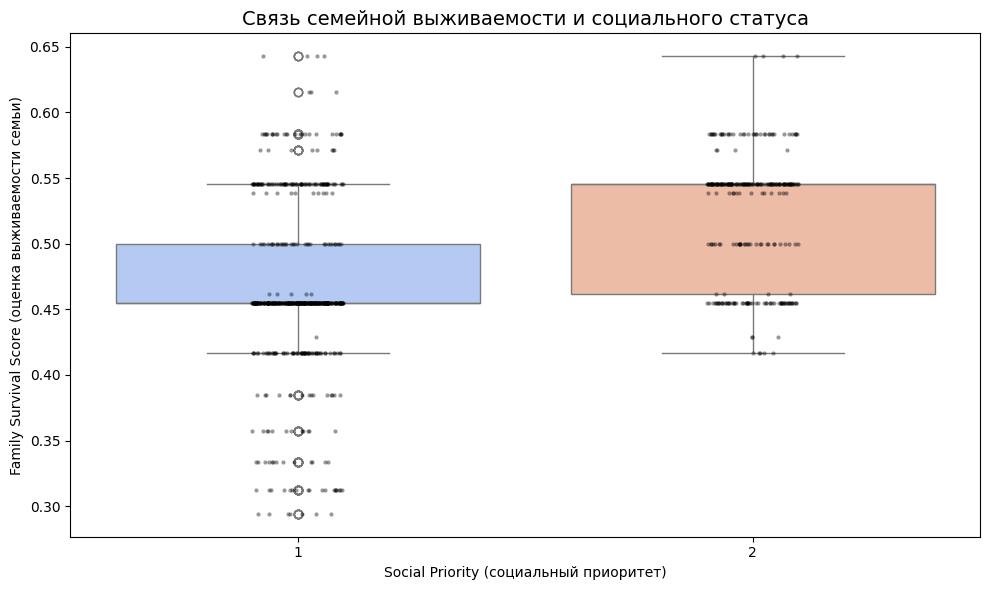

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_family_social_correlation(df):
    if not {'FamilySurvivalScore', 'SocialPriority'}.issubset(df.columns):
        raise ValueError("Не найдены колонки FamilySurvivalScore и SocialPriority")

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df,
        x='SocialPriority',
        y='FamilySurvivalScore',
        palette='coolwarm'
    )
    sns.stripplot(
        data=df,
        x='SocialPriority',
        y='FamilySurvivalScore',
        color='black',
        size=3,
        alpha=0.4
    )
    plt.title("Связь семейной выживаемости и социального статуса", fontsize=14)
    plt.xlabel("Social Priority (социальный приоритет)")
    plt.ylabel("Family Survival Score (оценка выживаемости семьи)")
    plt.tight_layout()
    plt.show()

plot_family_social_correlation(df)


In [ ]:
df.describe().T

count       mean        std       min        25%  \
Survived             891.0   0.383838   0.486592  0.000000   0.000000   
Pclass               891.0   2.308642   0.836071  1.000000   2.000000   
Age                  891.0  29.361582  13.019697  0.420000  22.000000   
SibSp                891.0   0.523008   1.102743  0.000000   0.000000   
Parch                891.0   0.381594   0.806057  0.000000   0.000000   
Fare                 891.0  32.204208  49.693429  0.000000   7.910400   
Sex_male             891.0   0.647587   0.477990  0.000000   0.000000   
Embarked_Q           891.0   0.086420   0.281141  0.000000   0.000000   
Embarked_S           891.0   0.725028   0.446751  0.000000   0.000000   
Title_Master         891.0   0.044893   0.207186  0.000000   0.000000   
Title_Miss           891.0   0.208754   0.406647  0.000000   0.000000   
Title_Mr             891.0   0.589226   0.492251  0.000000   0.000000   
Title_Mrs            891.0   0.142536   0.349796  0.000000   0.000000   
Title_Rev            891.0   0.006734   0.081830  0.000000   0.000000   
FamilySize           891.0   1.904602   1.613459  1.000000   1.000000   
FarePerPerson        891.0  19.916375  35.841257  0.000000   7.250000   
IsAlone              891.0   0.602694   0.489615  0.000000   0.000000   
FamilySurvivalScore  891.0   0.482805   0.066112  0.294118   0.454545   
Sex_female           891.0   0.352413   0.477990  0.000000   0.000000   
SocialPriority       891.0   1.327722   0.469646  1.000000   1.000000   
CompositeScore       891.0   2.028002   1.134638  0.800000   1.000000   
FareClassRatio       891.0  15.631329  36.747132  0.000000   2.502767   
FareClassPercentile  891.0   0.501684   0.287514  0.005092   0.250000   
AboveClassMedian     891.0   0.480359   0.499895  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  35.000000   80.000000  
SibSp                 0.000000   1.000000    8.000000  
Parch                 0.000000   0.000000    6.000000  
Fare                 14.454200  31.000000  512.329200  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    1.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    1.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    1.000000  
FamilySize            1.000000   2.000000   11.000000  
FarePerPerson         8.300000  23.666667  512.329200  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.500000   2.700000    6.750000  
FareClassRatio        2.887500  13.000000  512.329200  
FareClassPercentile   0.498982   0.734654    0.997685  
AboveClassMedian      0.000000   1.000000    1.000000

### 2.2. Предобработка данных

#### 2.2.0 Сведение к задачи бинарной классификации

Целевая метка для задачи **бинарной** классификации `Survived`

In [ ]:
df['Survived'] = (df['Survived'] == 1).astype(np.int64)
df['Survived'].head(4)

0    0
1    1
2    1
3    1
Name: Survived, dtype: int64

#### 2.3.1. Создадим копию данных `df_lin` для линейной `классификации`, `KNN`, `SVM`, `df_raw` оставим для бустинга и деревьев 😸

In [ ]:
df_lin = df.copy()
dr_raw = df.copy()
df_lin['Survived'].head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

#### 2.3.2. Создание методов для отрисовки и обработки данных

Корреляционная матрица

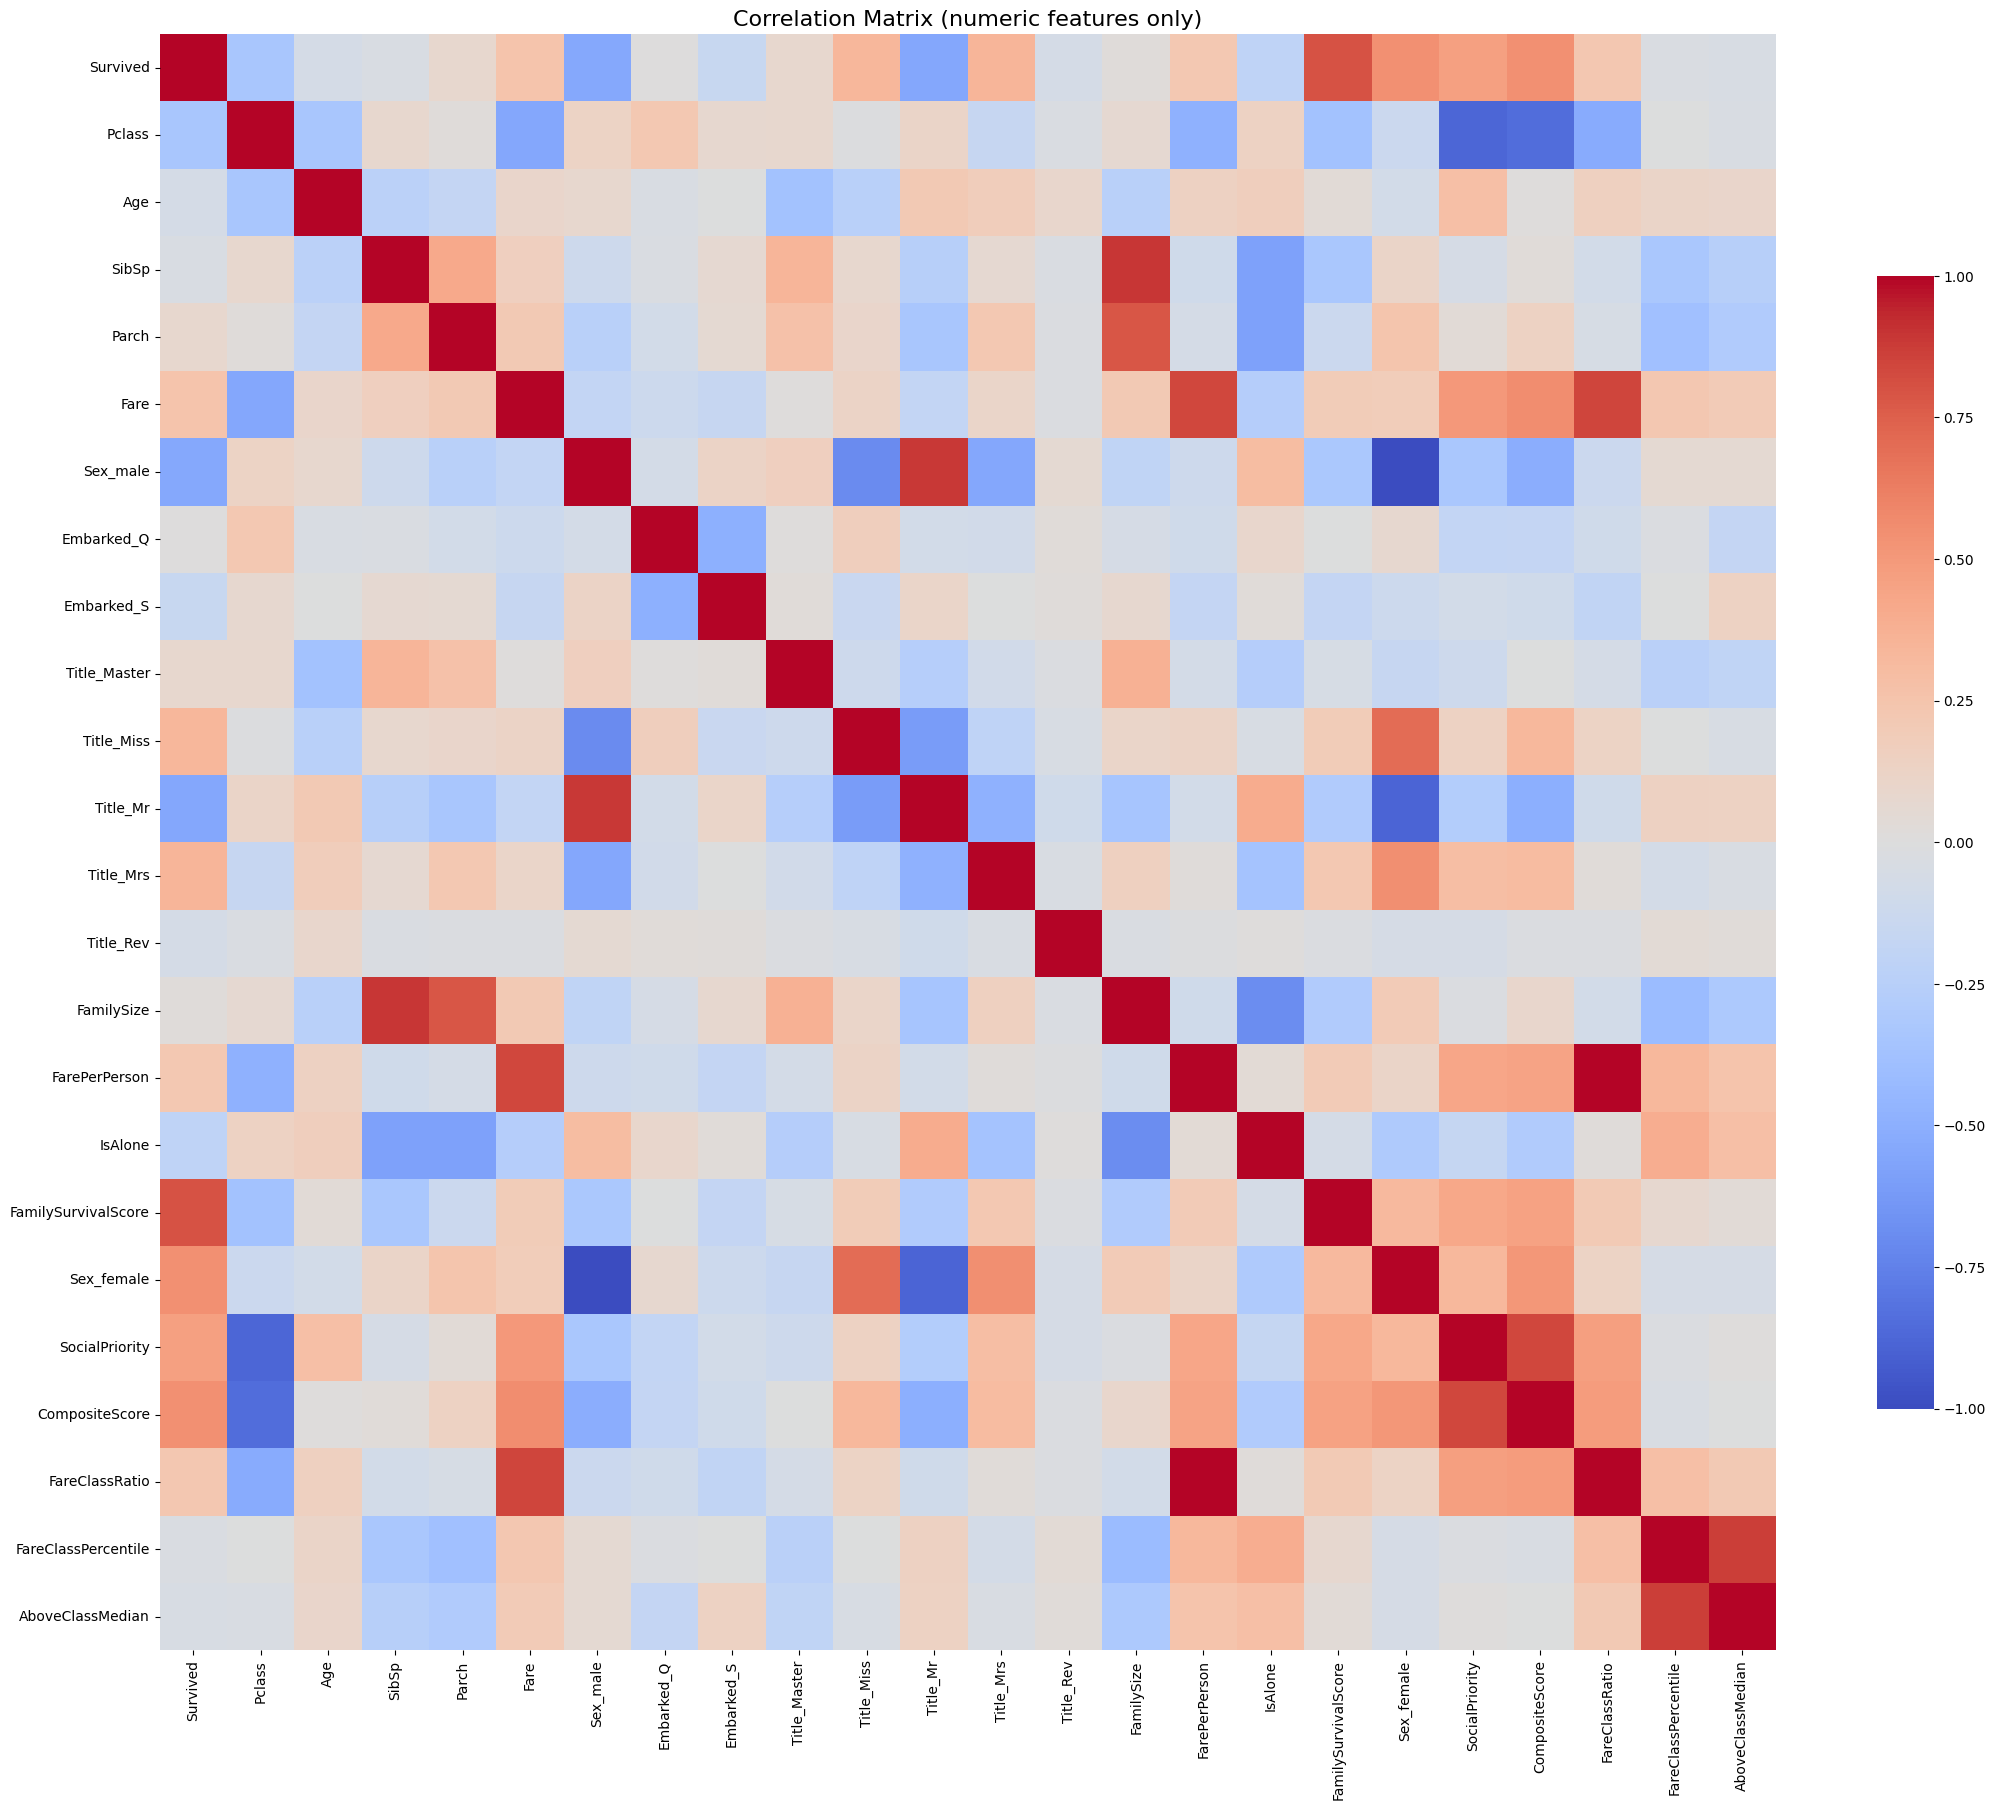

count       mean        std       min        25%  \
Survived             891.0   0.383838   0.486592  0.000000   0.000000   
Pclass               891.0   2.308642   0.836071  1.000000   2.000000   
Age                  891.0  29.361582  13.019697  0.420000  22.000000   
SibSp                891.0   0.523008   1.102743  0.000000   0.000000   
Parch                891.0   0.381594   0.806057  0.000000   0.000000   
Fare                 891.0  32.204208  49.693429  0.000000   7.910400   
Sex_male             891.0   0.647587   0.477990  0.000000   0.000000   
Embarked_Q           891.0   0.086420   0.281141  0.000000   0.000000   
Embarked_S           891.0   0.725028   0.446751  0.000000   0.000000   
Title_Master         891.0   0.044893   0.207186  0.000000   0.000000   
Title_Miss           891.0   0.208754   0.406647  0.000000   0.000000   
Title_Mr             891.0   0.589226   0.492251  0.000000   0.000000   
Title_Mrs            891.0   0.142536   0.349796  0.000000   0.000000   
Title_Rev            891.0   0.006734   0.081830  0.000000   0.000000   
FamilySize           891.0   1.904602   1.613459  1.000000   1.000000   
FarePerPerson        891.0  19.916375  35.841257  0.000000   7.250000   
IsAlone              891.0   0.602694   0.489615  0.000000   0.000000   
FamilySurvivalScore  891.0   0.482805   0.066112  0.294118   0.454545   
Sex_female           891.0   0.352413   0.477990  0.000000   0.000000   
SocialPriority       891.0   1.327722   0.469646  1.000000   1.000000   
CompositeScore       891.0   2.028002   1.134638  0.800000   1.000000   
FareClassRatio       891.0  15.631329  36.747132  0.000000   2.502767   
FareClassPercentile  891.0   0.501684   0.287514  0.005092   0.250000   
AboveClassMedian     891.0   0.480359   0.499895  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  35.000000   80.000000  
SibSp                 0.000000   1.000000    8.000000  
Parch                 0.000000   0.000000    6.000000  
Fare                 14.454200  31.000000  512.329200  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    1.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    1.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    1.000000  
FamilySize            1.000000   2.000000   11.000000  
FarePerPerson         8.300000  23.666667  512.329200  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.500000   2.700000    6.750000  
FareClassRatio        2.887500  13.000000  512.329200  
FareClassPercentile   0.498982   0.734654    0.997685  
AboveClassMedian      0.000000   1.000000    1.000000

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_corr_matrix(df):
    corr = df.select_dtypes(include=['number']).corr()
    corr = corr.dropna(how="all", axis=0).dropna(how="all", axis=1)

    plt.figure(figsize=(22, 18))
    sns.heatmap(
        corr,
        annot=False,
        cmap="coolwarm",
        square=True,
        cbar_kws={"shrink": .7}
    )
    plt.title("Correlation Matrix (numeric features only)", fontsize=16)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()


# example
draw_corr_matrix(df_lin)
df_lin.describe().T

Гистограмма распределения

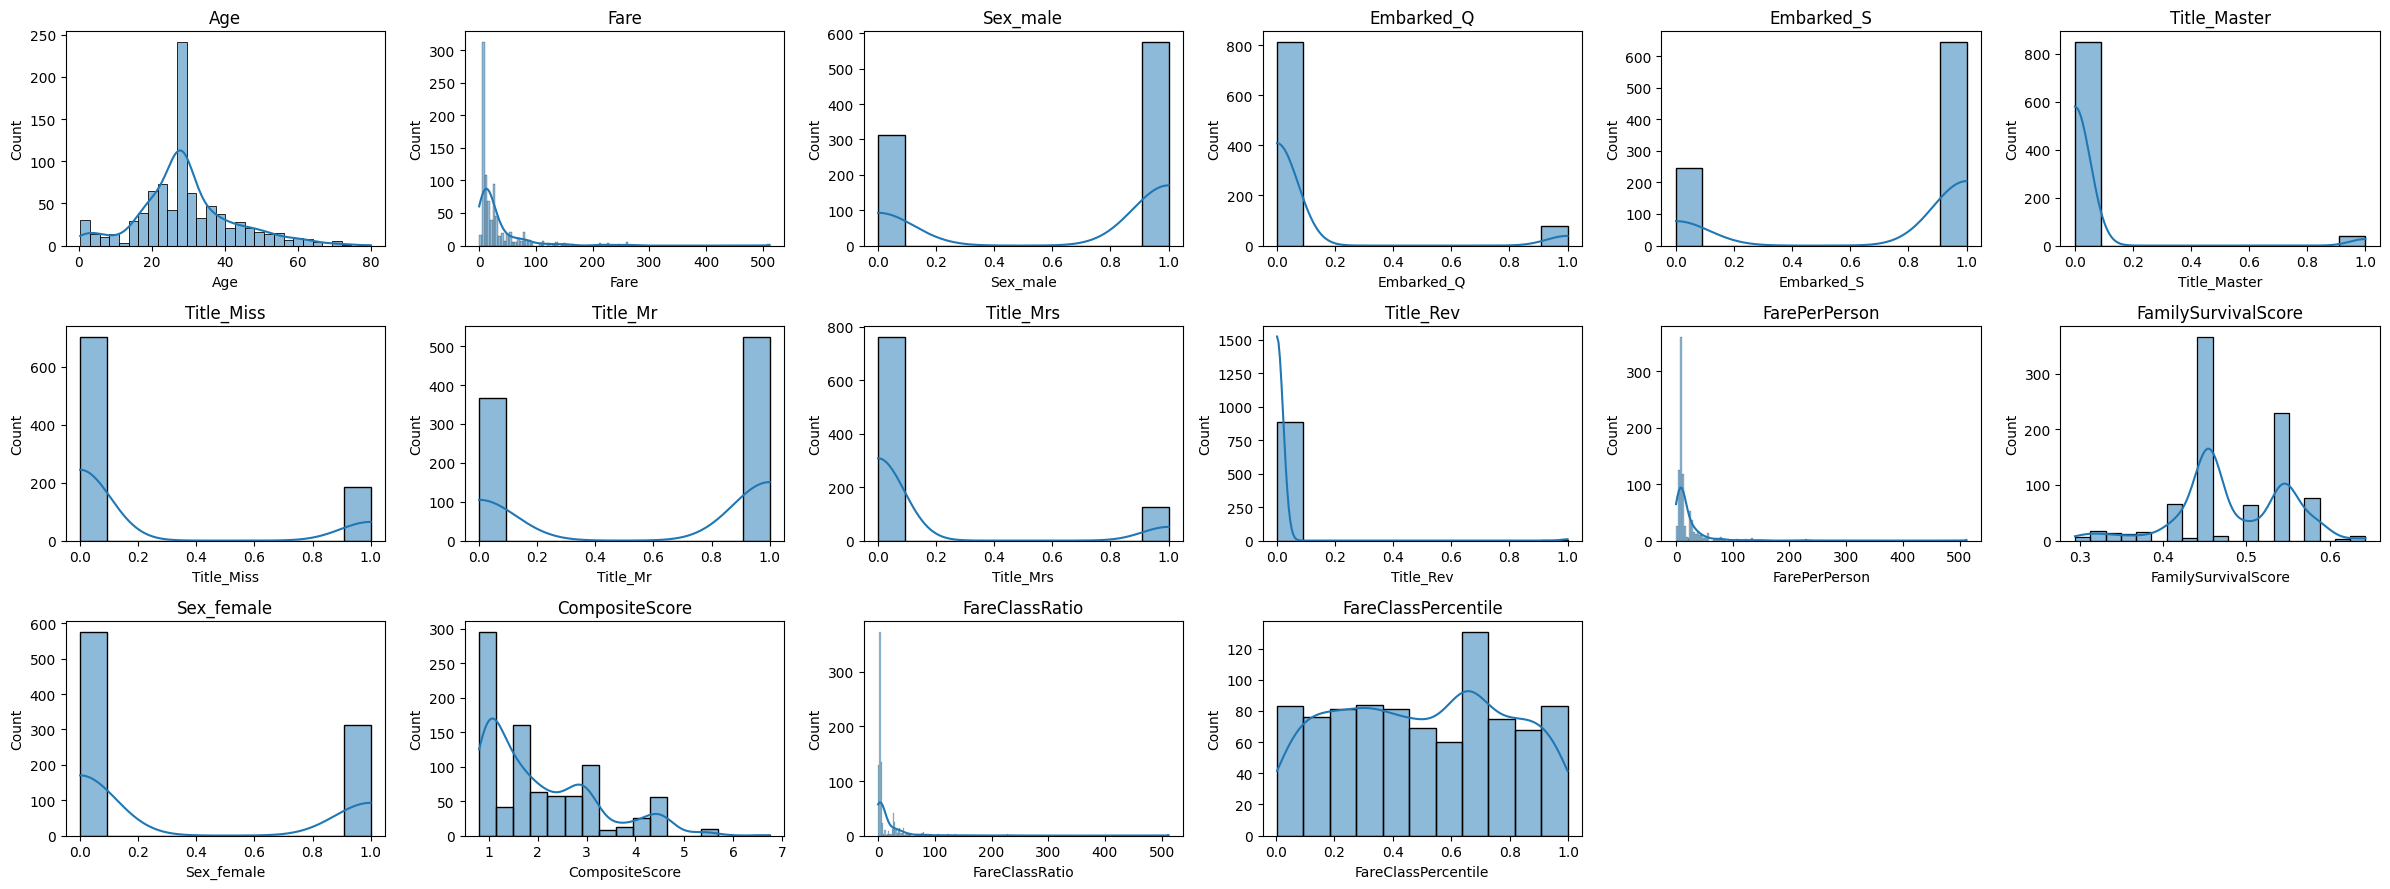

count       mean        std       min        25%  \
Survived             891.0   0.383838   0.486592  0.000000   0.000000   
Pclass               891.0   2.308642   0.836071  1.000000   2.000000   
Age                  891.0  29.361582  13.019697  0.420000  22.000000   
SibSp                891.0   0.523008   1.102743  0.000000   0.000000   
Parch                891.0   0.381594   0.806057  0.000000   0.000000   
Fare                 891.0  32.204208  49.693429  0.000000   7.910400   
Sex_male             891.0   0.647587   0.477990  0.000000   0.000000   
Embarked_Q           891.0   0.086420   0.281141  0.000000   0.000000   
Embarked_S           891.0   0.725028   0.446751  0.000000   0.000000   
Title_Master         891.0   0.044893   0.207186  0.000000   0.000000   
Title_Miss           891.0   0.208754   0.406647  0.000000   0.000000   
Title_Mr             891.0   0.589226   0.492251  0.000000   0.000000   
Title_Mrs            891.0   0.142536   0.349796  0.000000   0.000000   
Title_Rev            891.0   0.006734   0.081830  0.000000   0.000000   
FamilySize           891.0   1.904602   1.613459  1.000000   1.000000   
FarePerPerson        891.0  19.916375  35.841257  0.000000   7.250000   
IsAlone              891.0   0.602694   0.489615  0.000000   0.000000   
FamilySurvivalScore  891.0   0.482805   0.066112  0.294118   0.454545   
Sex_female           891.0   0.352413   0.477990  0.000000   0.000000   
SocialPriority       891.0   1.327722   0.469646  1.000000   1.000000   
CompositeScore       891.0   2.028002   1.134638  0.800000   1.000000   
FareClassRatio       891.0  15.631329  36.747132  0.000000   2.502767   
FareClassPercentile  891.0   0.501684   0.287514  0.005092   0.250000   
AboveClassMedian     891.0   0.480359   0.499895  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  35.000000   80.000000  
SibSp                 0.000000   1.000000    8.000000  
Parch                 0.000000   0.000000    6.000000  
Fare                 14.454200  31.000000  512.329200  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    1.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    1.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    1.000000  
FamilySize            1.000000   2.000000   11.000000  
FarePerPerson         8.300000  23.666667  512.329200  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.500000   2.700000    6.750000  
FareClassRatio        2.887500  13.000000  512.329200  
FareClassPercentile   0.498982   0.734654    0.997685  
AboveClassMedian      0.000000   1.000000    1.000000

In [ ]:
def draw_hist(df: pd.DataFrame, n_cols=6):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_hist(df_lin)
df_lin.describe().T

Соотношение с целевой переменной + коэфициент пирсона

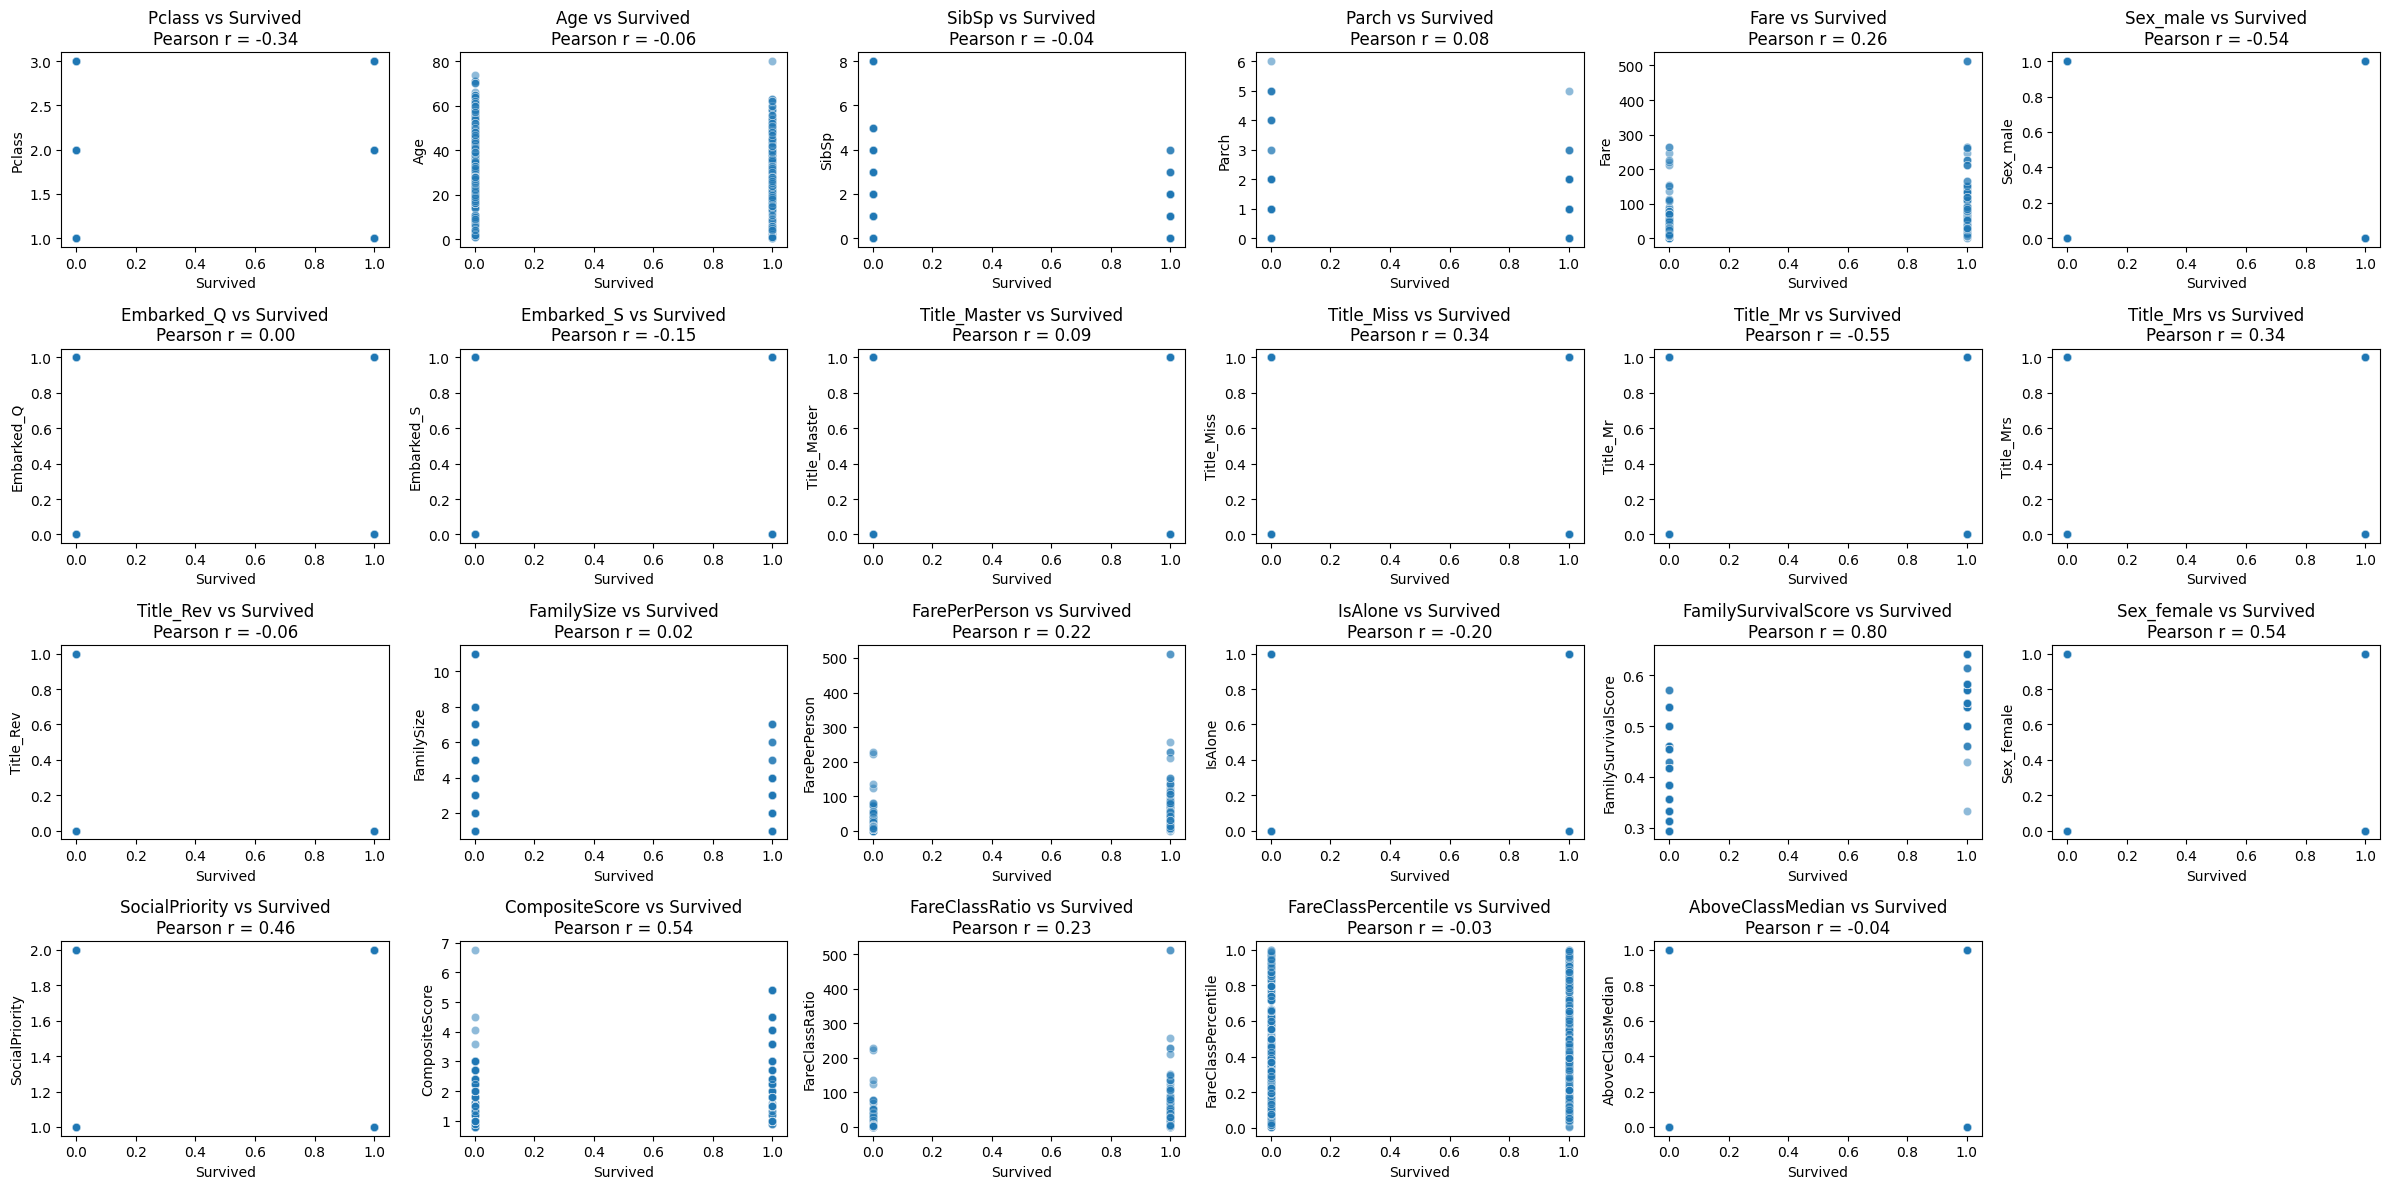

count       mean        std       min        25%  \
Survived             891.0   0.383838   0.486592  0.000000   0.000000   
Pclass               891.0   2.308642   0.836071  1.000000   2.000000   
Age                  891.0  29.361582  13.019697  0.420000  22.000000   
SibSp                891.0   0.523008   1.102743  0.000000   0.000000   
Parch                891.0   0.381594   0.806057  0.000000   0.000000   
Fare                 891.0  32.204208  49.693429  0.000000   7.910400   
Sex_male             891.0   0.647587   0.477990  0.000000   0.000000   
Embarked_Q           891.0   0.086420   0.281141  0.000000   0.000000   
Embarked_S           891.0   0.725028   0.446751  0.000000   0.000000   
Title_Master         891.0   0.044893   0.207186  0.000000   0.000000   
Title_Miss           891.0   0.208754   0.406647  0.000000   0.000000   
Title_Mr             891.0   0.589226   0.492251  0.000000   0.000000   
Title_Mrs            891.0   0.142536   0.349796  0.000000   0.000000   
Title_Rev            891.0   0.006734   0.081830  0.000000   0.000000   
FamilySize           891.0   1.904602   1.613459  1.000000   1.000000   
FarePerPerson        891.0  19.916375  35.841257  0.000000   7.250000   
IsAlone              891.0   0.602694   0.489615  0.000000   0.000000   
FamilySurvivalScore  891.0   0.482805   0.066112  0.294118   0.454545   
Sex_female           891.0   0.352413   0.477990  0.000000   0.000000   
SocialPriority       891.0   1.327722   0.469646  1.000000   1.000000   
CompositeScore       891.0   2.028002   1.134638  0.800000   1.000000   
FareClassRatio       891.0  15.631329  36.747132  0.000000   2.502767   
FareClassPercentile  891.0   0.501684   0.287514  0.005092   0.250000   
AboveClassMedian     891.0   0.480359   0.499895  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  35.000000   80.000000  
SibSp                 0.000000   1.000000    8.000000  
Parch                 0.000000   0.000000    6.000000  
Fare                 14.454200  31.000000  512.329200  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    1.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    1.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    1.000000  
FamilySize            1.000000   2.000000   11.000000  
FarePerPerson         8.300000  23.666667  512.329200  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.500000   2.700000    6.750000  
FareClassRatio        2.887500  13.000000  512.329200  
FareClassPercentile   0.498982   0.734654    0.997685  
AboveClassMedian      0.000000   1.000000    1.000000

In [ ]:
def draw_scatter_vs_target(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.scatterplot(x=target, y=col, data=df, ax=axs[i], alpha=0.5)

        # коэффициент корреляции Пирсона
        corr = df[col].corr(df[target], method='pearson')
        axs[i].set_title(f'{col} vs {target}\nPearson r = {corr:.2f}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_scatter_vs_target(df_lin, target="Survived")
df_lin.describe().T

Ящик с усами

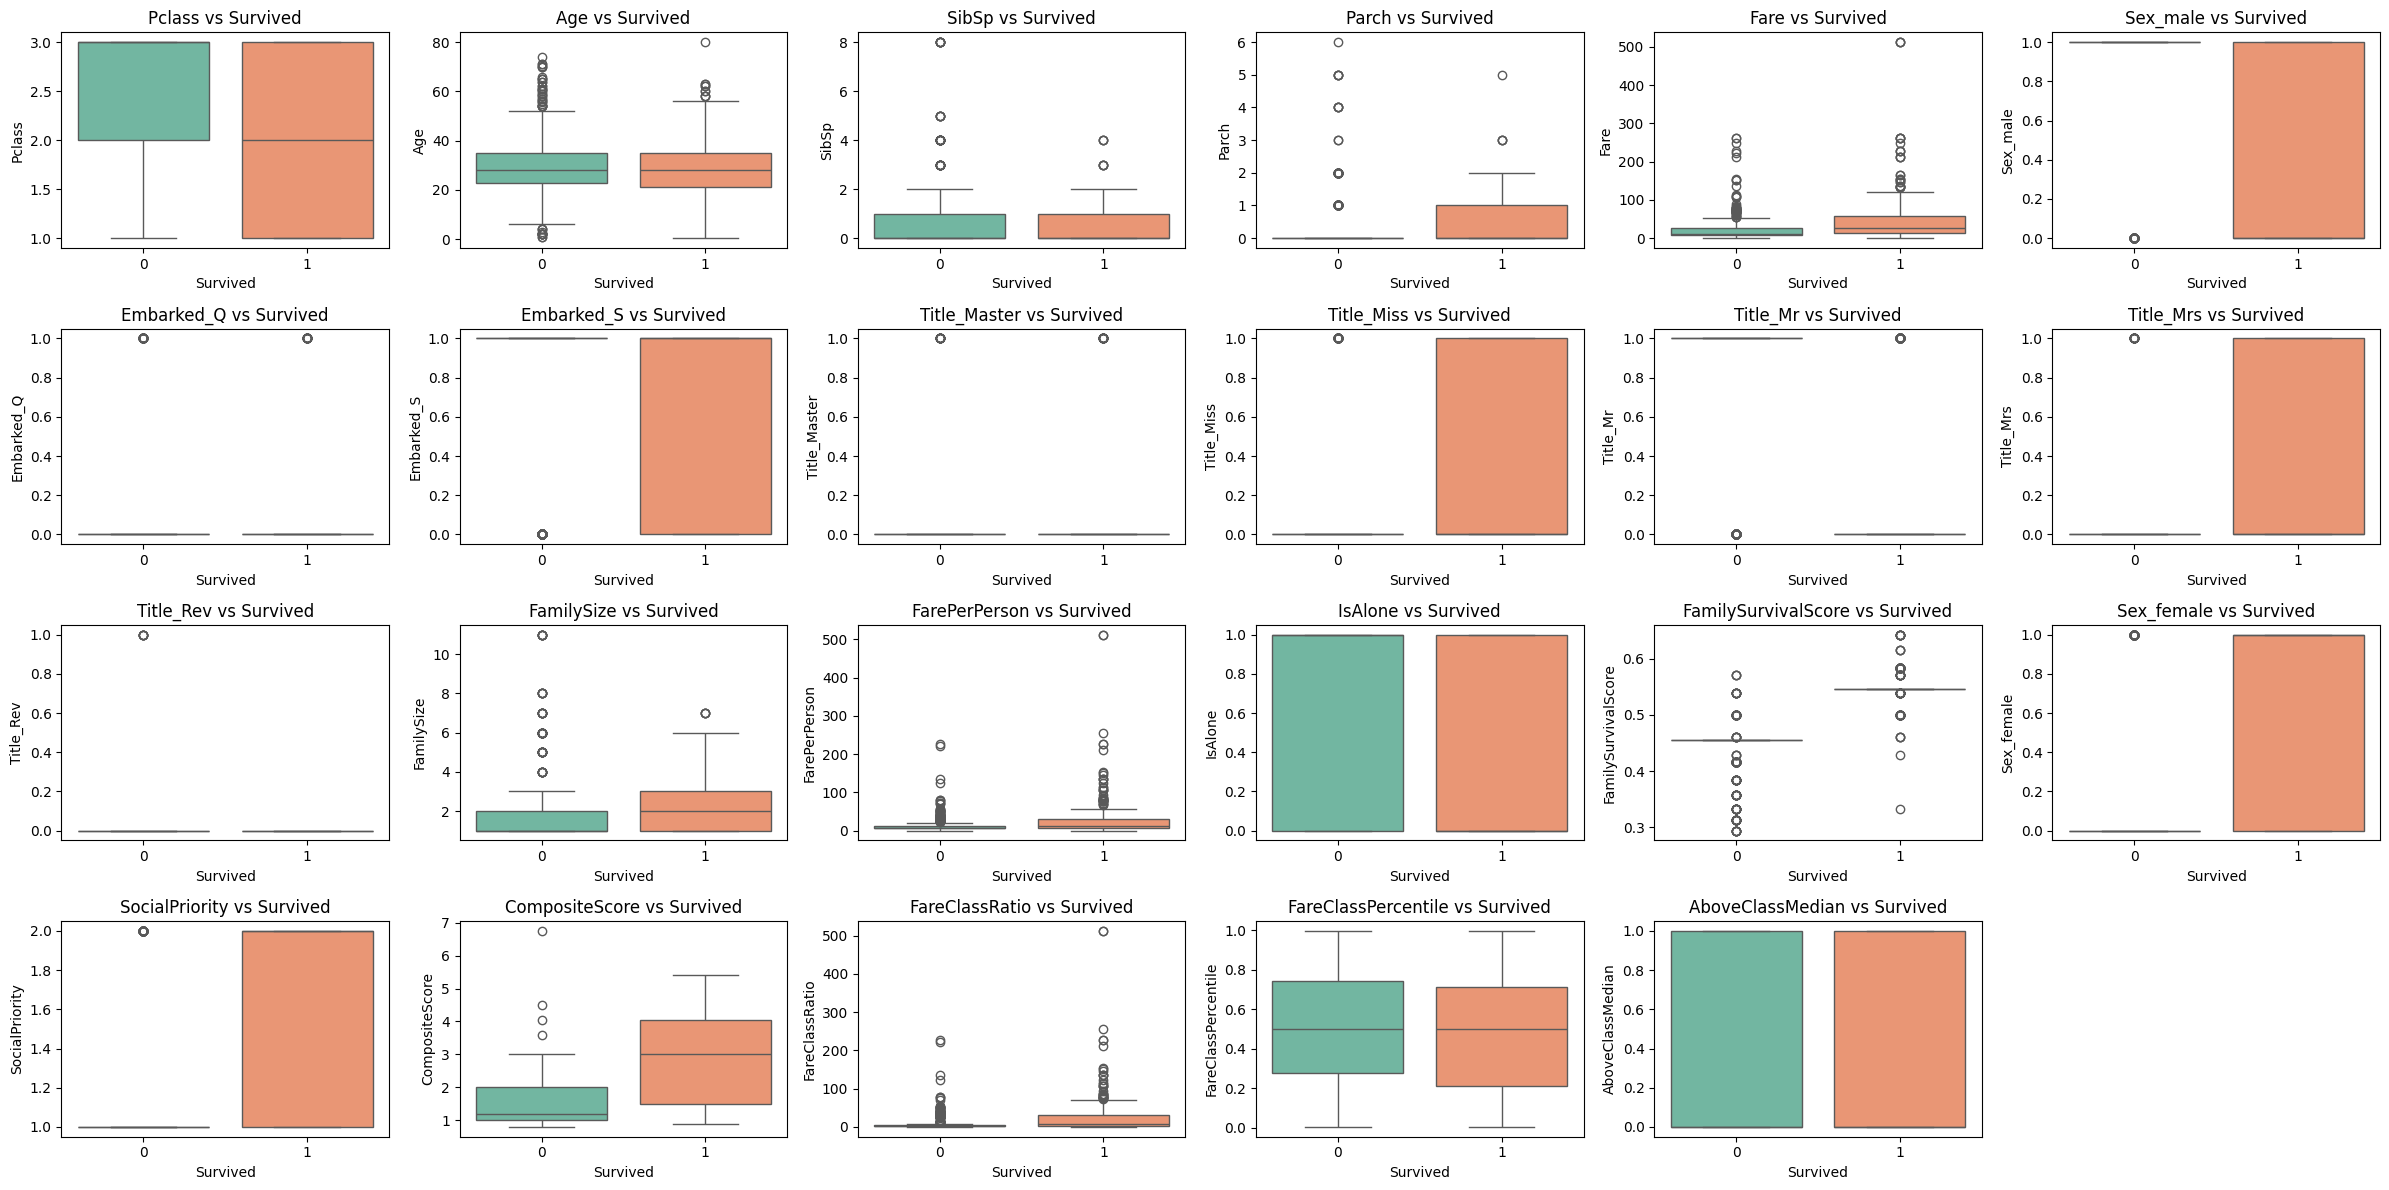

count       mean        std       min        25%  \
Survived             891.0   0.383838   0.486592  0.000000   0.000000   
Pclass               891.0   2.308642   0.836071  1.000000   2.000000   
Age                  891.0  29.361582  13.019697  0.420000  22.000000   
SibSp                891.0   0.523008   1.102743  0.000000   0.000000   
Parch                891.0   0.381594   0.806057  0.000000   0.000000   
Fare                 891.0  32.204208  49.693429  0.000000   7.910400   
Sex_male             891.0   0.647587   0.477990  0.000000   0.000000   
Embarked_Q           891.0   0.086420   0.281141  0.000000   0.000000   
Embarked_S           891.0   0.725028   0.446751  0.000000   0.000000   
Title_Master         891.0   0.044893   0.207186  0.000000   0.000000   
Title_Miss           891.0   0.208754   0.406647  0.000000   0.000000   
Title_Mr             891.0   0.589226   0.492251  0.000000   0.000000   
Title_Mrs            891.0   0.142536   0.349796  0.000000   0.000000   
Title_Rev            891.0   0.006734   0.081830  0.000000   0.000000   
FamilySize           891.0   1.904602   1.613459  1.000000   1.000000   
FarePerPerson        891.0  19.916375  35.841257  0.000000   7.250000   
IsAlone              891.0   0.602694   0.489615  0.000000   0.000000   
FamilySurvivalScore  891.0   0.482805   0.066112  0.294118   0.454545   
Sex_female           891.0   0.352413   0.477990  0.000000   0.000000   
SocialPriority       891.0   1.327722   0.469646  1.000000   1.000000   
CompositeScore       891.0   2.028002   1.134638  0.800000   1.000000   
FareClassRatio       891.0  15.631329  36.747132  0.000000   2.502767   
FareClassPercentile  891.0   0.501684   0.287514  0.005092   0.250000   
AboveClassMedian     891.0   0.480359   0.499895  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  35.000000   80.000000  
SibSp                 0.000000   1.000000    8.000000  
Parch                 0.000000   0.000000    6.000000  
Fare                 14.454200  31.000000  512.329200  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    1.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    1.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    1.000000  
FamilySize            1.000000   2.000000   11.000000  
FarePerPerson         8.300000  23.666667  512.329200  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.500000   2.700000    6.750000  
FareClassRatio        2.887500  13.000000  512.329200  
FareClassPercentile   0.498982   0.734654    0.997685  
AboveClassMedian      0.000000   1.000000    1.000000

In [ ]:
def draw_boxplots(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.boxplot(
            x=target, y=col, data=df, ax=axs[i],
            hue=target, palette="Set2", legend=False
        )
        axs[i].set_title(f'{col} vs {target}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_boxplots(df_lin, target="Survived")
df_lin.describe().T

Удаление выбросов

In [ ]:
# обработка выбросов
def remove_outliers_iqr(df, columns, low, high):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(low)
        Q3 = df_clean[col].quantile(high)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

Подготовка правых скосов

In [ ]:
# обработка скосов
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

#### 2.3.3. Посмотрим на выбросы переменных

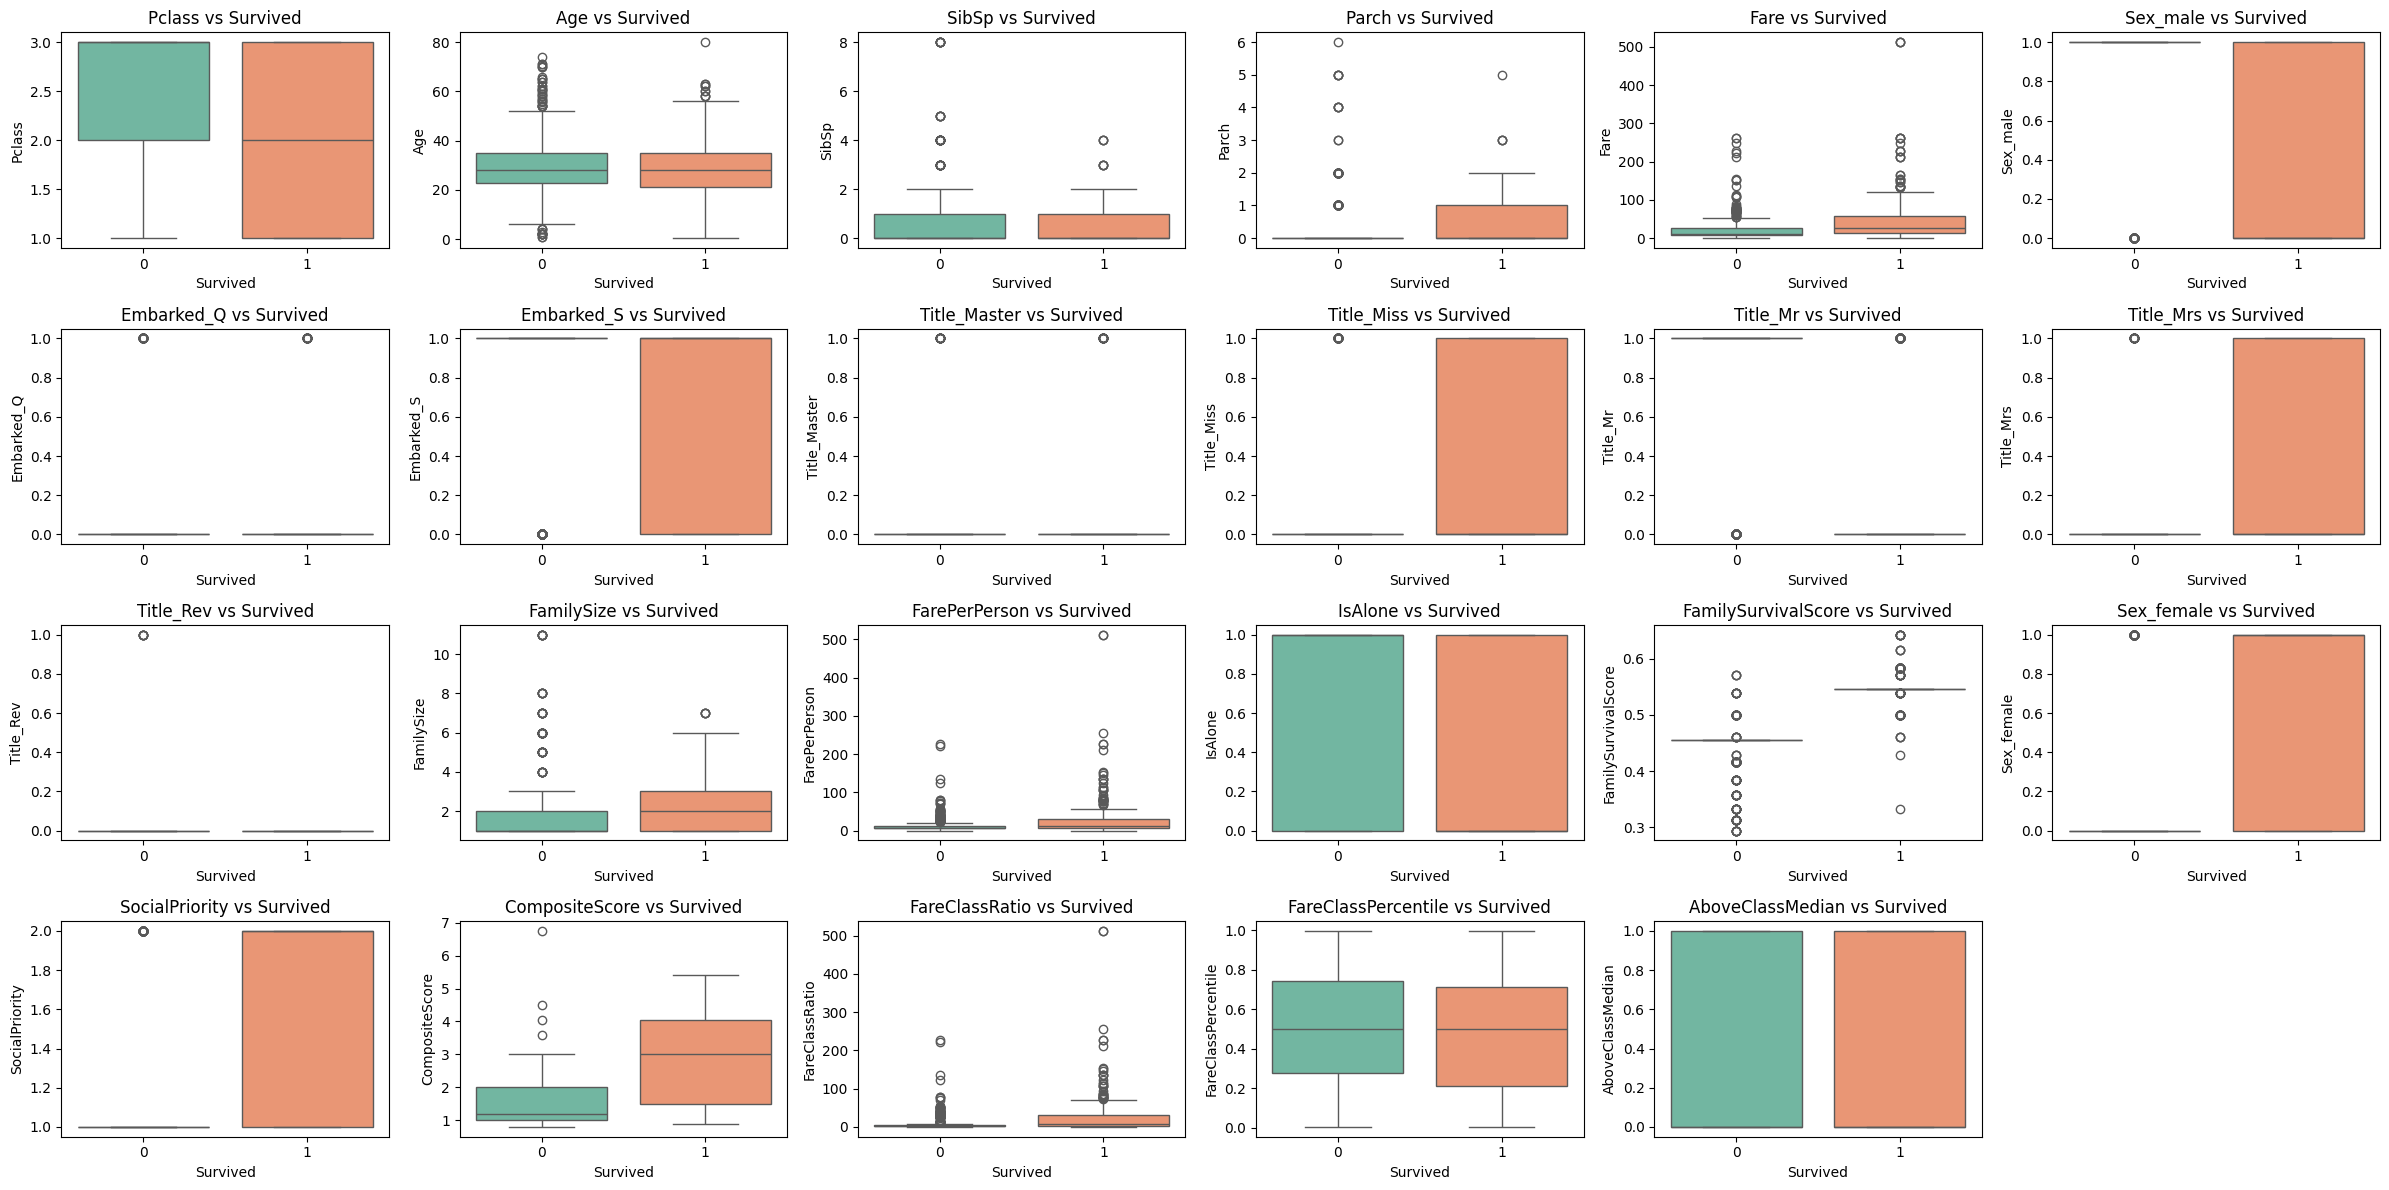

count       mean        std       min        25%  \
Survived             891.0   0.383838   0.486592  0.000000   0.000000   
Pclass               891.0   2.308642   0.836071  1.000000   2.000000   
Age                  891.0  29.361582  13.019697  0.420000  22.000000   
SibSp                891.0   0.523008   1.102743  0.000000   0.000000   
Parch                891.0   0.381594   0.806057  0.000000   0.000000   
Fare                 891.0  32.204208  49.693429  0.000000   7.910400   
Sex_male             891.0   0.647587   0.477990  0.000000   0.000000   
Embarked_Q           891.0   0.086420   0.281141  0.000000   0.000000   
Embarked_S           891.0   0.725028   0.446751  0.000000   0.000000   
Title_Master         891.0   0.044893   0.207186  0.000000   0.000000   
Title_Miss           891.0   0.208754   0.406647  0.000000   0.000000   
Title_Mr             891.0   0.589226   0.492251  0.000000   0.000000   
Title_Mrs            891.0   0.142536   0.349796  0.000000   0.000000   
Title_Rev            891.0   0.006734   0.081830  0.000000   0.000000   
FamilySize           891.0   1.904602   1.613459  1.000000   1.000000   
FarePerPerson        891.0  19.916375  35.841257  0.000000   7.250000   
IsAlone              891.0   0.602694   0.489615  0.000000   0.000000   
FamilySurvivalScore  891.0   0.482805   0.066112  0.294118   0.454545   
Sex_female           891.0   0.352413   0.477990  0.000000   0.000000   
SocialPriority       891.0   1.327722   0.469646  1.000000   1.000000   
CompositeScore       891.0   2.028002   1.134638  0.800000   1.000000   
FareClassRatio       891.0  15.631329  36.747132  0.000000   2.502767   
FareClassPercentile  891.0   0.501684   0.287514  0.005092   0.250000   
AboveClassMedian     891.0   0.480359   0.499895  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  35.000000   80.000000  
SibSp                 0.000000   1.000000    8.000000  
Parch                 0.000000   0.000000    6.000000  
Fare                 14.454200  31.000000  512.329200  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    1.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    1.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    1.000000  
FamilySize            1.000000   2.000000   11.000000  
FarePerPerson         8.300000  23.666667  512.329200  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.500000   2.700000    6.750000  
FareClassRatio        2.887500  13.000000  512.329200  
FareClassPercentile   0.498982   0.734654    0.997685  
AboveClassMedian      0.000000   1.000000    1.000000

In [ ]:
draw_boxplots(df_lin, 'Survived', n_cols=6)

df_lin.describe().T

Удалим выбросы

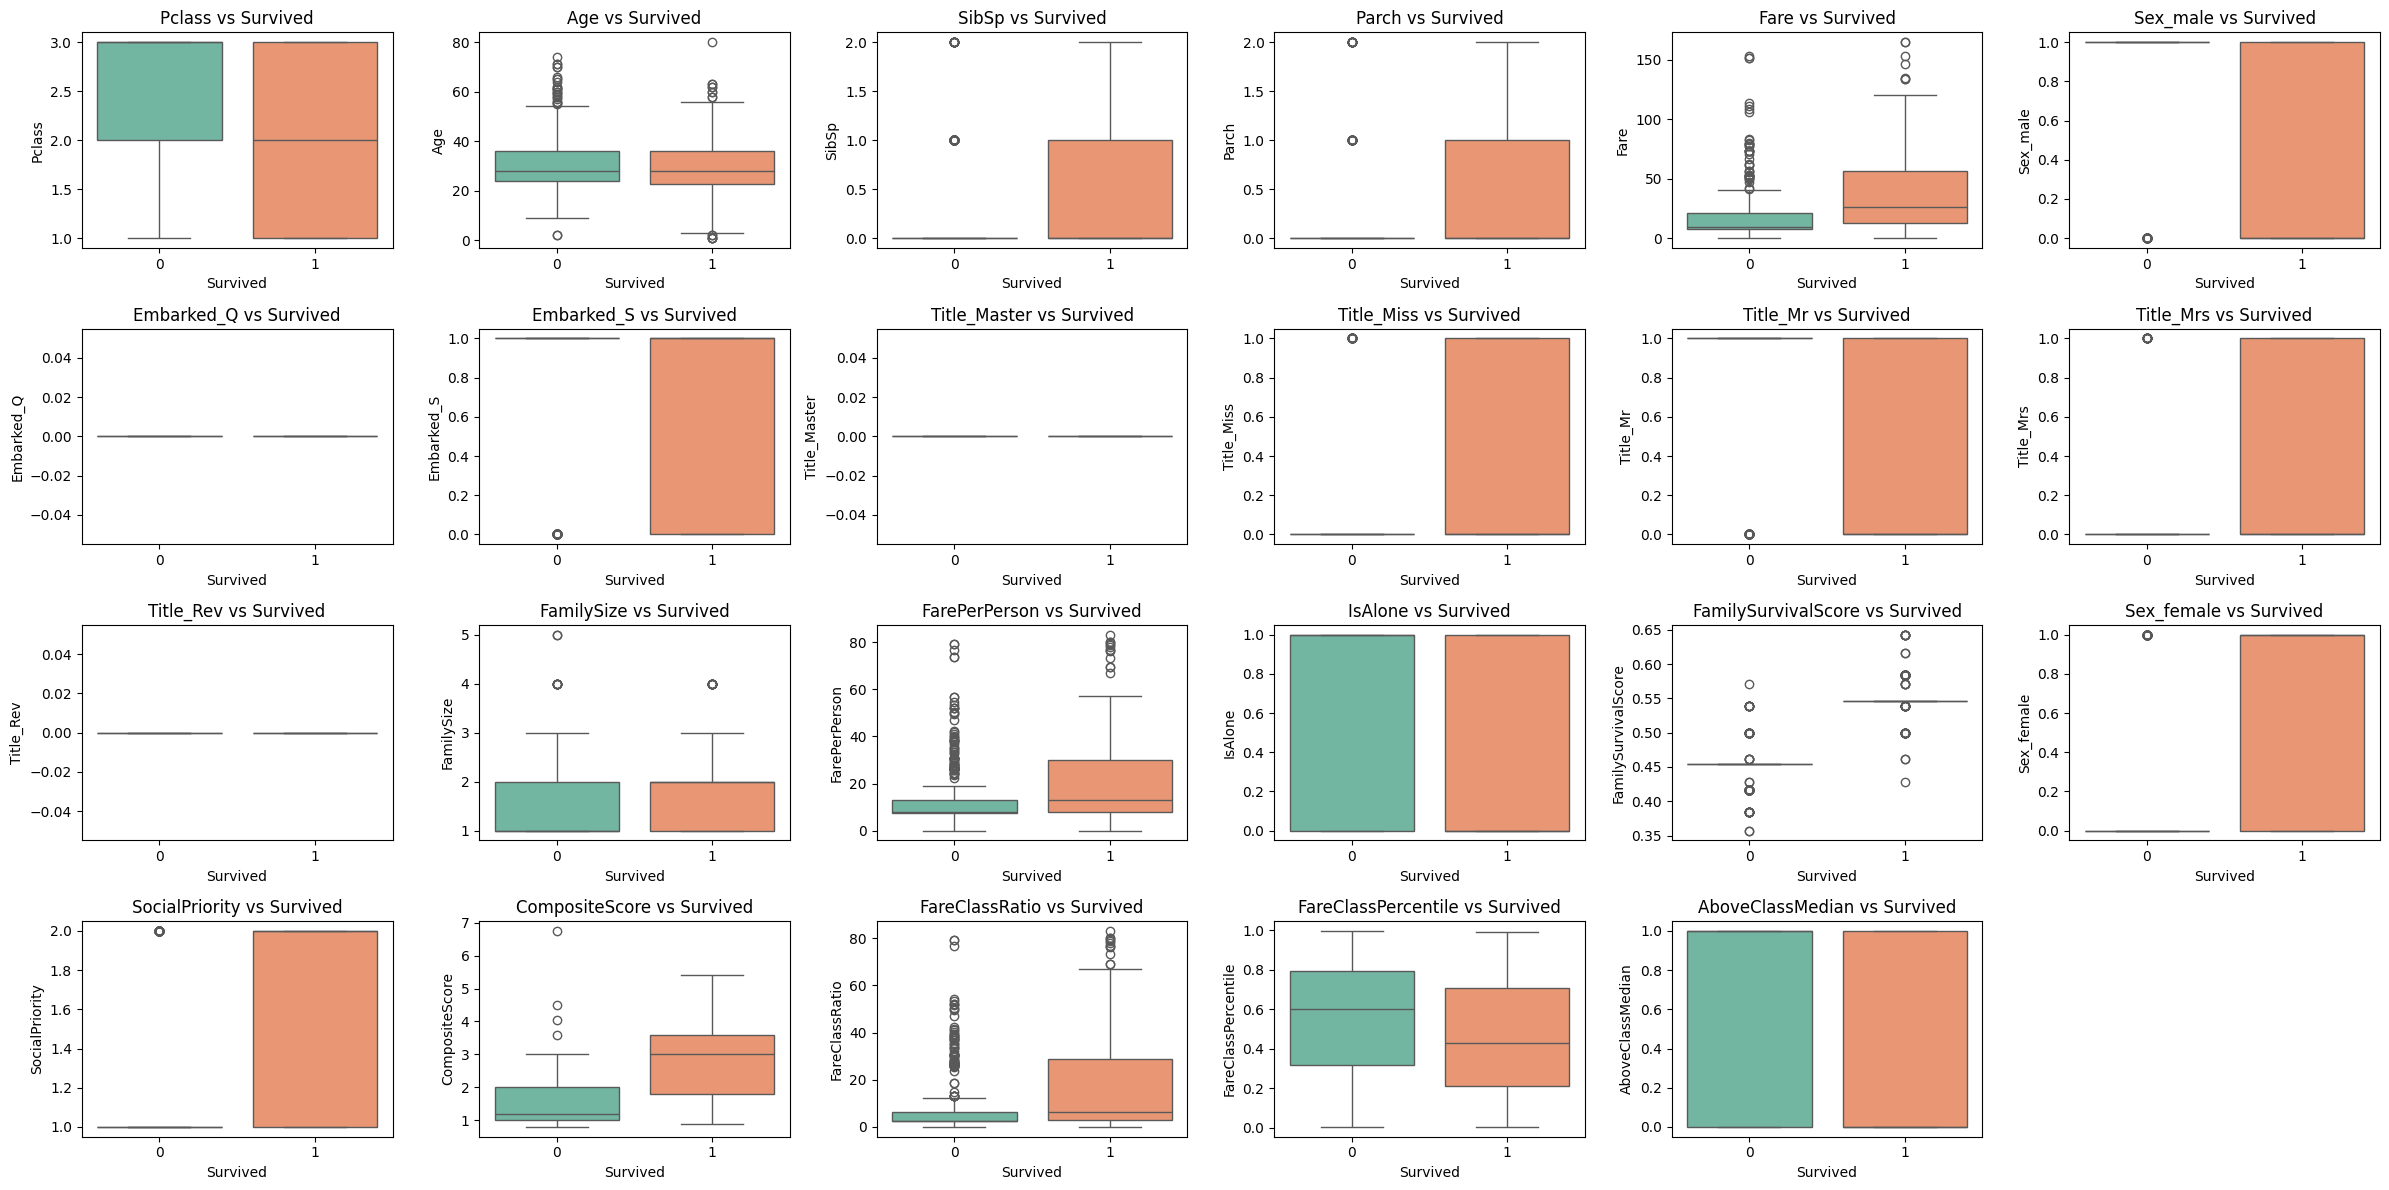

count       mean        std       min        25%  \
Survived             702.0   0.363248   0.481278  0.000000   0.000000   
Pclass               702.0   2.259259   0.836758  1.000000   1.000000   
Age                  702.0  30.740741  12.397522  0.750000  23.000000   
SibSp                702.0   0.303419   0.521125  0.000000   0.000000   
Parch                702.0   0.230769   0.542903  0.000000   0.000000   
Fare                 702.0  25.355964  28.000286  0.000000   7.925000   
Sex_male             702.0   0.679487   0.467006  0.000000   0.000000   
Embarked_Q           702.0   0.000000   0.000000  0.000000   0.000000   
Embarked_S           702.0   0.794872   0.404083  0.000000   1.000000   
Title_Master         702.0   0.000000   0.000000  0.000000   0.000000   
Title_Miss           702.0   0.165242   0.371664  0.000000   0.000000   
Title_Mr             702.0   0.672365   0.469686  0.000000   0.000000   
Title_Mrs            702.0   0.153846   0.361058  0.000000   0.000000   
Title_Rev            702.0   0.000000   0.000000  0.000000   0.000000   
FamilySize           702.0   1.534188   0.836643  1.000000   1.000000   
FarePerPerson        702.0  16.560533  15.554069  0.000000   7.775000   
IsAlone              702.0   0.650997   0.476995  0.000000   0.000000   
FamilySurvivalScore  702.0   0.487062   0.054575  0.357143   0.454545   
Sex_female           702.0   0.320513   0.467006  0.000000   0.000000   
SocialPriority       702.0   1.354701   0.478764  1.000000   1.000000   
CompositeScore       702.0   2.023647   1.119639  0.800000   1.000000   
FareClassRatio       702.0  12.088091  16.453874  0.000000   2.593400   
FareClassPercentile  702.0   0.519830   0.281533  0.005092   0.304481   
AboveClassMedian     702.0   0.534188   0.499185  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  36.000000   80.000000  
SibSp                 0.000000   1.000000    2.000000  
Parch                 0.000000   0.000000    2.000000  
Fare                 13.000000  27.742700  164.866700  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    0.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    0.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    0.000000  
FamilySize            1.000000   2.000000    5.000000  
FarePerPerson         9.225000  25.929200   83.158300  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.800000   2.700000    6.750000  
FareClassRatio        3.327783  17.518067   83.158300  
FareClassPercentile   0.553971   0.775463    0.997283  
AboveClassMedian      1.000000   1.000000    1.000000

In [ ]:
df_lin = remove_outliers_iqr(df_lin, df_lin.select_dtypes(include=['float', 'int']).columns.drop('Survived'), 0.1, 0.9)

# mask = ((df["Fare"] <= 100) & (df["Parch"] <= 2)) & ((df["SibSp"] <= 2) & (df["Age"] <= 65)) & (df["Fare"] < 500)
# df_lin = df.loc[mask]
# df_lin.describe().T
draw_boxplots(df_lin, target="Survived")
df_lin.describe().T

#### 2.3.4. Посмотрим на скошенные столбцы справа

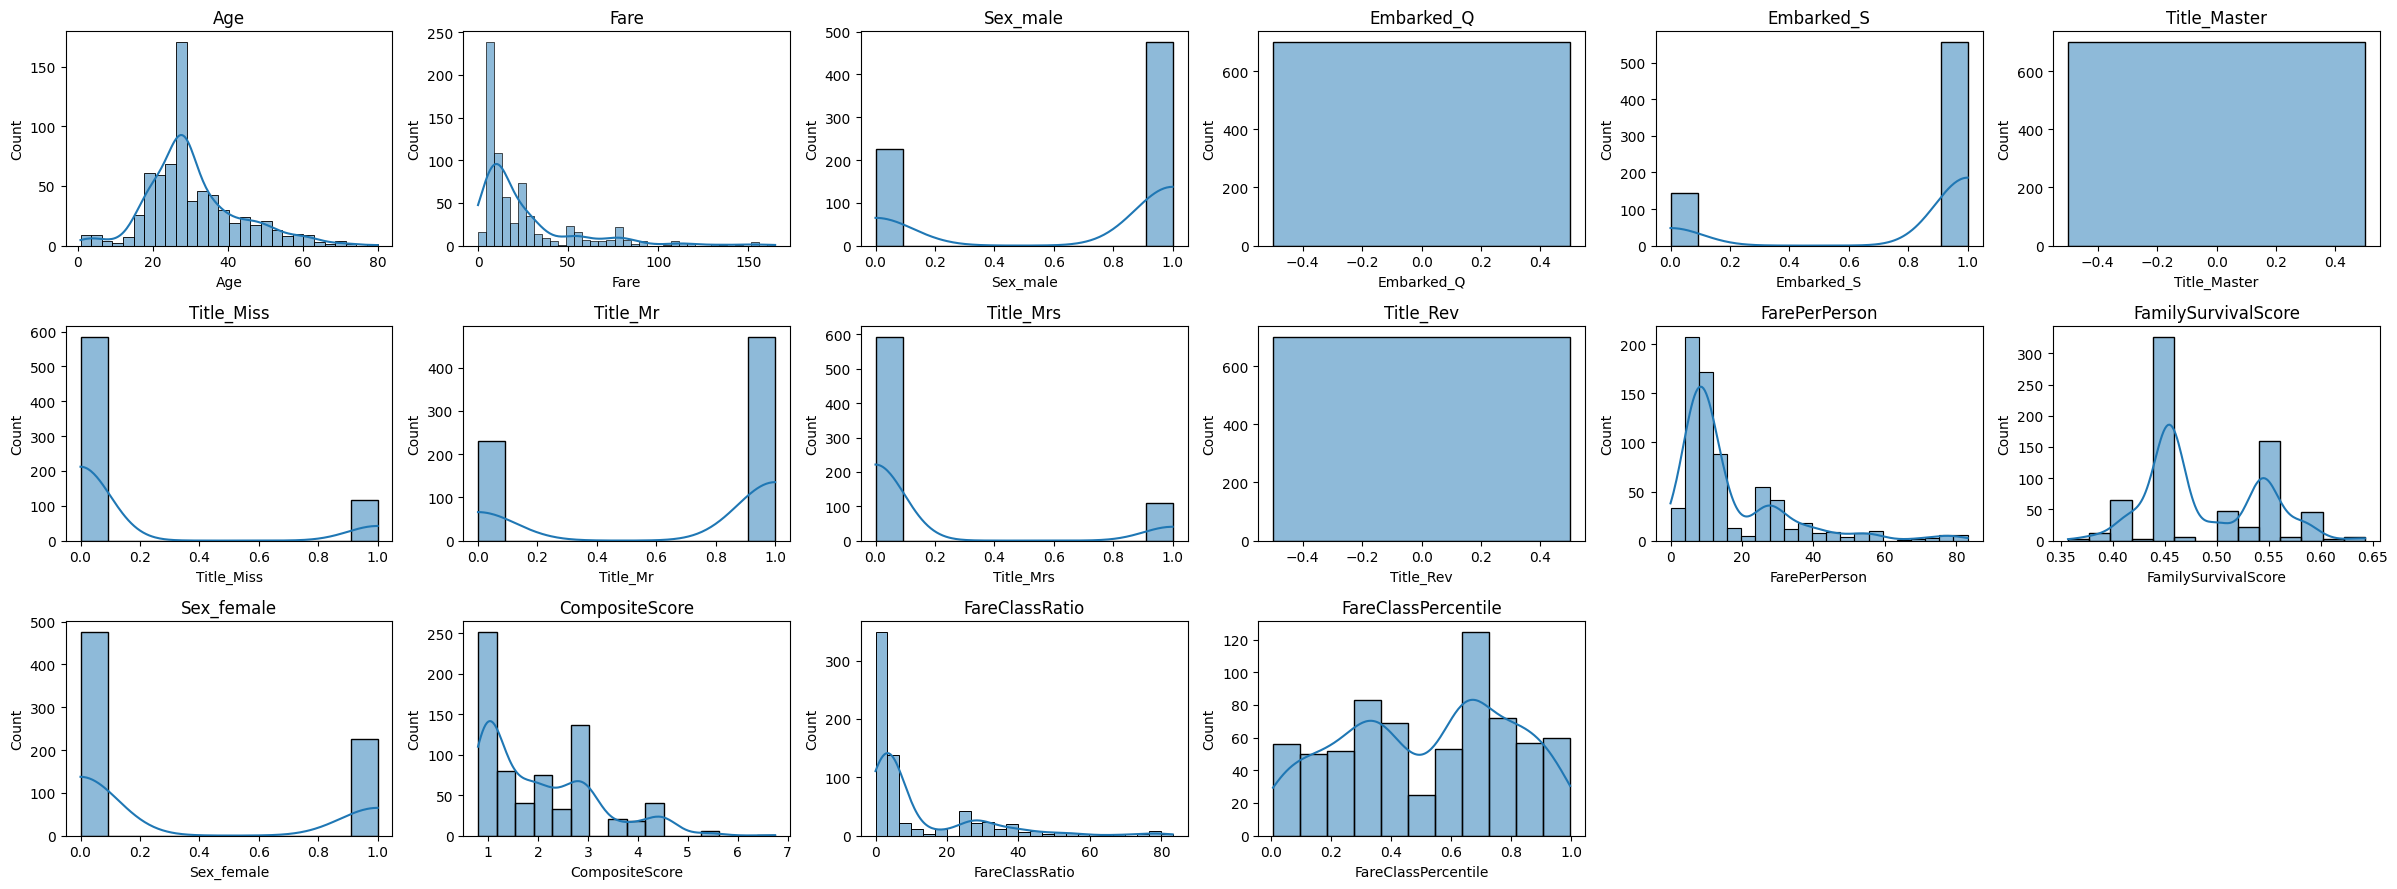

count       mean        std       min        25%  \
Survived             702.0   0.363248   0.481278  0.000000   0.000000   
Pclass               702.0   2.259259   0.836758  1.000000   1.000000   
Age                  702.0  30.740741  12.397522  0.750000  23.000000   
SibSp                702.0   0.303419   0.521125  0.000000   0.000000   
Parch                702.0   0.230769   0.542903  0.000000   0.000000   
Fare                 702.0  25.355964  28.000286  0.000000   7.925000   
Sex_male             702.0   0.679487   0.467006  0.000000   0.000000   
Embarked_Q           702.0   0.000000   0.000000  0.000000   0.000000   
Embarked_S           702.0   0.794872   0.404083  0.000000   1.000000   
Title_Master         702.0   0.000000   0.000000  0.000000   0.000000   
Title_Miss           702.0   0.165242   0.371664  0.000000   0.000000   
Title_Mr             702.0   0.672365   0.469686  0.000000   0.000000   
Title_Mrs            702.0   0.153846   0.361058  0.000000   0.000000   
Title_Rev            702.0   0.000000   0.000000  0.000000   0.000000   
FamilySize           702.0   1.534188   0.836643  1.000000   1.000000   
FarePerPerson        702.0  16.560533  15.554069  0.000000   7.775000   
IsAlone              702.0   0.650997   0.476995  0.000000   0.000000   
FamilySurvivalScore  702.0   0.487062   0.054575  0.357143   0.454545   
Sex_female           702.0   0.320513   0.467006  0.000000   0.000000   
SocialPriority       702.0   1.354701   0.478764  1.000000   1.000000   
CompositeScore       702.0   2.023647   1.119639  0.800000   1.000000   
FareClassRatio       702.0  12.088091  16.453874  0.000000   2.593400   
FareClassPercentile  702.0   0.519830   0.281533  0.005092   0.304481   
AboveClassMedian     702.0   0.534188   0.499185  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  36.000000   80.000000  
SibSp                 0.000000   1.000000    2.000000  
Parch                 0.000000   0.000000    2.000000  
Fare                 13.000000  27.742700  164.866700  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    0.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    0.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    0.000000  
FamilySize            1.000000   2.000000    5.000000  
FarePerPerson         9.225000  25.929200   83.158300  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.800000   2.700000    6.750000  
FareClassRatio        3.327783  17.518067   83.158300  
FareClassPercentile   0.553971   0.775463    0.997283  
AboveClassMedian      1.000000   1.000000    1.000000

In [ ]:
draw_hist(df_lin)
df_lin.describe().T

Пытаемся выровнять

In [ ]:
skew_values = df_lin.skew()
skew_values_hard = skew_values[abs(skew_values) > 0.5]
skew_values_hard.index

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male',
       'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'FamilySize',
       'FarePerPerson', 'IsAlone', 'Sex_female', 'SocialPriority',
       'CompositeScore', 'FareClassRatio', 'Archetype_AveragePassenger',
       'Archetype_Businessman', 'Archetype_PoorChild',
       'Archetype_WealthyMother', 'Archetype_WealthySingleWoman',
       'Archetype_WorkingClassMan'],
      dtype='object')

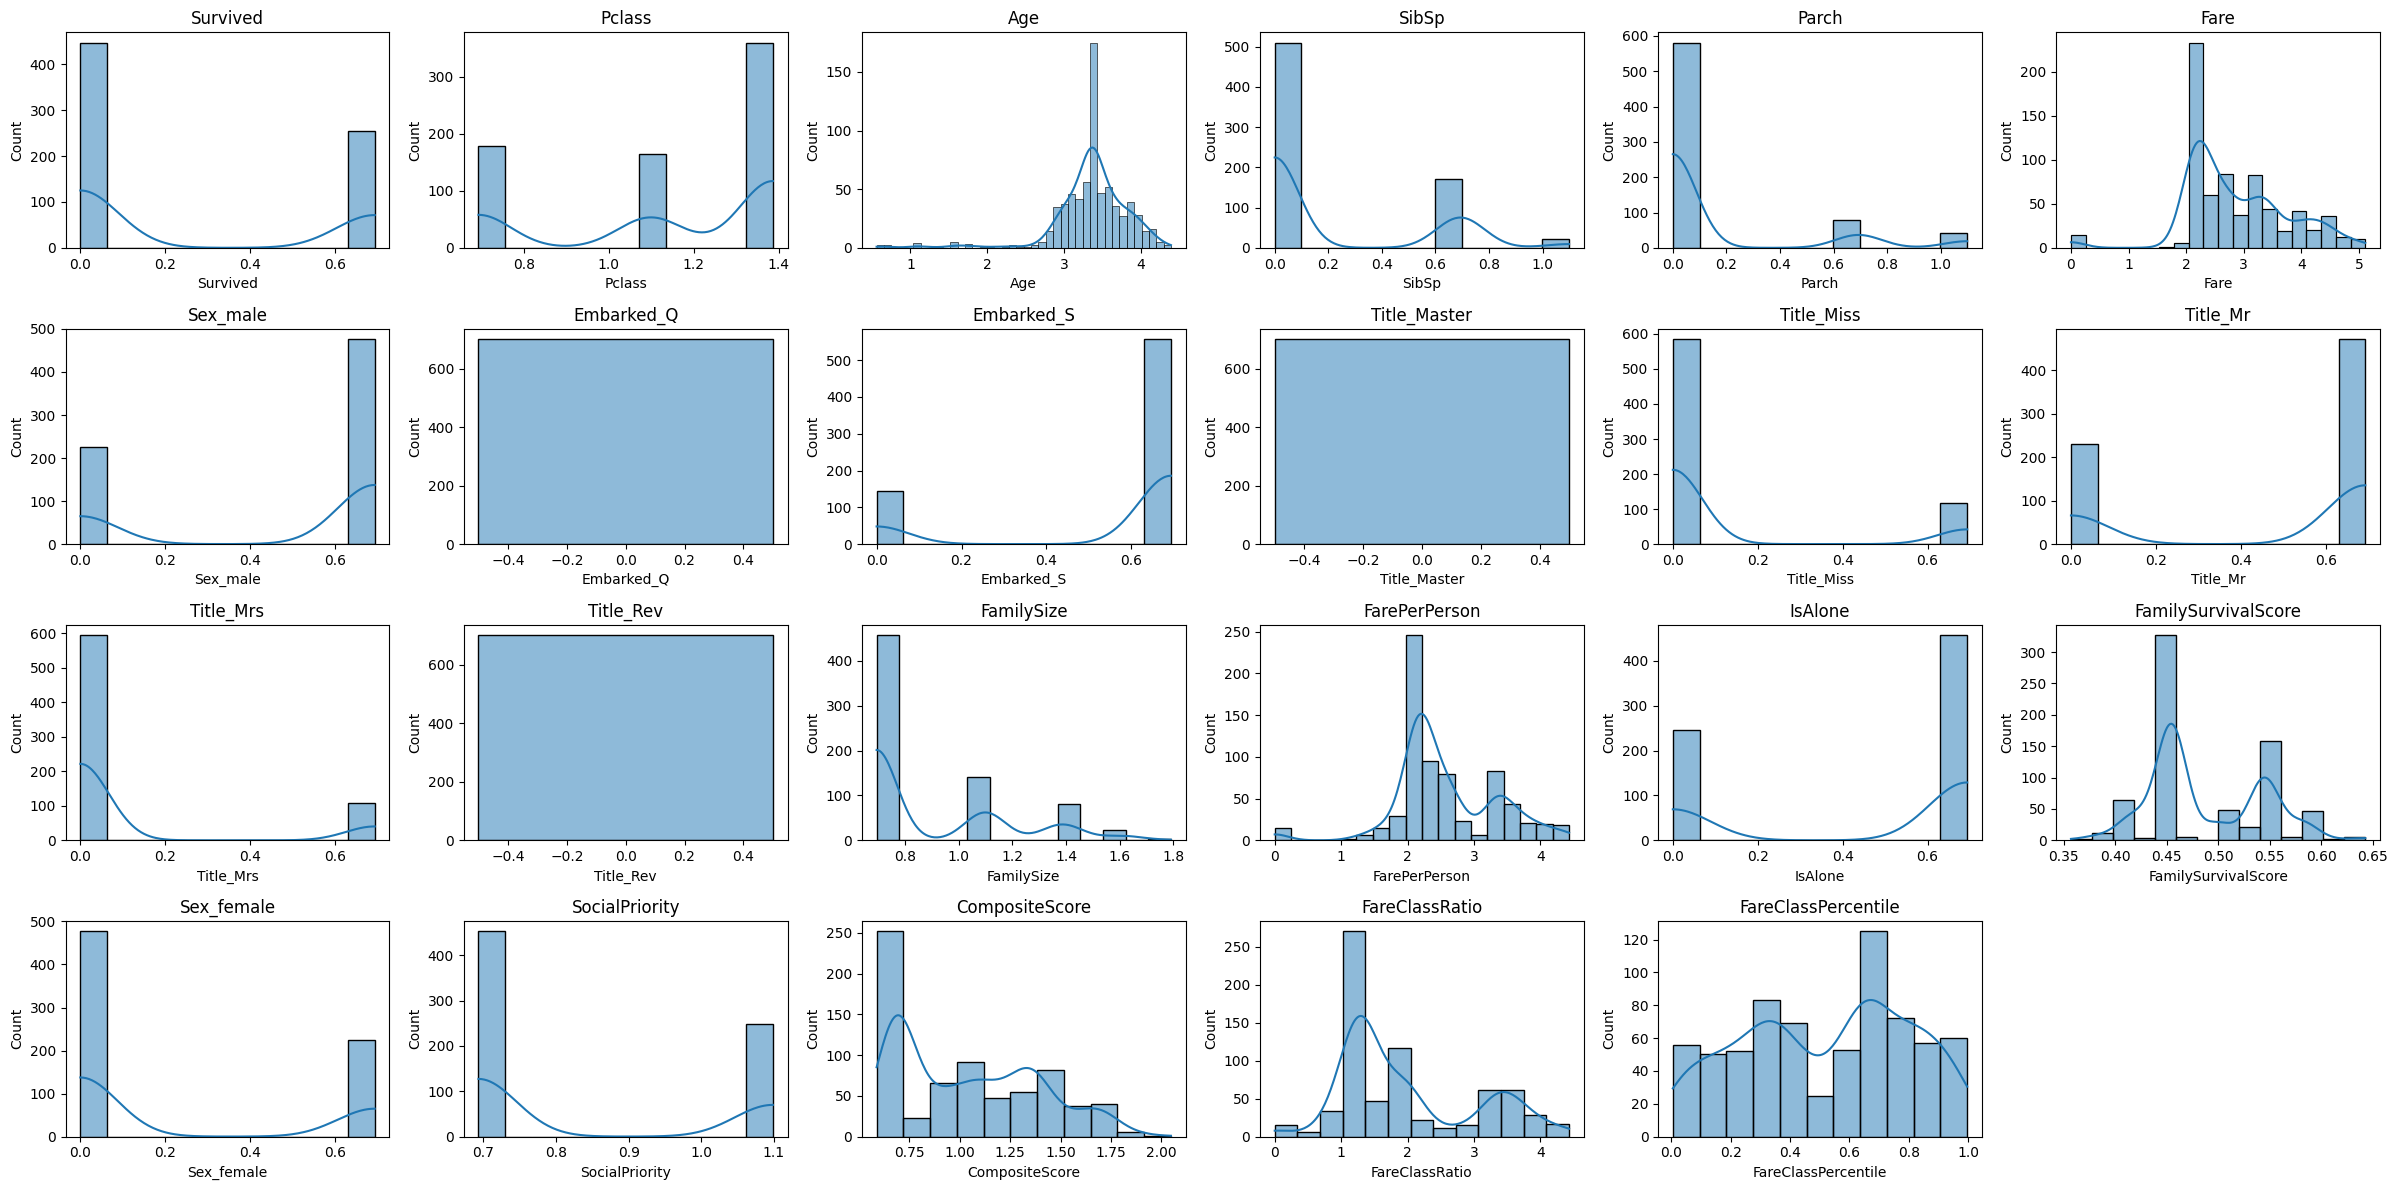

count      mean       std       min       25%  \
Survived                      702.0  0.251784  0.333597  0.000000  0.000000   
Pclass                        702.0  1.143331  0.286784  0.693147  0.693147   
Age                           702.0  3.366089  0.482434  0.559616  3.178054   
SibSp                         702.0  0.201708  0.335579  0.000000  0.000000   
Parch                         702.0  0.143155  0.323882  0.000000  0.000000   
Fare                          702.0  2.858901  0.897703  0.000000  2.188856   
Sex_male                      702.0  0.470985  0.323704  0.000000  0.000000   
Embarked_Q                    702.0  0.000000  0.000000  0.000000  0.000000   
Embarked_S                    702.0  0.550963  0.280089  0.000000  0.693147   
Title_Master                  702.0  0.000000  0.000000  0.000000  0.000000   
Title_Miss                    702.0  0.114537  0.257618  0.000000  0.000000   
Title_Mr                      702.0  0.466048  0.325561  0.000000  0.000000   
Title_Mrs                     702.0  0.106638  0.250267  0.000000  0.000000   
Title_Rev                     702.0  0.000000  0.000000  0.000000  0.000000   
FamilySize                    702.0  0.885423  0.284022  0.693147  0.693147   
FarePerPerson                 702.0  2.566587  0.770033  0.000000  2.171907   
IsAlone                       702.0  0.451237  0.330628  0.000000  0.000000   
FamilySurvivalScore           702.0  0.487062  0.054575  0.357143  0.454545   
Sex_female                    702.0  0.222163  0.323704  0.000000  0.000000   
SocialPriority                702.0  0.836966  0.194122  0.693147  0.693147   
CompositeScore                702.0  1.044400  0.345344  0.587787  0.693147   
FareClassRatio                702.0  1.978287  1.025157  0.000000  1.279098   
FareClassPercentile           702.0  0.519830  0.281533  0.005092  0.304481   
AboveClassMedian              702.0  0.534188  0.499185  0.000000  0.000000   
Archetype_AveragePassenger    702.0  0.491699  0.314941  0.000000  0.000000   
Archetype_Businessman         702.0  0.047424  0.175171  0.000000  0.000000   
Archetype_PoorChild           702.0  0.014816  0.100403  0.000000  0.000000   
Archetype_WealthyMother       702.0  0.022720  0.123474  0.000000  0.000000   
Archetype_WealthySingleWoman  702.0  0.045441  0.171753  0.000000  0.000000   
Archetype_WorkingClassMan     702.0  0.071106  0.210449  0.000000  0.000000   

                                   50%       75%       max  
Survived                      0.000000  0.693147  0.693147  
Pclass                        1.386294  1.386294  1.386294  
Age                           3.367296  3.610918  4.394449  
SibSp                         0.000000  0.693147  1.098612  
Parch                         0.000000  0.000000  1.098612  
Fare                          2.639057  3.358384  5.111184  
Sex_male                      0.693147  0.693147  0.693147  
Embarked_Q                    0.000000  0.000000  0.000000  
Embarked_S                    0.693147  0.693147  0.693147  
Title_Master                  0.000000  0.000000  0.000000  
Title_Miss                    0.000000  0.000000  0.693147  
Title_Mr                      0.693147  0.693147  0.693147  
Title_Mrs                     0.000000  0.000000  0.693147  
Title_Rev                     0.000000  0.000000  0.000000  
FamilySize                    0.693147  1.098612  1.791759  
FarePerPerson                 2.324836  3.293211  4.432700  
IsAlone                       0.693147  0.693147  0.693147  
FamilySurvivalScore           0.454545  0.545455  0.642857  
Sex_female                    0.000000  0.693147  0.693147  
SocialPriority                0.693147  1.098612  1.098612  
CompositeScore                1.029619  1.308333  2.047693  
FareClassRatio                1.465055  2.918747  4.432700  
FareClassPercentile           0.553971  0.775463  0.997283  
AboveClassMedian              1.000000  1.000000  1.000000  
Archetype_AveragePassenger    0.693359  0.693359  0.693

In [ ]:
df_lin = prepare_skew(df = df_lin, columns = list(skew_values_hard.index))
draw_hist(df_lin)
df_lin.describe().T

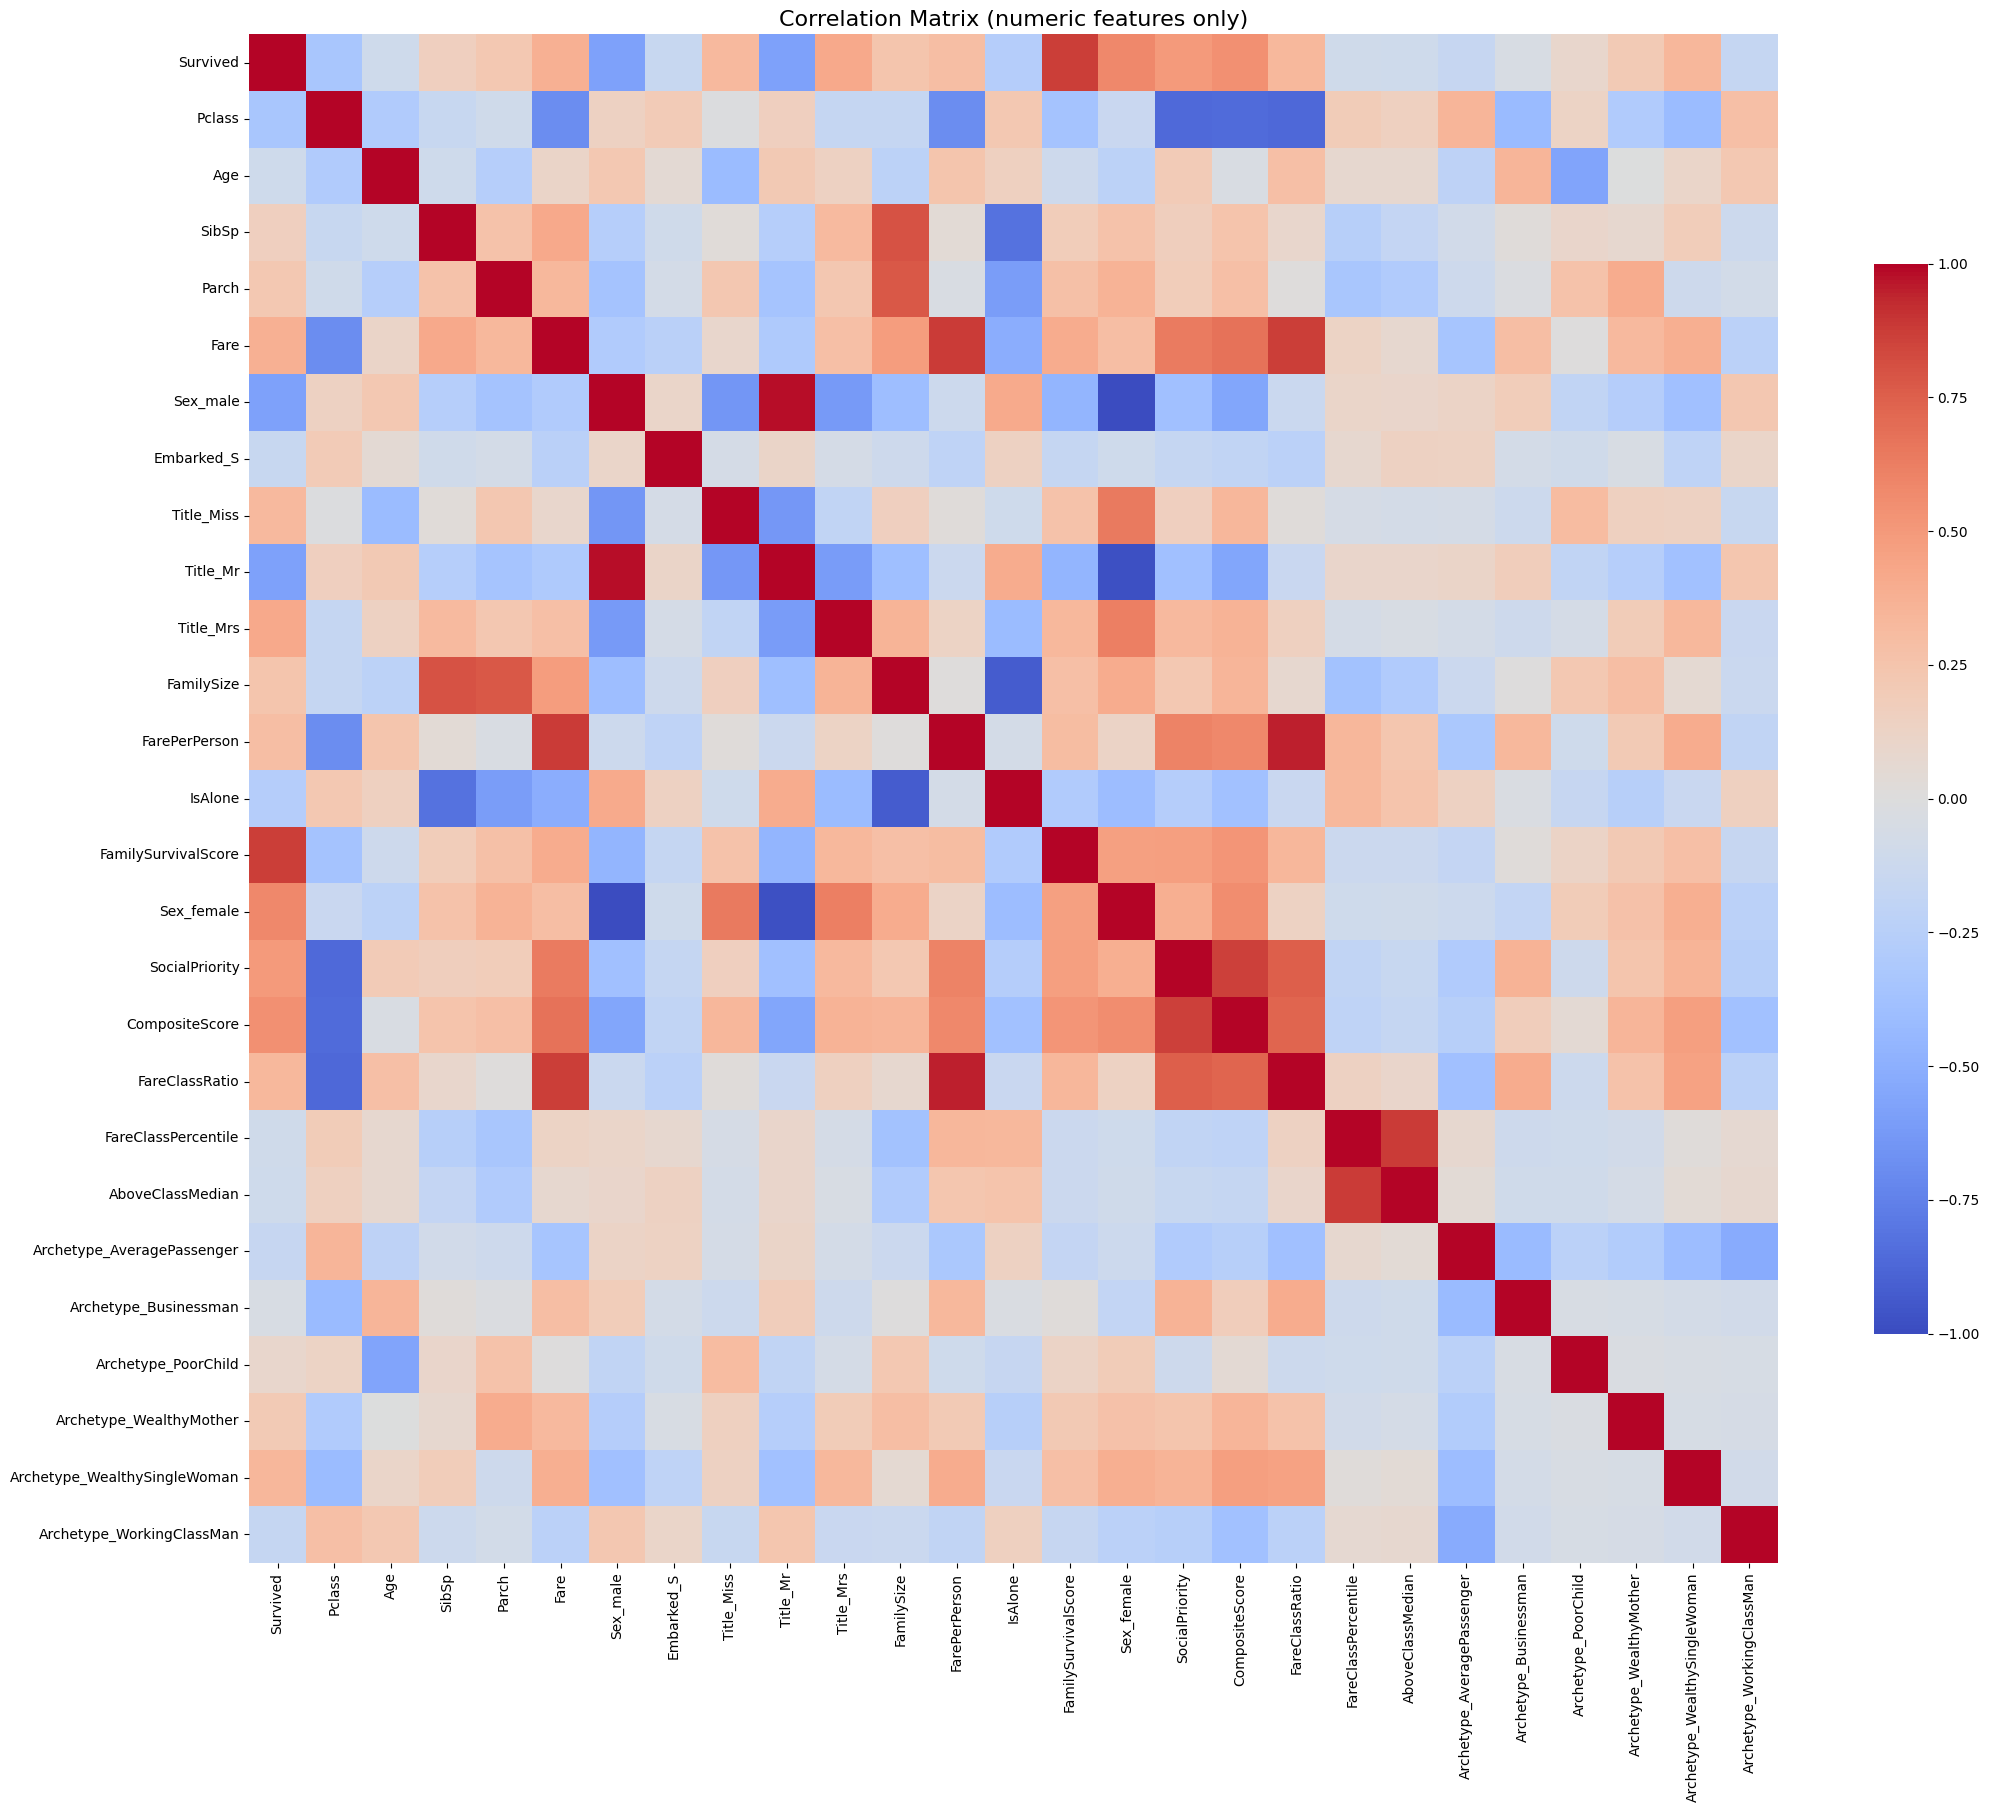

count      mean       std       min       25%  \
Survived                      702.0  0.251784  0.333597  0.000000  0.000000   
Pclass                        702.0  1.143331  0.286784  0.693147  0.693147   
Age                           702.0  3.366089  0.482434  0.559616  3.178054   
SibSp                         702.0  0.201708  0.335579  0.000000  0.000000   
Parch                         702.0  0.143155  0.323882  0.000000  0.000000   
Fare                          702.0  2.858901  0.897703  0.000000  2.188856   
Sex_male                      702.0  0.470985  0.323704  0.000000  0.000000   
Embarked_Q                    702.0  0.000000  0.000000  0.000000  0.000000   
Embarked_S                    702.0  0.550963  0.280089  0.000000  0.693147   
Title_Master                  702.0  0.000000  0.000000  0.000000  0.000000   
Title_Miss                    702.0  0.114537  0.257618  0.000000  0.000000   
Title_Mr                      702.0  0.466048  0.325561  0.000000  0.000000   
Title_Mrs                     702.0  0.106638  0.250267  0.000000  0.000000   
Title_Rev                     702.0  0.000000  0.000000  0.000000  0.000000   
FamilySize                    702.0  0.885423  0.284022  0.693147  0.693147   
FarePerPerson                 702.0  2.566587  0.770033  0.000000  2.171907   
IsAlone                       702.0  0.451237  0.330628  0.000000  0.000000   
FamilySurvivalScore           702.0  0.487062  0.054575  0.357143  0.454545   
Sex_female                    702.0  0.222163  0.323704  0.000000  0.000000   
SocialPriority                702.0  0.836966  0.194122  0.693147  0.693147   
CompositeScore                702.0  1.044400  0.345344  0.587787  0.693147   
FareClassRatio                702.0  1.978287  1.025157  0.000000  1.279098   
FareClassPercentile           702.0  0.519830  0.281533  0.005092  0.304481   
AboveClassMedian              702.0  0.534188  0.499185  0.000000  0.000000   
Archetype_AveragePassenger    702.0  0.491699  0.314941  0.000000  0.000000   
Archetype_Businessman         702.0  0.047424  0.175171  0.000000  0.000000   
Archetype_PoorChild           702.0  0.014816  0.100403  0.000000  0.000000   
Archetype_WealthyMother       702.0  0.022720  0.123474  0.000000  0.000000   
Archetype_WealthySingleWoman  702.0  0.045441  0.171753  0.000000  0.000000   
Archetype_WorkingClassMan     702.0  0.071106  0.210449  0.000000  0.000000   

                                   50%       75%       max  
Survived                      0.000000  0.693147  0.693147  
Pclass                        1.386294  1.386294  1.386294  
Age                           3.367296  3.610918  4.394449  
SibSp                         0.000000  0.693147  1.098612  
Parch                         0.000000  0.000000  1.098612  
Fare                          2.639057  3.358384  5.111184  
Sex_male                      0.693147  0.693147  0.693147  
Embarked_Q                    0.000000  0.000000  0.000000  
Embarked_S                    0.693147  0.693147  0.693147  
Title_Master                  0.000000  0.000000  0.000000  
Title_Miss                    0.000000  0.000000  0.693147  
Title_Mr                      0.693147  0.693147  0.693147  
Title_Mrs                     0.000000  0.000000  0.693147  
Title_Rev                     0.000000  0.000000  0.000000  
FamilySize                    0.693147  1.098612  1.791759  
FarePerPerson                 2.324836  3.293211  4.432700  
IsAlone                       0.693147  0.693147  0.693147  
FamilySurvivalScore           0.454545  0.545455  0.642857  
Sex_female                    0.000000  0.693147  0.693147  
SocialPriority                0.693147  1.098612  1.098612  
CompositeScore                1.029619  1.308333  2.047693  
FareClassRatio                1.465055  2.918747  4.432700  
FareClassPercentile           0.553971  0.775463  0.997283  
AboveClassMedian              1.000000  1.000000  1.000000  
Archetype_AveragePassenger    0.693359  0.693359  0.693

In [ ]:
draw_corr_matrix(df_lin)
df_lin.describe().T

### 2.4. Разделение вида Фичи - Таргет

In [ ]:
df_lin.head(10)

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Survived    Pclass       Age     SibSp     Parch      Fare  Sex_male  \
0   0.000000  1.386294  3.135494  0.693147  0.000000  2.110213  0.693147   
1   0.693147  0.693147  3.663562  0.693147  0.000000  4.280593  0.000000   
2   0.693147  1.386294  3.295837  0.000000  0.000000  2.188856  0.000000   
3   0.693147  0.693147  3.583519  0.693147  0.000000  3.990834  0.000000   
4   0.000000  1.386294  3.583519  0.000000  0.000000  2.202765  0.693147   
6   0.000000  0.693147  4.007333  0.000000  0.000000  3.967694  0.693147   
8   0.693147  1.386294  3.332205  0.000000  1.098612  2.495954  0.000000   
9   0.693147  1.098612  2.708050  0.693147  0.000000  3.436268  0.000000   
10  0.693147  1.386294  1.609438  0.693147  0.693147  2.873565  0.000000   
11  0.693147  0.693147  4.077537  0.000000  0.000000  3.316003  0.000000   

    Embarked_Q  Embarked_S  Title_Master  ...  FareClassRatio  \
0          0.0    0.693147           0.0  ...        0.792238   
1          0.0    0.000000           0.0  ...        3.601186   
2          0.0    0.693147           0.0  ...        1.292441   
3          0.0    0.693147           0.0  ...        3.316003   
4          0.0    0.693147           0.0  ...        1.303818   
6          0.0    0.693147           0.0  ...        3.967694   
8          0.0    0.693147           0.0  ...        0.805151   
9          0.0    0.000000           0.0  ...        2.142146   
10         0.0    0.693147           0.0  ...        1.049266   
11         0.0    0.693147           0.0  ...        3.316003   

    FareClassPercentile  AboveClassMedian  Archetype_AveragePassenger  \
0              0.034623                 0                    0.693359   
1              0.537037                 1                    0.000000   
2              0.715886                 1                    0.693359   
3              0.212963                 0                    0.000000   
4              0.793279                 1                    0.000000   
6              0.745370                 1                    0.000000   
8              0.038697                 0                    0.693359   
9              0.877717                 1                    0.693359   
10             0.180244                 0                    0.000000   
11             0.212963                 0                    0.000000   

    Archetype_Businessman  Archetype_PoorChild  Archetype_RichChild  \
0                0.000000             0.000000                False   
1                0.000000             0.000000                False   
2                0.000000             0.000000                False   
3                0.000000             0.000000                False   
4                0.000000             0.000000                False   
6                0.693359             0.000000                False   
8                0.000000             0.000000                False   
9                0.000000             0.000000                False   
10               0.000000             0.693359                False   
11               0.000000             0.000000                False   

    Archetype_WealthyMother  Archetype_WealthySingleWoman  \
0                       0.0                      0.000000   
1                       0.0                      0.693359   
2                       0.0                      0.000000   
3                       0.0                      0.693359   
4                       0.0                      0.000000   
6                       0.0                      0.000000   
8                       0.0                      0.000000   
9                       0.0                      0.000000   
10                      0.0                      0.000000   
11                      0.0                      0.693359   

    Archetype_WorkingClassMan  
0                    0.000000  
1                    0.000000  
2                    0.000000  
3                    0.000000  
4                    0.693359  
6

Для: `SVM`, `Linear Binary Classification`, `KNN`

In [ ]:
df_lin['Survived'] = (df_lin['Survived'] != 0).astype(np.int64)
y_lin = df_lin['Survived']
X_lin = df_lin.drop('Survived', axis=1)
display(X_lin.head(10), y_lin.head(10))
df_lin.describe().T

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Pclass       Age     SibSp     Parch      Fare  Sex_male  Embarked_Q  \
0   1.386294  3.135494  0.693147  0.000000  2.110213  0.693147         0.0   
1   0.693147  3.663562  0.693147  0.000000  4.280593  0.000000         0.0   
2   1.386294  3.295837  0.000000  0.000000  2.188856  0.000000         0.0   
3   0.693147  3.583519  0.693147  0.000000  3.990834  0.000000         0.0   
4   1.386294  3.583519  0.000000  0.000000  2.202765  0.693147         0.0   
6   0.693147  4.007333  0.000000  0.000000  3.967694  0.693147         0.0   
8   1.386294  3.332205  0.000000  1.098612  2.495954  0.000000         0.0   
9   1.098612  2.708050  0.693147  0.000000  3.436268  0.000000         0.0   
10  1.386294  1.609438  0.693147  0.693147  2.873565  0.000000         0.0   
11  0.693147  4.077537  0.000000  0.000000  3.316003  0.000000         0.0   

    Embarked_S  Title_Master  Title_Miss  ...  FareClassRatio  \
0     0.693147           0.0    0.000000  ...        0.792238   
1     0.000000           0.0    0.000000  ...        3.601186   
2     0.693147           0.0    0.693147  ...        1.292441   
3     0.693147           0.0    0.000000  ...        3.316003   
4     0.693147           0.0    0.000000  ...        1.303818   
6     0.693147           0.0    0.000000  ...        3.967694   
8     0.693147           0.0    0.000000  ...        0.805151   
9     0.000000           0.0    0.000000  ...        2.142146   
10    0.693147           0.0    0.693147  ...        1.049266   
11    0.693147           0.0    0.693147  ...        3.316003   

    FareClassPercentile  AboveClassMedian  Archetype_AveragePassenger  \
0              0.034623                 0                    0.693359   
1              0.537037                 1                    0.000000   
2              0.715886                 1                    0.693359   
3              0.212963                 0                    0.000000   
4              0.793279                 1                    0.000000   
6              0.745370                 1                    0.000000   
8              0.038697                 0                    0.693359   
9              0.877717                 1                    0.693359   
10             0.180244                 0                    0.000000   
11             0.212963                 0                    0.000000   

    Archetype_Businessman  Archetype_PoorChild  Archetype_RichChild  \
0                0.000000             0.000000                False   
1                0.000000             0.000000                False   
2                0.000000             0.000000                False   
3                0.000000             0.000000                False   
4                0.000000             0.000000                False   
6                0.693359             0.000000                False   
8                0.000000             0.000000                False   
9                0.000000             0.000000                False   
10               0.000000             0.693359                False   
11               0.000000             0.000000                False   

    Archetype_WealthyMother  Archetype_WealthySingleWoman  \
0                       0.0                      0.000000   
1                       0.0                      0.693359   
2                       0.0                      0.000000   
3                       0.0                      0.693359   
4                       0.0                      0.000000   
6                       0.0                      0.000000   
8                       0.0                      0.000000   
9                       0.0                      0.000000   
10                      0.0                      0.000000   
11                      0.0                      0.693359   

    Archetype_WorkingClassMan  
0                    0.000000  
1                    0.000000  
2                    0.000000  
3                    0.000000  
4            

0     0
1     1
2     1
3     1
4     0
6     0
8     1
9     1
10    1
11    1
Name: Survived, dtype: int64

count      mean       std       min       25%  \
Survived                      702.0  0.363248  0.481278  0.000000  0.000000   
Pclass                        702.0  1.143331  0.286784  0.693147  0.693147   
Age                           702.0  3.366089  0.482434  0.559616  3.178054   
SibSp                         702.0  0.201708  0.335579  0.000000  0.000000   
Parch                         702.0  0.143155  0.323882  0.000000  0.000000   
Fare                          702.0  2.858901  0.897703  0.000000  2.188856   
Sex_male                      702.0  0.470985  0.323704  0.000000  0.000000   
Embarked_Q                    702.0  0.000000  0.000000  0.000000  0.000000   
Embarked_S                    702.0  0.550963  0.280089  0.000000  0.693147   
Title_Master                  702.0  0.000000  0.000000  0.000000  0.000000   
Title_Miss                    702.0  0.114537  0.257618  0.000000  0.000000   
Title_Mr                      702.0  0.466048  0.325561  0.000000  0.000000   
Title_Mrs                     702.0  0.106638  0.250267  0.000000  0.000000   
Title_Rev                     702.0  0.000000  0.000000  0.000000  0.000000   
FamilySize                    702.0  0.885423  0.284022  0.693147  0.693147   
FarePerPerson                 702.0  2.566587  0.770033  0.000000  2.171907   
IsAlone                       702.0  0.451237  0.330628  0.000000  0.000000   
FamilySurvivalScore           702.0  0.487062  0.054575  0.357143  0.454545   
Sex_female                    702.0  0.222163  0.323704  0.000000  0.000000   
SocialPriority                702.0  0.836966  0.194122  0.693147  0.693147   
CompositeScore                702.0  1.044400  0.345344  0.587787  0.693147   
FareClassRatio                702.0  1.978287  1.025157  0.000000  1.279098   
FareClassPercentile           702.0  0.519830  0.281533  0.005092  0.304481   
AboveClassMedian              702.0  0.534188  0.499185  0.000000  0.000000   
Archetype_AveragePassenger    702.0  0.491699  0.314941  0.000000  0.000000   
Archetype_Businessman         702.0  0.047424  0.175171  0.000000  0.000000   
Archetype_PoorChild           702.0  0.014816  0.100403  0.000000  0.000000   
Archetype_WealthyMother       702.0  0.022720  0.123474  0.000000  0.000000   
Archetype_WealthySingleWoman  702.0  0.045441  0.171753  0.000000  0.000000   
Archetype_WorkingClassMan     702.0  0.071106  0.210449  0.000000  0.000000   

                                   50%       75%       max  
Survived                      0.000000  1.000000  1.000000  
Pclass                        1.386294  1.386294  1.386294  
Age                           3.367296  3.610918  4.394449  
SibSp                         0.000000  0.693147  1.098612  
Parch                         0.000000  0.000000  1.098612  
Fare                          2.639057  3.358384  5.111184  
Sex_male                      0.693147  0.693147  0.693147  
Embarked_Q                    0.000000  0.000000  0.000000  
Embarked_S                    0.693147  0.693147  0.693147  
Title_Master                  0.000000  0.000000  0.000000  
Title_Miss                    0.000000  0.000000  0.693147  
Title_Mr                      0.693147  0.693147  0.693147  
Title_Mrs                     0.000000  0.000000  0.693147  
Title_Rev                     0.000000  0.000000  0.000000  
FamilySize                    0.693147  1.098612  1.791759  
FarePerPerson                 2.324836  3.293211  4.432700  
IsAlone                       0.693147  0.693147  0.693147  
FamilySurvivalScore           0.454545  0.545455  0.642857  
Sex_female                    0.000000  0.693147  0.693147  
SocialPriority                0.693147  1.098612  1.098612  
CompositeScore                1.029619  1.308333  2.047693  
FareClassRatio                1.465055  2.918747  4.432700  
FareClassPercentile           0.553971  0.775463  0.997283  
AboveClassMedian              1.000000  1.000000  1.000000  
Archetype_AveragePassenger    0.693359  0.693359  0.693

Для: `Desicion Tree`, `Random Forest` и `Gradient's Boosting Methods`

In [ ]:
df['Survived'] = df['Survived'].astype(np.int64)
y = df['Survived']
X = df.drop('Survived', axis=1)
display(X.head(3), y.head(3))
df.describe().T

Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S  \
0       3  22.0      1      0   7.2500       1.0         0.0         1.0   
1       1  38.0      1      0  71.2833       0.0         0.0         0.0   
2       3  26.0      0      0   7.9250       0.0         0.0         1.0   

   Title_Master  Title_Miss  ...  FareClassRatio  FareClassPercentile  \
0           0.0         0.0  ...        1.208333             0.034623   
1           0.0         0.0  ...       35.641650             0.537037   
2           0.0         1.0  ...        2.641667             0.715886   

   AboveClassMedian  Archetype_AveragePassenger  Archetype_Businessman  \
0                 0                        True                  False   
1                 1                       False                  False   
2                 1                        True                  False   

   Archetype_PoorChild  Archetype_RichChild  Archetype_WealthyMother  \
0                False                False                    False   
1                False                False                    False   
2                False                False                    False   

   Archetype_WealthySingleWoman  Archetype_WorkingClassMan  
0                         False                      False  
1                          True                      False  
2                         False                      False  

[3 rows x 30 columns]

0    0
1    1
2    1
Name: Survived, dtype: int64

count       mean        std       min        25%  \
Survived             891.0   0.383838   0.486592  0.000000   0.000000   
Pclass               891.0   2.308642   0.836071  1.000000   2.000000   
Age                  891.0  29.361582  13.019697  0.420000  22.000000   
SibSp                891.0   0.523008   1.102743  0.000000   0.000000   
Parch                891.0   0.381594   0.806057  0.000000   0.000000   
Fare                 891.0  32.204208  49.693429  0.000000   7.910400   
Sex_male             891.0   0.647587   0.477990  0.000000   0.000000   
Embarked_Q           891.0   0.086420   0.281141  0.000000   0.000000   
Embarked_S           891.0   0.725028   0.446751  0.000000   0.000000   
Title_Master         891.0   0.044893   0.207186  0.000000   0.000000   
Title_Miss           891.0   0.208754   0.406647  0.000000   0.000000   
Title_Mr             891.0   0.589226   0.492251  0.000000   0.000000   
Title_Mrs            891.0   0.142536   0.349796  0.000000   0.000000   
Title_Rev            891.0   0.006734   0.081830  0.000000   0.000000   
FamilySize           891.0   1.904602   1.613459  1.000000   1.000000   
FarePerPerson        891.0  19.916375  35.841257  0.000000   7.250000   
IsAlone              891.0   0.602694   0.489615  0.000000   0.000000   
FamilySurvivalScore  891.0   0.482805   0.066112  0.294118   0.454545   
Sex_female           891.0   0.352413   0.477990  0.000000   0.000000   
SocialPriority       891.0   1.327722   0.469646  1.000000   1.000000   
CompositeScore       891.0   2.028002   1.134638  0.800000   1.000000   
FareClassRatio       891.0  15.631329  36.747132  0.000000   2.502767   
FareClassPercentile  891.0   0.501684   0.287514  0.005092   0.250000   
AboveClassMedian     891.0   0.480359   0.499895  0.000000   0.000000   

                           50%        75%         max  
Survived              0.000000   1.000000    1.000000  
Pclass                3.000000   3.000000    3.000000  
Age                  28.000000  35.000000   80.000000  
SibSp                 0.000000   1.000000    8.000000  
Parch                 0.000000   0.000000    6.000000  
Fare                 14.454200  31.000000  512.329200  
Sex_male              1.000000   1.000000    1.000000  
Embarked_Q            0.000000   0.000000    1.000000  
Embarked_S            1.000000   1.000000    1.000000  
Title_Master          0.000000   0.000000    1.000000  
Title_Miss            0.000000   0.000000    1.000000  
Title_Mr              1.000000   1.000000    1.000000  
Title_Mrs             0.000000   0.000000    1.000000  
Title_Rev             0.000000   0.000000    1.000000  
FamilySize            1.000000   2.000000   11.000000  
FarePerPerson         8.300000  23.666667  512.329200  
IsAlone               1.000000   1.000000    1.000000  
FamilySurvivalScore   0.454545   0.545455    0.642857  
Sex_female            0.000000   1.000000    1.000000  
SocialPriority        1.000000   2.000000    2.000000  
CompositeScore        1.500000   2.700000    6.750000  
FareClassRatio        2.887500  13.000000  512.329200  
FareClassPercentile   0.498982   0.734654    0.997685  
AboveClassMedian      0.000000   1.000000    1.000000

## 3. Создание моделей

### 3.0. Создание `SVM`, `Linear Binary Classification`, `KNN`

#### Support Vector Machine

[Почитать 1](https://scikit-learn.org/stable/modules/svm.html)

[Почитать 2](https://t.me/devwhoami/179)

Метод опорных векторов (Support Vector Machine, **SVM**) — это мощный и популярный алгоритм **линейной** (и нелинейной) **классификации**.

Основная идея:

1.  **Разделяющая гиперплоскость**: SVM находит оптимальную гиперплоскость (линию в 2D, плоскость в 3D), которая **наилучшим образом разделяет** классы в вашем наборе данных.
2.  **Максимизация зазора (Margin)**: "Наилучшим образом" означает, что гиперплоскость должна находиться на **максимальном расстоянии** от ближайших точек каждого класса. Это расстояние называется **зазором (margin)**.
3.  **Опорные векторы (Support Vectors)**: Только те точки данных, которые находятся **ближе всего** к гиперплоскости и определяют ширину зазора, называются **опорными векторами**. Эти точки имеют решающее значение; если их удалить, положение гиперплоскости может измениться.
4.  **Ядерный трюк (Kernel Trick)**: Для **нелинейно** разделимых данных SVM использует так называемый **ядерный трюк**. Он неявно проецирует данные в пространство более высокой размерности, где классы становятся линейно разделимыми, и находит там оптимальную гиперплоскость.

**Кратко**: SVM строит **широчайший возможный "коридор"** между классами, опираясь только на самые сложные (граничные) точки — опорные векторы.

In [ ]:
from sklearn.svm import SVC

model_svm = SVC(
    C=1.0,           # Параметр регуляризации. Чем меньше C, тем шире зазор, тем больше ошибок допускается (сильнее регуляризация).
                     # Варианты: 0.1, 1, 10, 100.

    kernel='rbf',    # Тип ядра. Определяет, как данные будут проецироваться в пространство более высокой размерности.
                     # Варианты: 'linear' (линейный классификатор), 'poly' (полиномиальный),
                     # 'rbf' (Радиальная базисная функция - наиболее часто используется для нелинейных задач), 'sigmoid'.

    gamma='scale',   # Коэффициент ядра (для 'rbf', 'poly', 'sigmoid'). Определяет "влияние" одного обучающего примера.
                     # Варианты: 'scale' (1 / (n_features * X.var())) или 'auto' (1 / n_features) - рекомендуются по умолчанию.
                     # Или: небольшие значения (0.01, 0.1) для широкого влияния; большие значения (1, 10) для узкого влияния.

    degree=3,        # Степень полинома (для 'poly' ядра). Игнорируется для других ядер.
                     # Варианты: 2, 3, 4.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    probability=False # Включает оценку вероятности классов (медленнее, но иногда нужно).
                      # Варианты: True (если нужны предсказанные вероятности), False (по умолчанию, если нужна только классификация).
)


#### Logistic Regression

**Логистическая регрессия — краткое пояснение:**

Логистическая регрессия — это метод машинного обучения, используемый для решения задач **классификации**, то есть когда нужно предсказать, к какому классу принадлежит объект (например, «да/нет», «0/1»).

В отличие от линейной регрессии, логистическая регрессия предсказывает **вероятность принадлежности** объекта к определённому классу. Для этого используется **логистическая (сигмоидная) функция**, которая преобразует линейную комбинацию признаков в значение от 0 до 1.

Основные шаги:

1. Строится линейная модель:
    $$z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$$
2. К результату применяется сигмоида:
   $$p = \frac{1}{1 + e^{-z}}$$
3. Если ($p > 0.5$), то объект относят к классу 1, иначе — к классу 0.

Модель обучается с помощью **максимизации правдоподобия** (обычно через метод градиентного спуска).


In [ ]:
from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(
    penalty='l2',        # Тип регуляризации, добавляемой для предотвращения переобучения.
                         # 'l2' — стандартная (ридж-регуляризация), 'l1' — лассо-регуляризация (зануляет некоторые коэффициенты).
                         # Варианты: 'l1', 'l2', 'elasticnet', 'none'.

    C=1.0,               # Обратный коэффициент силы регуляризации.
                         # Чем меньше C — тем сильнее регуляризация (жестче штраф за большие коэффициенты).
                         # Варианты: 0.01, 0.1, 1, 10, 100.

    solver='lbfgs',      # Алгоритм оптимизации для нахождения весов модели.
                         # 'lbfgs' — универсальный и быстрый (подходит для малых и средних наборов данных).
                         # Другие варианты: 'liblinear' (поддерживает L1), 'saga' (работает с большими данными и L1/L2), 'newton-cg'.

    max_iter=100,        # Максимальное число итераций для сходимости алгоритма.
                         # Если обучение не сходится — увеличить, например до 500.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов (фиксирует начальные веса).

    fit_intercept=True,  # Добавляет свободный коэффициент (смещение) в модель.
                         # Обычно True, чтобы учитывать среднее значение признаков.

    n_jobs=None          # Количество потоков для параллельных вычислений.
                         # None — одно ядро, -1 — использовать все доступные ядра процессора.
)


#### K-Nearest Neighbors (KNN)

**Метод k-ближайших соседей — краткое пояснение:**

KNN (*k-nearest neighbors*) — это простой и интуитивный метод машинного обучения, применяемый для задач **классификации** и **регрессии**.
Он не строит явной модели — вместо этого принимает решение, основываясь на **схожести объектов** в пространстве признаков.

Идея метода:
Для нового объекта алгоритм ищет **k ближайших соседей** из обучающей выборки (по выбранной метрике расстояния) и определяет класс по **голосованию** этих соседей.

Основные шаги:

1. Выбирается число соседей $k$ — например, 3 или 5.
2. Для нового объекта вычисляются расстояния до всех объектов обучающей выборки.
3. Определяются $k$ ближайших точек.
4. Класс объекта определяется по большинству классов среди соседей.

Метод KNN **не имеет этапа обучения**, так как просто запоминает обучающие данные.
Основной параметр, влияющий на качество модели — это число соседей $k$:

* Малое $k$ делает модель чувствительной к шуму.
* Большое $k$ сглаживает границы между классами.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(
    n_neighbors=5,      # Количество ближайших соседей (k).
                        # Малое значение делает модель чувствительной к шуму, большое — сглаживает предсказания.
                        # Варианты: 3, 5, 7, 9 и т.д.

    weights='uniform',  # Веса соседей при голосовании.
                        # 'uniform' — все соседи равны,
                        # 'distance' — соседи ближе к объекту имеют больший вес.

    metric='minkowski', # Метрика расстояния.
                        # По умолчанию 'minkowski' с p=2 соответствует евклидову расстоянию.
                        # Варианты: 'euclidean', 'manhattan', 'chebyshev', 'minkowski'.

    p=2,                # Степень метрики Минковского (p=1 — манхэттен, p=2 — евклид).
                        # Меняется только если выбран 'minkowski'.

    algorithm='auto',   # Алгоритм поиска ближайших соседей.
                        # 'auto' выбирает оптимальный метод (ball_tree, kd_tree, brute) в зависимости от данных.

    n_jobs=None         # Количество потоков для вычислений.
                        # None — одно ядро, -1 — использовать все доступные ядра процессора.
)

### 3.1. Создание `Desicion Tree`, `Random Forest`

#### Decision Tree Classifier (Дерево решений)

**Дерево решений — краткое пояснение:**

Дерево решений — это алгоритм **классификации и регрессии**, который принимает решения, разбивая данные по признакам в виде **дерева с узлами и ветвями**.
Каждый узел дерева соответствует условию на значение признака (например, «возраст > 30?»), а листья — это **предсказанные классы**.

Идея метода:
Алгоритм рекурсивно делит выборку на подмножества так, чтобы в каждом из них объекты как можно больше принадлежали одному классу.
Критерием “хорошего разбиения” служат меры **чистоты узла** — например, *Gini* или *энтропия*.

Основные шаги:

1. Выбирается признак и порог, которые лучше всего разделяют данные по целевой переменной.
2. Создаются новые ветви для каждого значения или диапазона признака.
3. Процесс повторяется до тех пор, пока не достигнуты условия остановки (например, максимальная глубина).
4. Листовые узлы содержат итоговые классы.

Преимущества:

* Простая интерпретация (можно визуализировать дерево).
* Не требует масштабирования данных.

Недостатки:

* Склонно к **переобучению**, особенно при большой глубине дерева.
* Может быть нестабильным (небольшие изменения данных → другое дерево).

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(
    criterion='gini',       # Критерий качества разбиения.
                            # 'gini' — индекс Джини (по умолчанию),
                            # 'entropy' — энтропия (информационный выигрыш),
                            # 'log_loss' — основан на логарифмической потере.

    splitter='best',        # Стратегия выбора признака для разбиения.
                            # 'best' — выбирает наилучшее разбиение,
                            # 'random' — выбирает случайный признак (для ускорения и разнообразия).

    max_depth=None,         # Максимальная глубина дерева.
                            # None — без ограничения (может привести к переобучению).
                            # Примеры: 3, 5, 10.

    min_samples_split=2,    # Минимальное число образцов для разбиения узла.
                            # Увеличение этого параметра уменьшает переобучение.

    min_samples_leaf=1,     # Минимальное количество образцов в листе.
                            # Увеличение значения делает дерево более “гладким”.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    max_features=None,      # Количество признаков, рассматриваемых при каждом разбиении.
                            # None — использовать все признаки.

    class_weight=None       # Веса классов для компенсации дисбаланса.
                            # Например: 'balanced' — автоматически выравнивает частоты классов.
)

#### Random Forest Classifier (Случайный лес)

**Случайный лес — краткое пояснение:**

Случайный лес — это ансамблевый метод машинного обучения, основанный на **множестве деревьев решений**, каждое из которых обучается независимо на случайных подвыборках данных и признаков.
Модель объединяет результаты всех деревьев (обычно **путём голосования**) для получения более устойчивого и точного предсказания.

Идея метода:
Вместо одного дерева (которое может переобучаться), алгоритм строит **множество случайных деревьев**, каждое из которых "смотрит" на разные части данных.
В результате снижается разброс модели и повышается обобщающая способность.

Основные шаги:

1. Из исходных данных случайно выбираются подмножества объектов (методом *bootstrap*).
2. Для каждого дерева случайно выбирается подмножество признаков.
3. Каждое дерево строится независимо, как обычное дерево решений.
4. При классификации итоговый класс выбирается **по большинству голосов деревьев**.

Преимущества:

* Устойчив к переобучению.
* Хорошо работает “из коробки” без сильной настройки параметров.
* Может оценивать важность признаков (*feature importance*).

Недостатки:

* Менее интерпретируем, чем одно дерево.
* Медленнее при очень больших данных.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(
    n_estimators=100,        # Количество деревьев в лесе.
                             # Большее число деревьев обычно улучшает качество, но увеличивает время обучения.
                             # Варианты: 50, 100, 200, 500.

    criterion='gini',        # Критерий качества разбиений для каждого дерева.
                             # 'gini' — индекс Джини (по умолчанию),
                             # 'entropy' — энтропия.

    max_depth=None,          # Максимальная глубина каждого дерева.
                             # None — без ограничения (может переобучаться).
                             # Примеры: 5, 10, 20.

    min_samples_split=2,     # Минимальное количество образцов для разбиения узла.
                             # Увеличение уменьшает переобучение.

    min_samples_leaf=1,      # Минимальное количество образцов в листе.
                             # Увеличение делает модель более "плавной".

    max_features='sqrt',     # Количество признаков, используемых при поиске лучшего разбиения.
                             # 'sqrt' — стандарт для классификации (корень из числа признаков).
                             # 'log2' — логарифм по основанию 2, или число/доля признаков.

    bootstrap=True,          # Использовать ли bootstrap-подвыборки при обучении деревьев.
                             # True — стандартный вариант, False — использовать все данные.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    n_jobs=None,             # Количество потоков.
                             # None — одно ядро, -1 — использовать все ядра процессора.

    class_weight=None        # Веса классов для компенсации дисбаланса.
                             # 'balanced' — автоматически выравнивает частоты классов.
)

### 3.2. Создание `Gradient's Boosting Methods`

#### Gradient Boosting Classifier (Градиентный бустинг)

**Градиентный бустинг — краткое пояснение:**

Градиентный бустинг — это **ансамблевый метод**, который строит **последовательность слабых моделей** (обычно небольших деревьев решений), где каждая новая модель **исправляет ошибки предыдущих**.
В отличие от случайного леса, где деревья строятся **независимо**, в бустинге каждое следующее дерево обучается **на остатках (ошибках)** предыдущих.

Идея метода:

1. Обучается первое дерево, которое делает начальные предсказания.
2. Вычисляются ошибки (разница между предсказанными и истинными значениями).
3. Следующее дерево обучается предсказывать эти ошибки.
4. Итоговое предсказание — сумма (или взвешенная комбинация) всех деревьев.

Благодаря этому модель постепенно **минимизирует функцию потерь** и достигает высокой точности.

Преимущества:

* Очень высокая точность при правильной настройке.
* Хорошо работает с числовыми и категориальными признаками.
* Можно контролировать переобучение через глубину деревьев и скорость обучения.

Недостатки:

* Медленнее в обучении, чем случайный лес.
* Требует подбора гиперпараметров.
* Может переобучаться при слишком большом количестве деревьев.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(
    loss='log_loss',        # Функция потерь, которую минимизирует алгоритм.
                            # 'log_loss' — для классификации (по умолчанию),
                            # 'exponential' — аналог AdaBoost.

    learning_rate=0.1,      # Скорость обучения (вклад каждого дерева в общий результат).
                            # Меньшие значения (0.01–0.1) делают обучение стабильнее, но требуют больше деревьев.

    n_estimators=100,       # Количество слабых моделей (деревьев).
                            # Большее число может повысить точность, но и риск переобучения.

    subsample=1.0,          # Доля выборки, используемая для обучения каждого дерева.
                            # Значения < 1.0 добавляют стохастичность (ускоряют и уменьшают переобучение).

    criterion='friedman_mse', # Критерий качества разбиений.
                              # 'friedman_mse' — оптимальный для бустинга,
                              # 'squared_error' и 'mse' — классические варианты.

    min_samples_split=2,    # Минимальное число образцов для разбиения узла.

    min_samples_leaf=1,     # Минимальное число образцов в листе.

    max_depth=3,            # Максимальная глубина базовых деревьев.
                            # Малые значения (3–5) обычно предотвращают переобучение.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    max_features=None,      # Количество признаков при разбиении.
                            # None — использовать все признаки, 'sqrt' или 'log2' — случайное подмножество.

    verbose=0               # Если >0, выводит процесс обучения (для отладки).
)


#### XGBoost (Extreme Gradient Boosting)

**XGBoost — краткое пояснение:**

**XGBoost (Extreme Gradient Boosting)** — это усовершенствованная реализация градиентного бустинга, созданная для **скорости, эффективности и точности**.
Он работает по тем же принципам, что и обычный **Gradient Boosting**, но добавляет оптимизации на уровне вычислений, регуляризации и обработки пропусков.

XGBoost строит ансамбль из множества **деревьев решений**, каждое из которых **исправляет ошибки предыдущих**, минимизируя функцию потерь с помощью **градиентного спуска**.

Особенности XGBoost:

* Использует **L1 и L2 регуляризацию**, что снижает переобучение.
* Поддерживает **параллельное обучение** деревьев.
* Эффективно работает с **пропущенными данными**.
* Может применяться не только для классификации, но и для регрессии, ранжирования и др.

Преимущества:

* Очень высокая точность.
* Быстрее классического `GradientBoostingClassifier`.
* Гибкость — множество гиперпараметров для точной настройки.

Недостатки:

* Сложнее в настройке.
* Требует больше памяти и вычислительных ресурсов.


In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=100,        # Количество деревьев (итераций бустинга).
                            # Увеличение может повысить качество, но и риск переобучения.

    learning_rate=0.1,       # Скорость обучения (вклад каждого дерева).
                            # Меньшие значения (0.01–0.1) требуют большего числа деревьев.

    max_depth=3,             # Максимальная глубина деревьев.
                            # Контролирует сложность модели — большее значение → выше риск переобучения.

    subsample=1.0,           # Доля выборки, используемая при построении каждого дерева.
                            # Меньше 1.0 → случайность и снижение переобучения.

    colsample_bytree=1.0,    # Доля признаков, выбираемых при построении каждого дерева.
                            # Обычно 0.8–1.0 — для ускорения и устойчивости.

    gamma=0,                 # Минимальное улучшение функции потерь для разбиения узла.
                            # Увеличение gamma делает модель более консервативной.

    reg_alpha=0,             # L1-регуляризация (на коэффициенты).
                            # Увеличение помогает убрать незначимые признаки.

    reg_lambda=1,            # L2-регуляризация (по умолчанию).
                            # Контролирует переобучение через штраф на большие веса.

    objective='binary:logistic', # Функция потерь.
                                 # 'binary:logistic' — для бинарной классификации (0/1),
                                 # 'multi:softmax' — для многоклассовой (требует num_class).

    random_state=RANDOM_STATE,   # Для воспроизводимости результатов.

    n_jobs=-1,              # Использовать все ядра процессора для ускорения обучения.

    verbosity=0             # Уровень вывода (0 — без вывода, 1–3 — подробные логи).
)

#### CatBoost Classifier (Categorical Boosting, от Яндекса)

**CatBoost** — это современный алгоритм **градиентного бустинга**, разработанный компанией **Яндекс**.
Название расшифровывается как *“Categorical Boosting”*, поскольку он изначально создан для **работы с категориальными признаками** — без необходимости их кодировать вручную (в отличие от XGBoost или LightGBM).

CatBoost строит ансамбль **решающих деревьев**, где каждое следующее дерево **исправляет ошибки предыдущих**, используя метод **градиентного спуска**.
Главная особенность — **эффективная обработка категориальных данных** и **устойчивость к переобучению**.

**Особенности CatBoost:**

* Автоматически кодирует категориальные признаки (*“target encoding with permutations”*).
* Использует **симметричные деревья** (каждое разбиение делается одинаково по всем ветвям), что ускоряет предсказания.
* Встроенная **регуляризация** и **устойчивость к переобучению**.
* Поддерживает **GPU-ускорение** и многопоточность.

**Преимущества:**

* Работает “из коробки” без сложной подготовки данных.
* Часто требует меньше настройки гиперпараметров.
* Высокая точность и скорость обучения.

**Недостатки:**

* Более “тяжёлый” по памяти, чем простые модели.
* Для очень больших данных может быть медленнее LightGBM.


In [ ]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=1000,         # Количество деревьев (итераций бустинга).
                             # Увеличение может повысить точность, но и время обучения.

    learning_rate=0.1,       # Скорость обучения.
                             # Малые значения (0.01–0.1) делают обучение стабильнее, но дольше.

    depth=6,                 # Глубина деревьев.
                             # Контролирует сложность модели (типично 4–10).

    loss_function='Logloss', # Функция потерь (для бинарной классификации).
                             # 'Logloss' — бинарная, 'MultiClass' — многоклассовая.

    l2_leaf_reg=3.0,         # Коэффициент L2-регуляризации.
                             # Повышение снижает переобучение.

    random_seed=RANDOM_STATE, # Для воспроизводимости.

    bootstrap_type='Bayesian', # Метод подвыборки данных при обучении.
                               # 'Bayesian' — по умолчанию, 'Bernoulli', 'MVS' — альтернативы.

    # subsample=0.8,           # Доля данных, используемая для каждого дерева.
                             # Меньше 1.0 — для стохастичности и борьбы с переобучением.

    verbose=0,             # Как часто выводить прогресс обучения (итерации).
                             # 0 — без вывода.

    cat_features=None,       # Список индексов категориальных признаков.
                             # Можно не указывать, если CatBoost сам их определяет.

    task_type='CPU'          # Тип устройства для обучения: 'CPU' или 'GPU'.
)

### 3.2. Собственная реализация логистической регрессии

In [ ]:
import numpy as np
from typing import Optional

class LogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, fit_intercept=True,
                 normalize=True, C=1.0, tol=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.C = C  # регуляризация
        self.tol = tol
        self.coef_ = None
        self.intercept_ = 0.0
        self._X_mean = None
        self._X_std = None

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _normalize(self, X, fit=False):
        if not self.normalize:
            return X
        if fit:
            self._X_mean = X.mean(axis=0)
            self._X_std = X.std(axis=0)
            self._X_std = np.where(self._X_std == 0, 1.0, self._X_std)
        return (X - self._X_mean) / self._X_std

    def _add_intercept(self, X):
        if self.fit_intercept:
            return np.column_stack([np.ones(X.shape[0]), X])
        return X

    def _log_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y, verbose=False):
        X = self._normalize(X, fit=True)
        X = self._add_intercept(X)
        n_samples, n_features = X.shape

        self.theta = np.zeros(n_features)
        prev_loss = float('inf')

        for i in range(self.max_iter):
            z = X.dot(self.theta)
            predictions = self._sigmoid(z)
            loss = self._log_loss(y, predictions)

            if abs(prev_loss - loss) < self.tol:
                if verbose:
                    print(f"Converged at iteration {i}")
                break
            prev_loss = loss

            gradient = X.T.dot(predictions - y) / n_samples
            gradient[1:] += (1 / self.C) * self.theta[1:] / n_samples

            self.theta -= self.learning_rate * gradient

            if verbose and i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")

        if self.fit_intercept:
            self.intercept_ = self.theta[0]
            self.coef_ = self.theta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = self.theta

    def predict_proba(self, X):
        X = self._normalize(X, fit=False)
        X = self._add_intercept(X)
        proba_class1 = self._sigmoid(X.dot(self.theta))
        return np.column_stack([1 - proba_class1, proba_class1])

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba[:, 1] > threshold).astype(int)

    def get_optimal_threshold(self, X, y):
        """Найти оптимальный порог по ROC curve"""
        from sklearn.metrics import roc_curve
        proba = self.predict_proba(X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, proba)
        optimal_idx = np.argmax(tpr - fpr)
        return thresholds[optimal_idx]

In [ ]:
model_self_logistic = LogisticRegression(fit_intercept=True, normalize=False)
# model_self_logistic.fit(X, y, verbose=True)

## 4. Обучение и прогонка

Реализуем пайплайн тестирования

In [ ]:
# Функция для вычисления метрик
def evaluate_metrics(y_true, y_pred, y_proba=None):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    return metrics

In [ ]:
def plot_roc(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def test_models_pipeline(df, target_col, models_dict, n_splits=5, random_state=42):
    """
    Пайплайн тестирования моделей с Cross-Validation, метриками, визуализацией и важностью признаков.
    """
    X = df.drop(columns=target_col).values
    y = df[target_col].values
    feature_names = df.drop(columns=target_col).columns.tolist()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    colors = plt.cm.Set1(np.linspace(0, 1, len(models_dict)))

    for idx, (name, model) in enumerate(models_dict.items()):
        acc_list, f1_list, roc_list = [], [], []
        all_y_test = []
        all_y_proba = []
        all_y_pred = []

        for train_idx, test_idx in kf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model_instance = type(model)(**model.get_params()) if hasattr(model, 'get_params') else model
            model_instance.fit(X_train, y_train)
            y_pred = model_instance.predict(X_test)

            y_proba = None
            if hasattr(model_instance, "predict_proba"):
                y_proba = model_instance.predict_proba(X_test)[:, 1]
            elif hasattr(model_instance, "decision_function"):
                y_proba = model_instance.decision_function(X_test)

            metrics = evaluate_metrics(y_test, y_pred, y_proba)
            acc_list.append(metrics['accuracy'])
            f1_list.append(metrics['f1'])
            if 'roc_auc' in metrics and y_proba is not None:
                roc_list.append(metrics['roc_auc'])
                all_y_test.extend(y_test.tolist())
                all_y_proba.extend(y_proba.tolist())
            all_y_pred.extend(y_pred.tolist())

        results[name] = {
            'accuracy': (float(np.mean(acc_list)), float(np.std(acc_list))),
            'f1': (float(np.mean(f1_list)), float(np.std(f1_list))),
            'roc_auc': (float(np.mean(roc_list)), float(np.std(roc_list))) if roc_list else (None, None),
            'y_true': all_y_test,
            'y_proba': all_y_proba,
            'y_pred': all_y_pred,
            'color': colors[idx],
            'model_class': type(model),
            'model_params': model.get_params() if hasattr(model, 'get_params') else {}
        }

        print(f"=== {name} ===")
        print(f"Accuracy: {results[name]['accuracy'][0]:.3f} ± {results[name]['accuracy'][1]:.3f}")
        print(f"F1-score: {results[name]['f1'][0]:.3f} ± {results[name]['f1'][1]:.3f}")
        if results[name]['roc_auc'][0] is not None:
            print(f"ROC-AUC: {results[name]['roc_auc'][0]:.3f} ± {results[name]['roc_auc'][1]:.3f}")
        print()

    ax1 = axes[0, 0]
    for name, result in results.items():
        if result['y_proba'] and result['roc_auc'][0] is not None:
            fpr, tpr, _ = roc_curve(result['y_true'], result['y_proba'])
            roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, color=result['color'], lw=2,
                    label=f'{name} (AUC = {roc_auc:.3f})')

    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves for All Models')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    model_names = list(results.keys())
    n_models = len(model_names)

    accuracy_scores = [results[name]['accuracy'][0] for name in model_names]
    f1_scores = [results[name]['f1'][0] for name in model_names]
    roc_scores = [results[name]['roc_auc'][0] if results[name]['roc_auc'][0] is not None else 0 for name in model_names]

    x_pos = np.arange(n_models)
    width = 0.25

    ax2.bar(x_pos - width, accuracy_scores, width, label='Accuracy',
            color=colors[0] if len(colors) > 0 else 'blue', alpha=0.7)
    ax2.bar(x_pos, f1_scores, width, label='F1-Score',
            color=colors[1] if len(colors) > 1 else 'orange', alpha=0.7)
    ax2.bar(x_pos + width, roc_scores, width, label='ROC-AUC',
            color=colors[2] if len(colors) > 2 else 'green', alpha=0.7)

    ax2.set_xlabel('Models')
    ax2.set_ylabel('Score')
    ax2.set_title('Model Performance Comparison')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(model_names, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    best_model_name = max(results.items(), key=lambda x: x[1]['f1'][0])[0]
    best_result = results[best_model_name]

    cm = confusion_matrix(best_result['y_true'], best_result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    ax3.set_title(f'Confusion Matrix - {best_model_name}\n(F1: {best_result["f1"][0]:.3f})')

    ax4 = axes[1, 1]

    print("Calculating feature importance...")

    best_model_class = results[best_model_name]['model_class']
    best_model_params = results[best_model_name]['model_params']

    if best_model_params:
        best_model = best_model_class(**best_model_params)
    else:
        best_model = best_model_class()

    if hasattr(best_model, 'feature_importances_'):
        best_model.fit(X_scaled, y)
        feature_importance = best_model.feature_importances_
    else:
        feature_importance = calculate_feature_importance(best_model, X_scaled, y, feature_names)

    sorted_indices = np.argsort(feature_importance)[::-1]
    top_features = min(10, len(feature_names))

    y_pos = np.arange(top_features)
    top_importance = [feature_importance[i] for i in sorted_indices[:top_features]]
    top_feature_names = [feature_names[i] for i in sorted_indices[:top_features]]

    bars = ax4.barh(y_pos, top_importance, color=results[best_model_name]['color'], alpha=0.7)

    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(top_feature_names)
    ax4.set_xlabel('Feature Importance Score')
    ax4.set_title(f'Top {top_features} Features - {best_model_name}')
    ax4.grid(True, alpha=0.3, axis='x')

    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print(f"FEATURE IMPORTANCE - {best_model_name}")
    print(f"{'='*60}")
    print(f"{'Feature':<25} {'Importance':<12}")
    print(f"{'-'*40}")
    for i in range(min(15, len(feature_names))):
        idx = sorted_indices[i]
        print(f"{feature_names[idx]:<25} {feature_importance[idx]:.4f}")

    summary = {name: {'accuracy': result['accuracy'],
                     'f1': result['f1'],
                     'roc_auc': result['roc_auc']}
              for name, result in results.items()}
    return summary

def calculate_feature_importance(model, X, y, feature_names, n_repeats=10):
    """
    Расчет важности признаков через метод зашумления
    """
    model.fit(X, y)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
        base_score = roc_auc_score(y, y_proba)
        use_proba = True
    else:
        y_pred = model.predict(X)
        base_score = f1_score(y, y_pred)
        use_proba = False

    importance_scores = np.zeros(X.shape[1])

    for feature_idx in range(X.shape[1]):
        feature_scores = []

        for repeat in range(n_repeats):
            X_perturbed = X.copy()
            np.random.seed(42 + repeat)
            np.random.shuffle(X_perturbed[:, feature_idx])

            if use_proba:
                y_proba_perturbed = model.predict_proba(X_perturbed)[:, 1]
                perturbed_score = roc_auc_score(y, y_proba_perturbed)
            else:
                y_pred_perturbed = model.predict(X_perturbed)
                perturbed_score = f1_score(y, y_pred_perturbed)

            importance = base_score - perturbed_score
            feature_scores.append(importance)

        importance_scores[feature_idx] = np.mean(feature_scores)

    # Нормализуем
    if np.max(importance_scores) > 0:
        importance_scores = importance_scores / np.max(importance_scores)

    return importance_scores


In [ ]:
def plot_fixed_feature_decision_surface(df, target_col, model, fixed_feature, feature_names=None, n_cols=3):
    """
    Строит scatterplot с разделяющей поверхностью для фиксированного признака против всех остальных.

    Parameters:
        df : pd.DataFrame
            Датафрейм с признаками и целевой переменной.
        target_col : str
            Название колонки с целевой переменной.
        model : sklearn estimator
            Обученная модель классификации.
        fixed_feature : str
            Название признака, который будет "фиксированным".
        feature_names : list or None
            Список признаков. Если None, берутся все колонки кроме target.
        n_cols : int
            Количество графиков на строку.
    """

    if feature_names is None:
        feature_names = [c for c in df.columns if c != target_col]

    if fixed_feature not in feature_names:
        raise ValueError(f"{fixed_feature} не найден в признаках")

    X = df[feature_names].values
    y = df[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    fixed_idx = feature_names.index(fixed_feature)
    other_indices = [i for i in range(len(feature_names)) if i != fixed_idx]

    n_plots = len(other_indices)
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    for k, j in enumerate(other_indices):
        X_pair = X_scaled[:, [fixed_idx, j]]
        model.fit(X_pair, y)

        x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
        y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax = axes[k]
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        scatter = ax.scatter(X_pair[:,0], X_pair[:,1], c=y, cmap=plt.cm.coolwarm, edgecolor="k")
        ax.set_xlabel(fixed_feature)
        ax.set_ylabel(feature_names[j])
        ax.set_title(f"{model.__class__.__name__}: {fixed_feature} vs {feature_names[j]}")

    # Если графиков меньше, чем ячеек subplots
    for m in range(k+1, len(axes)):
        fig.delaxes(axes[m])

    plt.tight_layout()
    plt.show()


### 4.0 Обучение и тесты моделей \{SVM, Logistic Regression, KNN\}

=== Self Logistic Regression ===
Accuracy: 0.983 ± 0.007
F1-score: 0.976 ± 0.010
ROC-AUC: 0.996 ± 0.003

=== SVM ===
Accuracy: 0.972 ± 0.009
F1-score: 0.961 ± 0.013
ROC-AUC: 0.991 ± 0.008

=== Logistic Regression ===
Accuracy: 0.980 ± 0.014
F1-score: 0.972 ± 0.020
ROC-AUC: 0.996 ± 0.004

=== KNN ===
Accuracy: 0.898 ± 0.028
F1-score: 0.859 ± 0.033
ROC-AUC: 0.947 ± 0.012

Calculating feature importance...


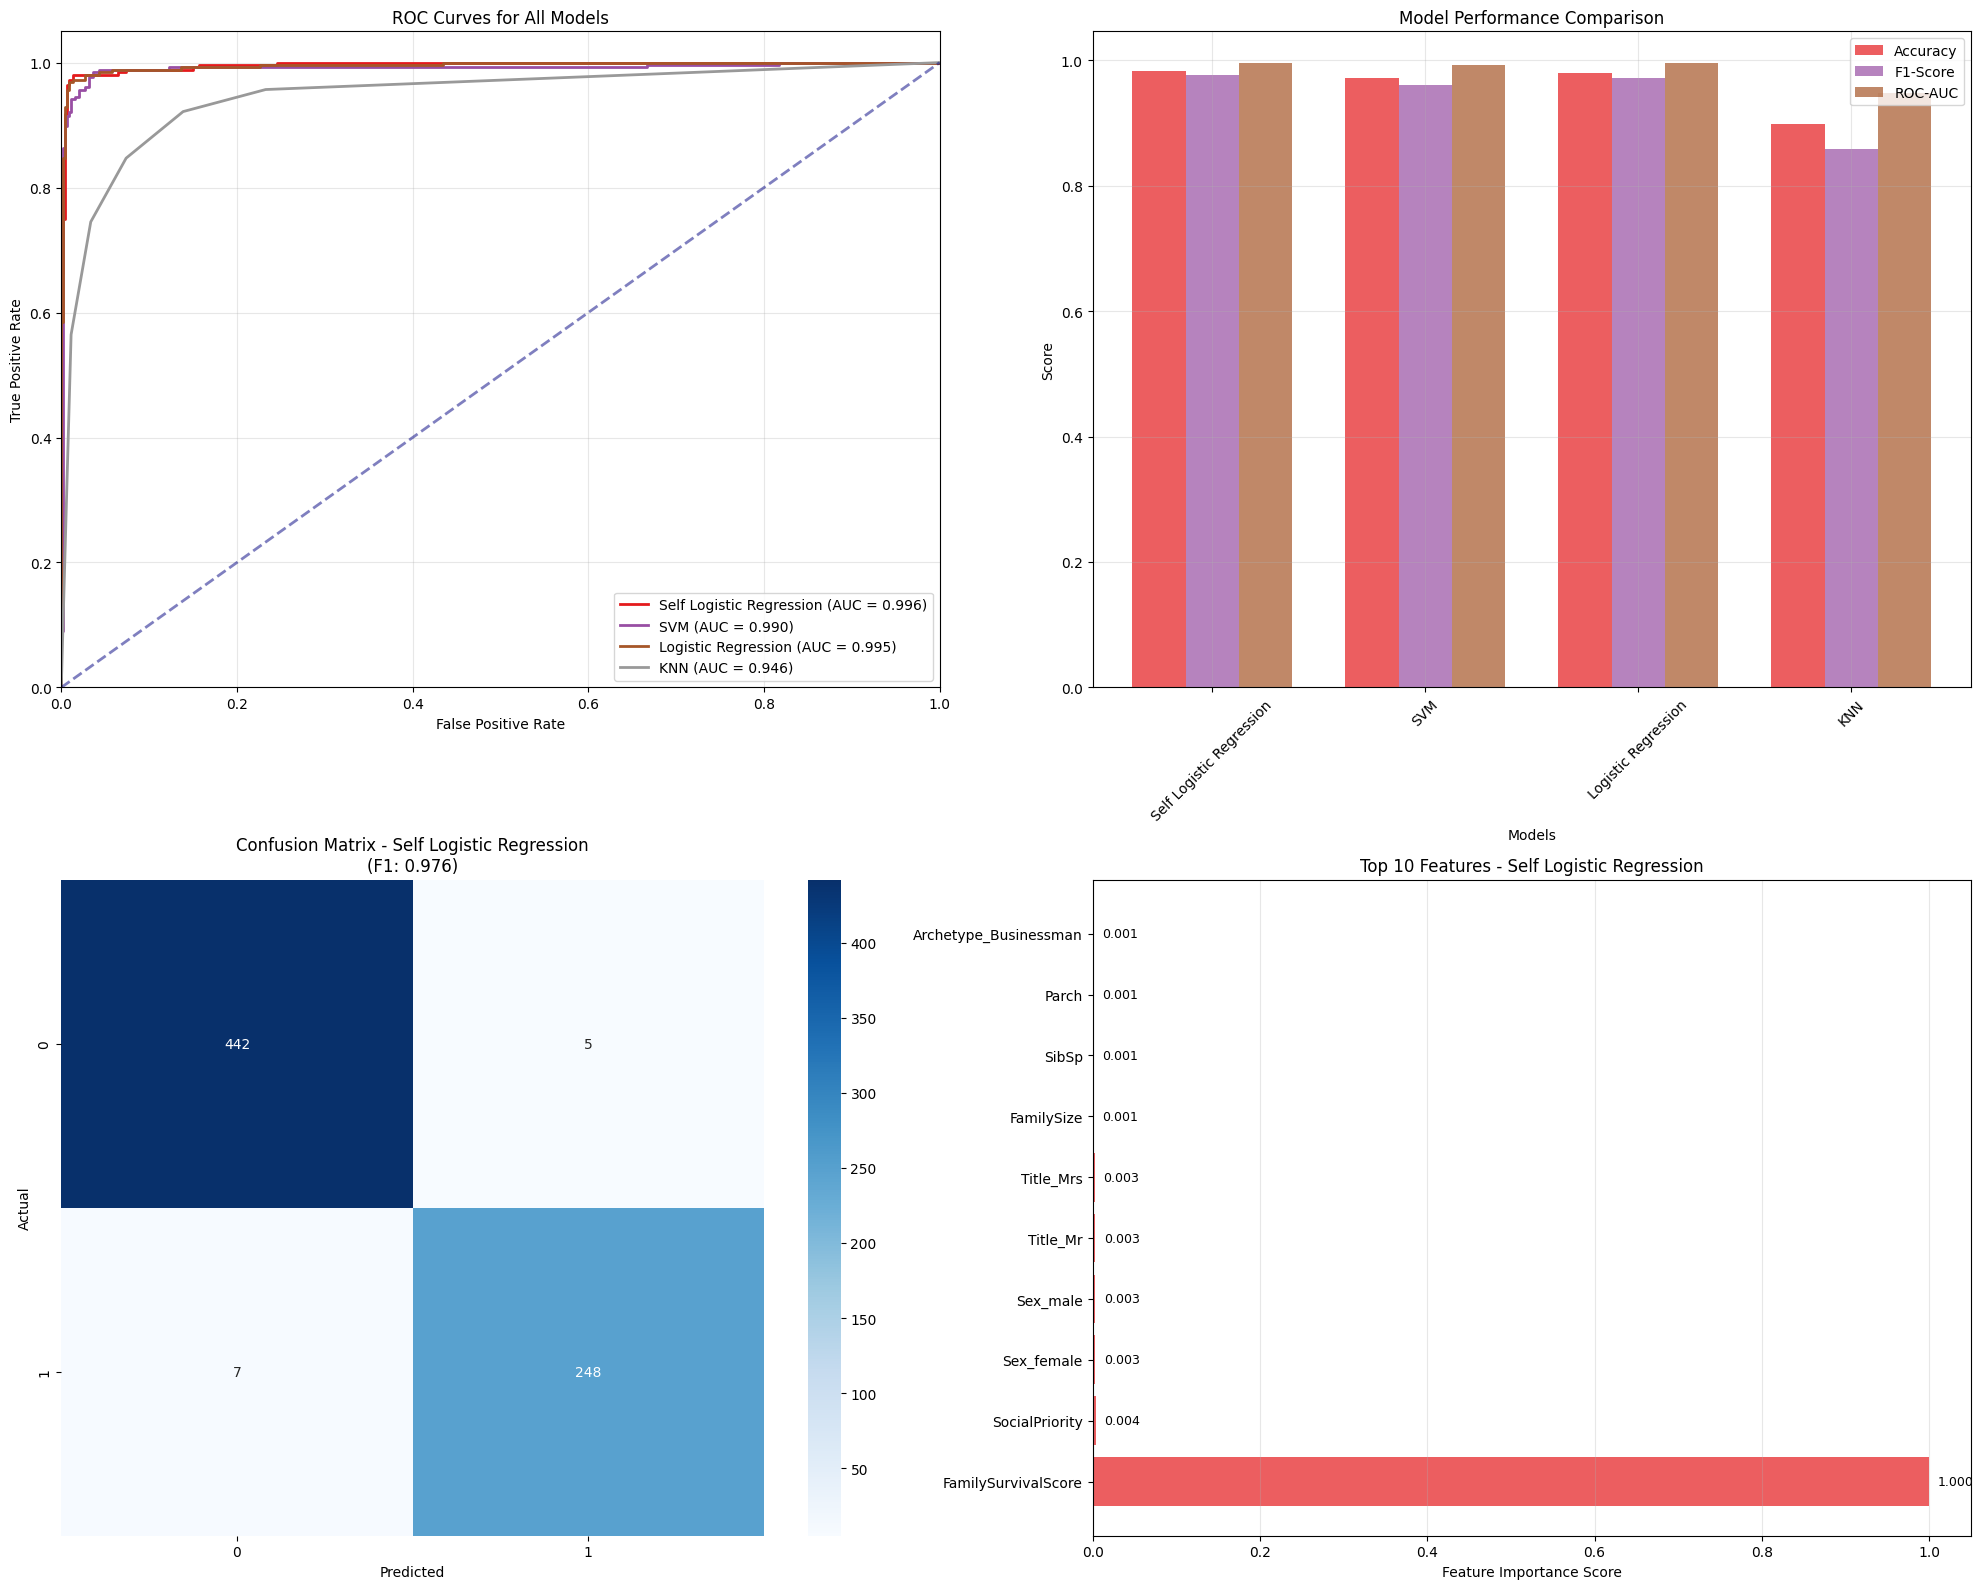


FEATURE IMPORTANCE - Self Logistic Regression
Feature                   Importance  
----------------------------------------
FamilySurvivalScore       1.0000
SocialPriority            0.0037
Sex_female                0.0034
Sex_male                  0.0034
Title_Mr                  0.0032
Title_Mrs                 0.0026
FamilySize                0.0015
SibSp                     0.0014
Parch                     0.0013
Archetype_Businessman     0.0009
Age                       0.0009
CompositeScore            0.0009
IsAlone                   0.0006
Archetype_WealthySingleWoman 0.0006
FarePerPerson             0.0005


{'Self Logistic Regression': {'accuracy': (0.9828976697061804,
   0.0072805782150419576),
  'f1': (0.9764298533793985, 0.009909030498023235),
  'roc_auc': (0.996014785439769, 0.0027798251410192467)},
 'SVM': {'accuracy': (0.9715096251266464, 0.009019648365484639),
  'f1': (0.960580170638423, 0.012663501256305892),
  'roc_auc': (0.9913696115150179, 0.0077867844628064144)},
 'Logistic Regression': {'accuracy': (0.9800506585612968,
   0.013835052495375236),
  'f1': (0.9719515687463105, 0.019742314614390646),
  'roc_auc': (0.9958003476047097, 0.0037895000258649676)},
 'KNN': {'accuracy': (0.8975075987841945, 0.028053673906536552),
  'f1': (0.8585052482832696, 0.03274557966581701),
  'roc_auc': (0.9472708134439793, 0.01205435446745823)}}

In [ ]:
# Список моделей
models = {
    "Self Logistic Regression": model_self_logistic,
    "SVM": model_svm,
    "Logistic Regression": model_logreg,
    "KNN": model_knn
}

df_lin.describe().T

test_models_pipeline(df_lin, target_col='Survived', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

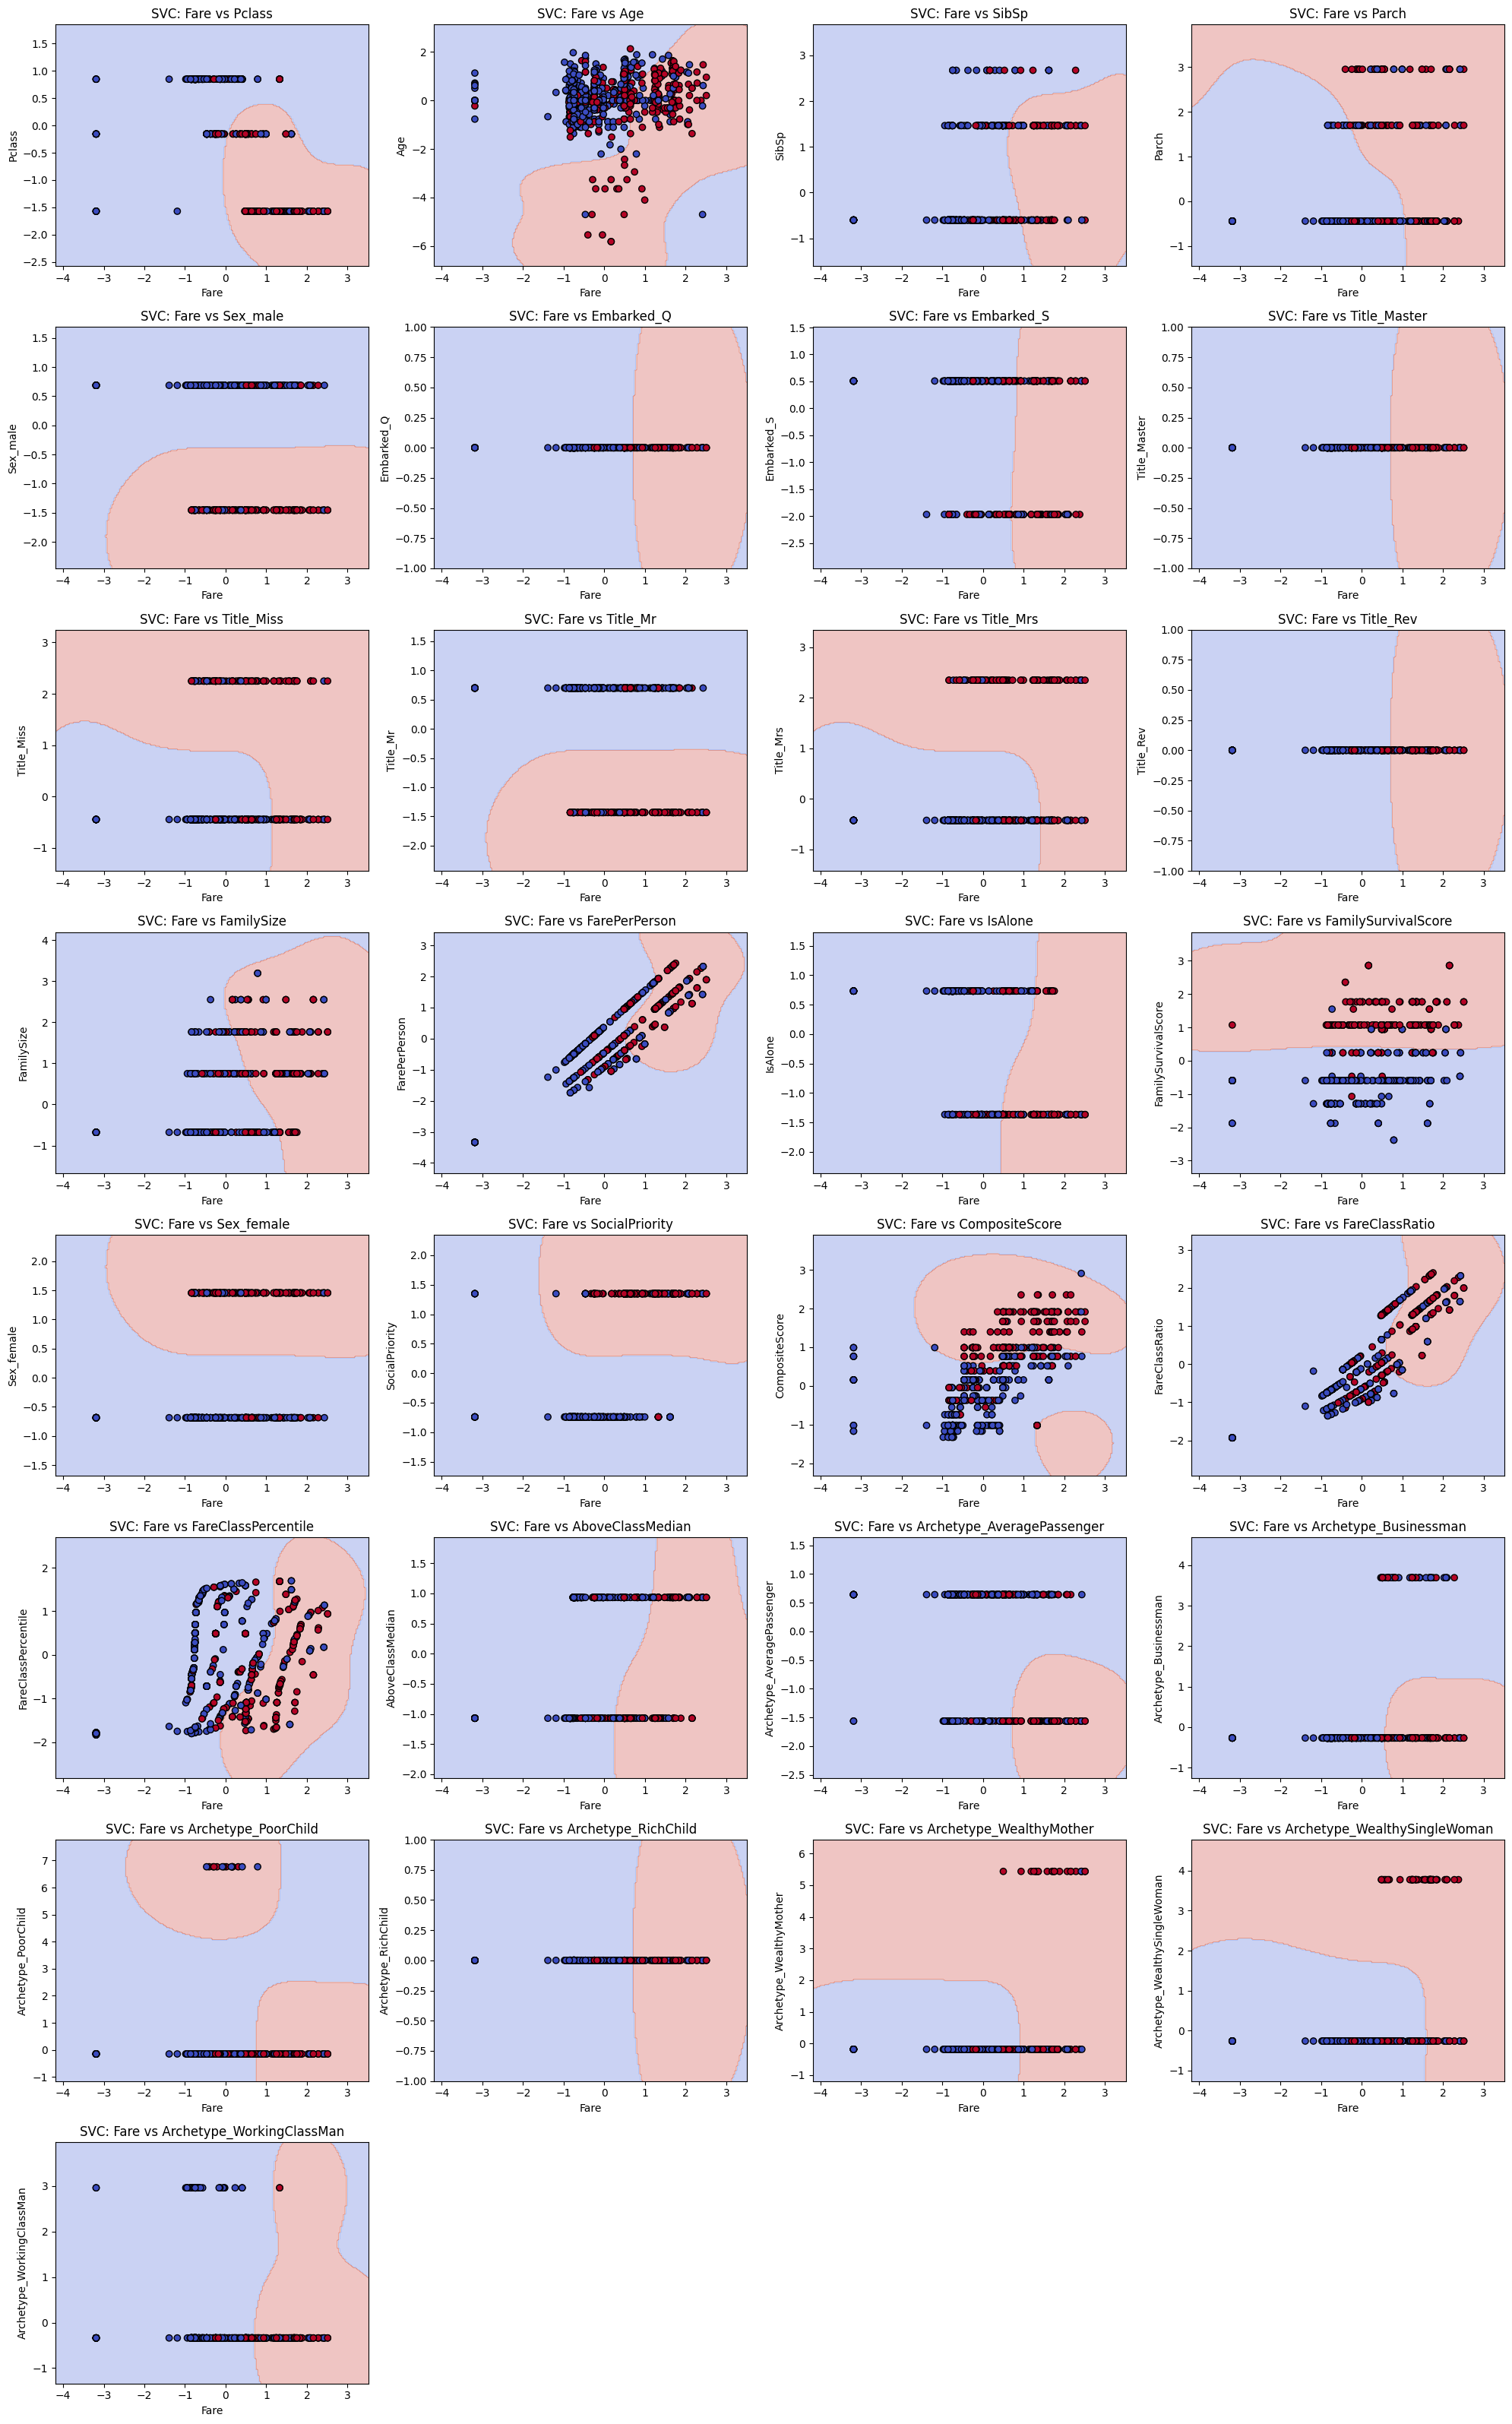

In [ ]:
plot_fixed_feature_decision_surface(
    df=df_lin,
    target_col='Survived',
    model=model_svm,
    fixed_feature='Fare',
    n_cols=4
)

### 4.1 Обучение и тесты моделей \{Desicion Tree, Random Forest\}

=== DesicionTreeNoDepth ===
Accuracy: 0.985 ± 0.013
F1-score: 0.981 ± 0.018
ROC-AUC: 0.985 ± 0.018

Calculating feature importance...


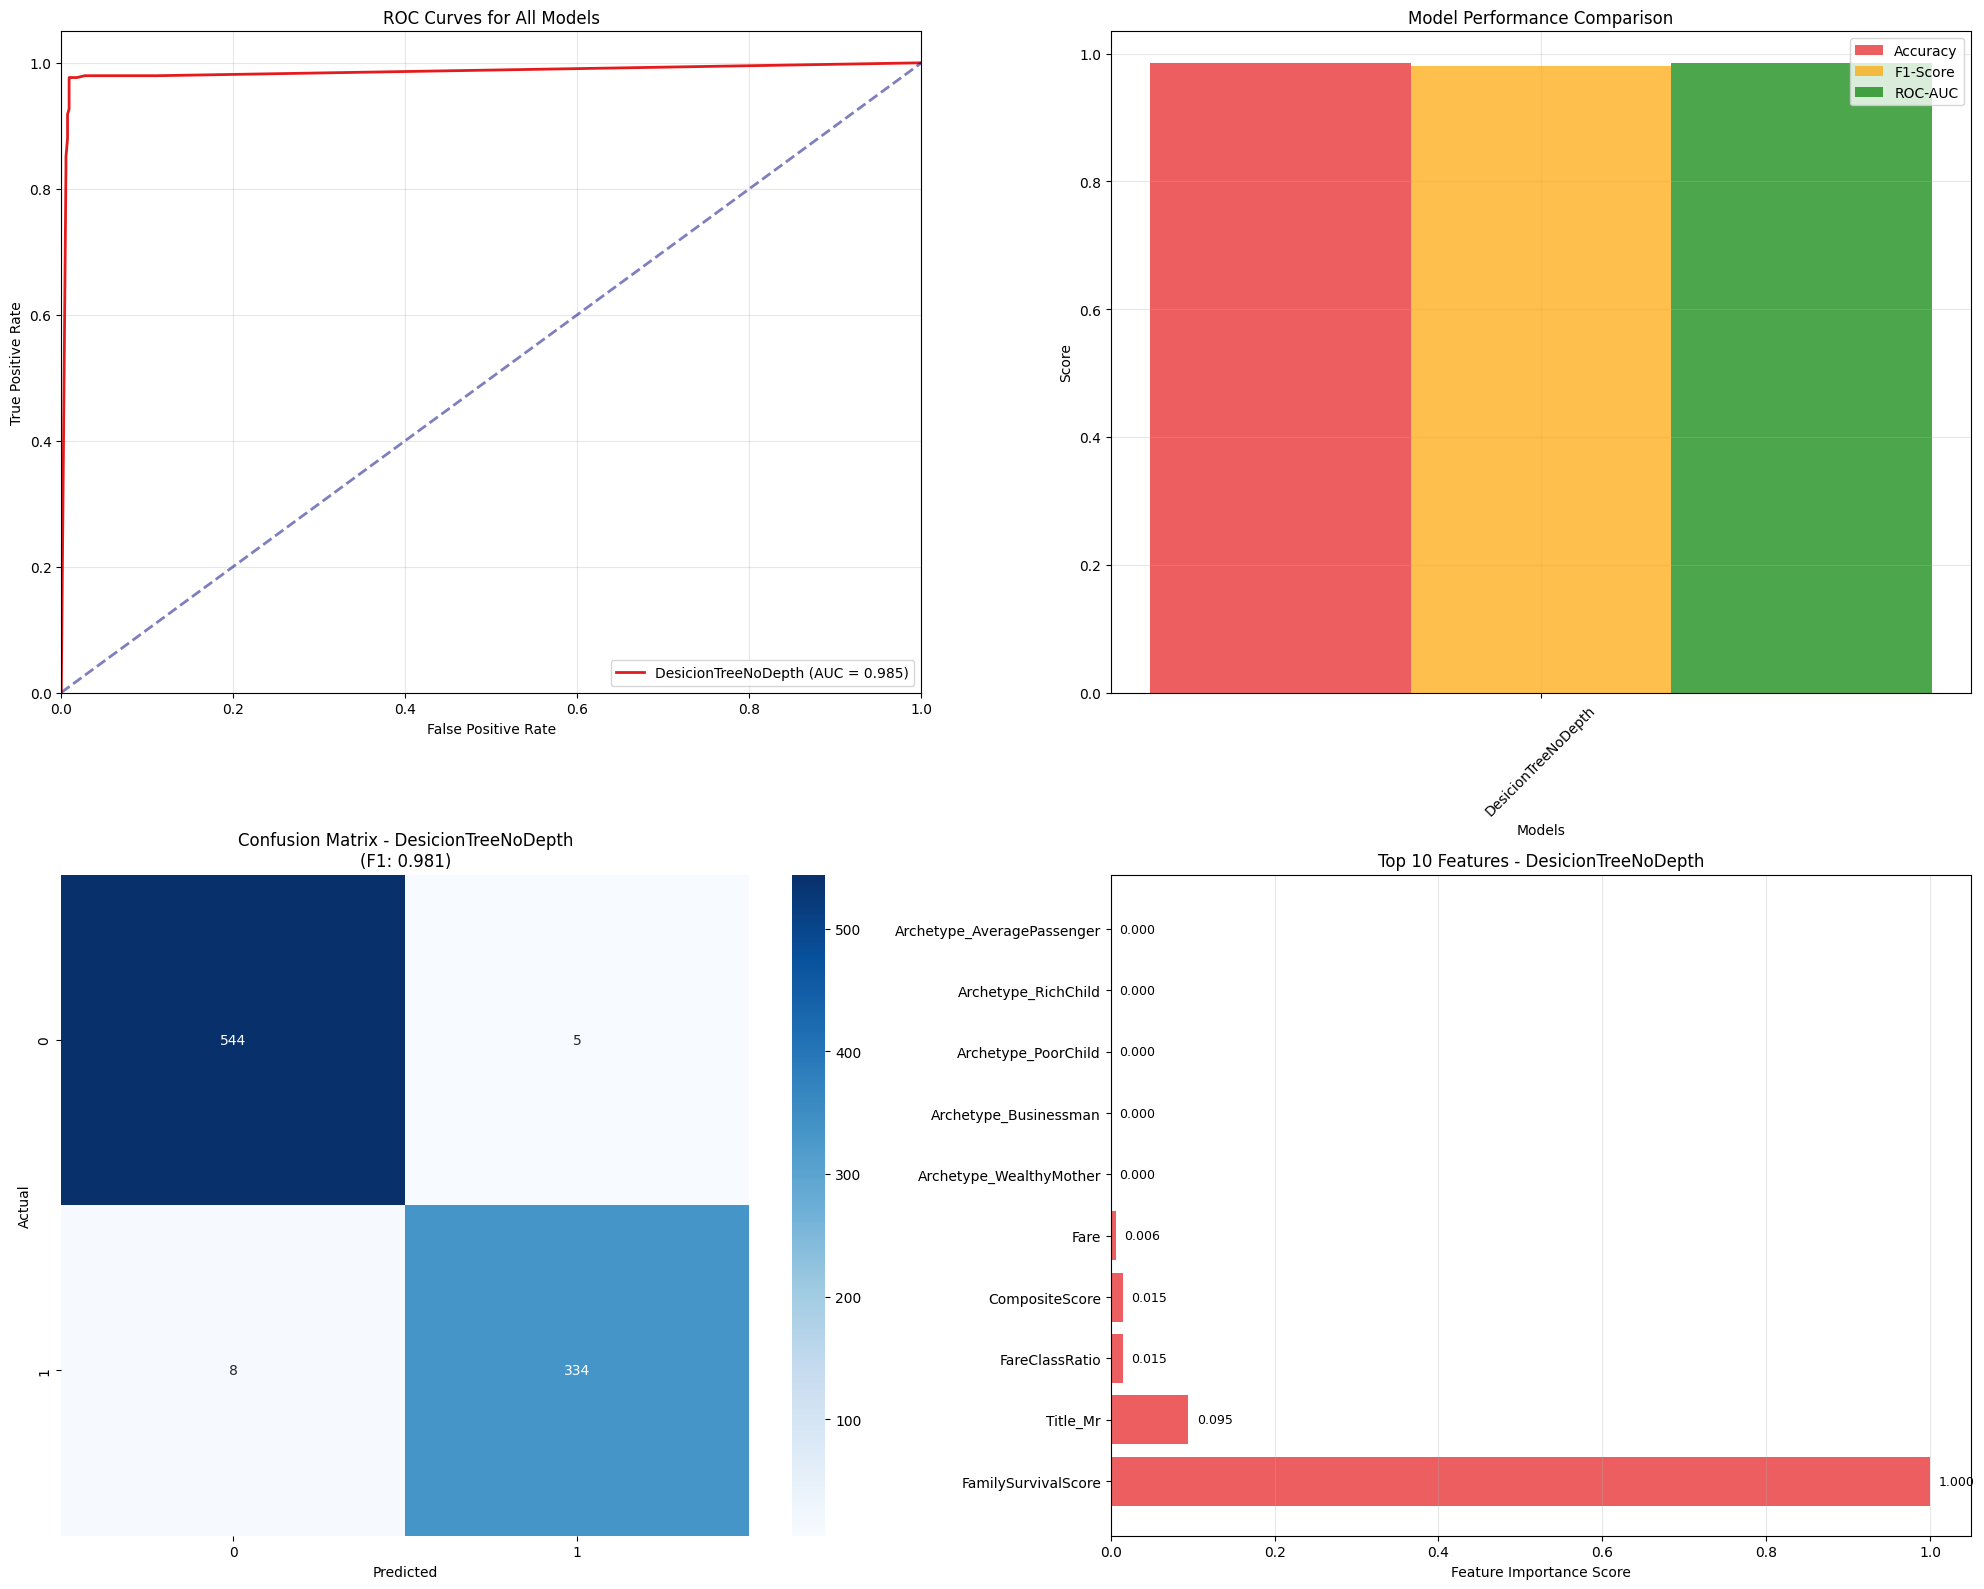


FEATURE IMPORTANCE - DesicionTreeNoDepth
Feature                   Importance  
----------------------------------------
FamilySurvivalScore       1.0000
Title_Mr                  0.0948
FareClassRatio            0.0146
CompositeScore            0.0145
Fare                      0.0062
Archetype_WealthyMother   0.0000
Archetype_Businessman     0.0000
Archetype_PoorChild       0.0000
Archetype_RichChild       0.0000
Archetype_AveragePassenger 0.0000
FareClassPercentile       0.0000
AboveClassMedian          0.0000
Archetype_WorkingClassMan 0.0000
Archetype_WealthySingleWoman 0.0000
Sex_female                0.0000


{'DesicionTreeNoDepth': {'accuracy': (0.9853932584269662, 0.01310326268504561),
  'f1': (0.9805746991793731, 0.01791615300850151),
  'roc_auc': (0.9854959642413009, 0.01845876344557433)}}

In [ ]:
# Список моделей
models = {
    "DesicionTreeNoDepth": model_tree,
    "RandomForest": model_forest
}

test_models_pipeline(df, target_col='Survived', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

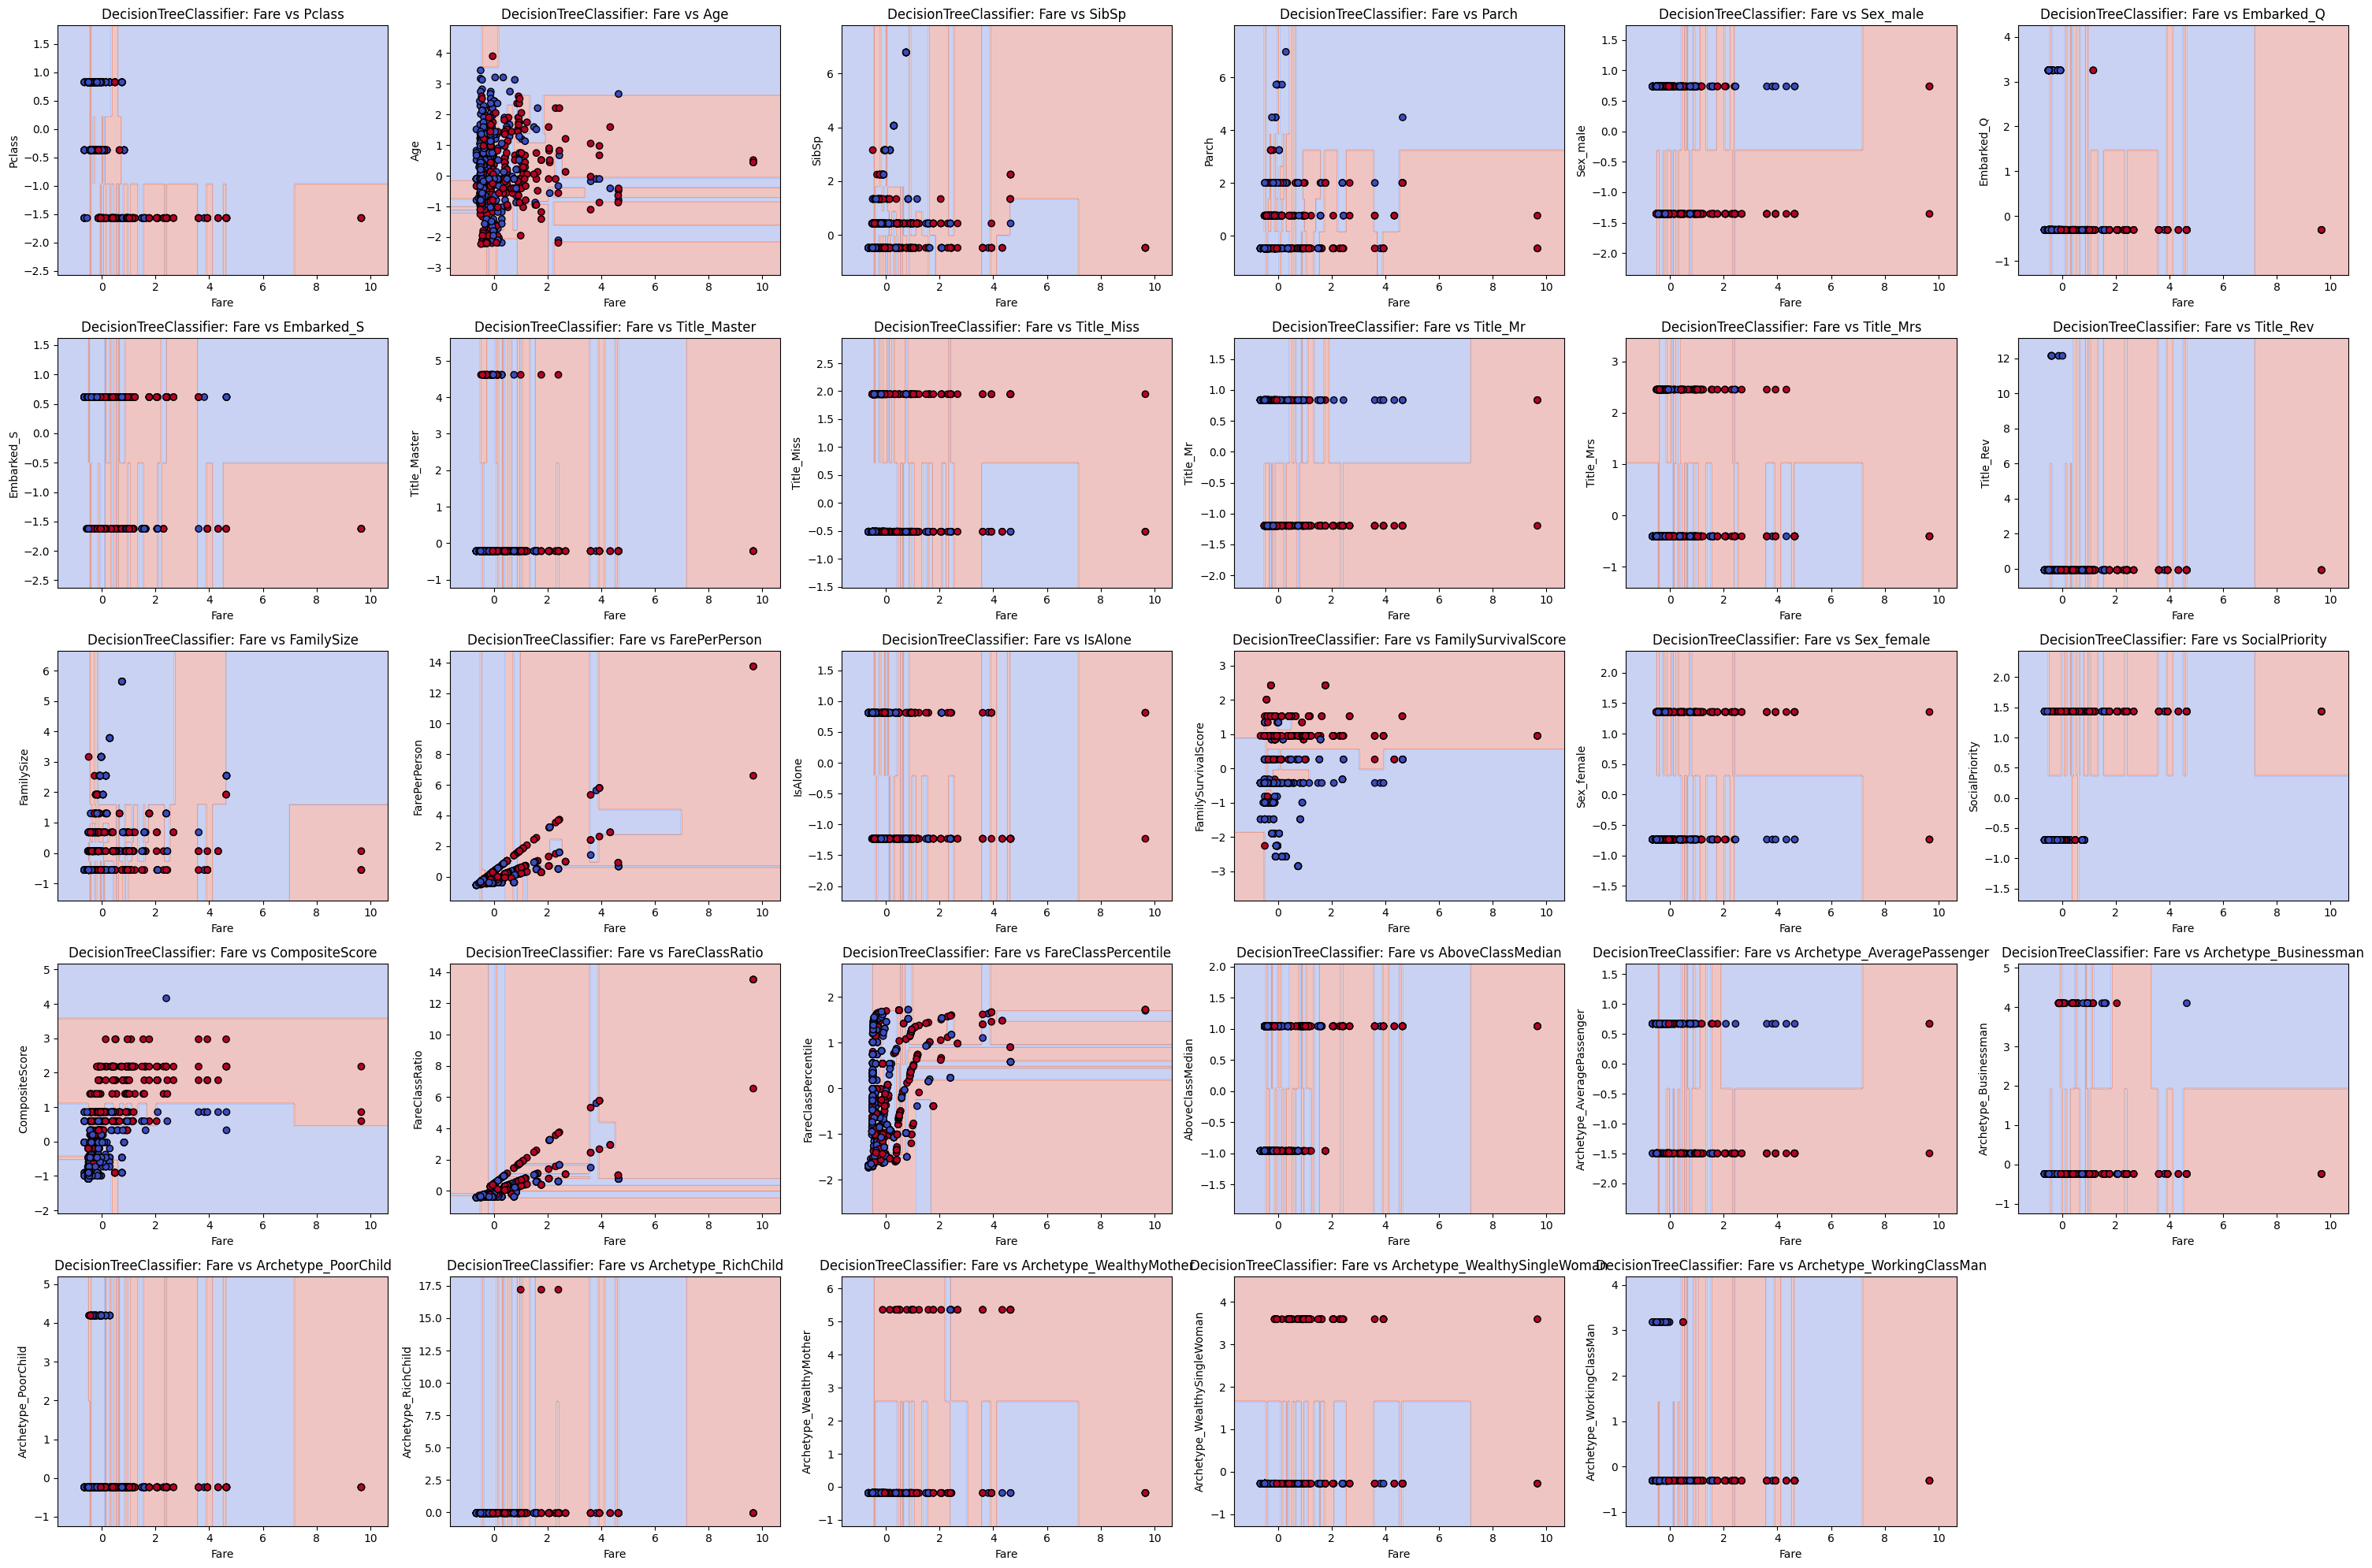

In [ ]:
plot_fixed_feature_decision_surface(
    df=df,
    target_col='Survived',
    model=model_tree,
    fixed_feature='Fare',
    n_cols=6
)

### 4.2 Обучение и тесты моделей \{Boosting Classifier, XGBoost, CatBoost\}

=== Boosting ===
Accuracy: 0.981 ± 0.015
F1-score: 0.975 ± 0.020
ROC-AUC: 0.992 ± 0.010

=== XGBoost ===
Accuracy: 0.983 ± 0.013
F1-score: 0.978 ± 0.017
ROC-AUC: 0.995 ± 0.006

=== CatBoost ===
Accuracy: 0.984 ± 0.013
F1-score: 0.979 ± 0.018
ROC-AUC: 0.994 ± 0.008

Calculating feature importance...


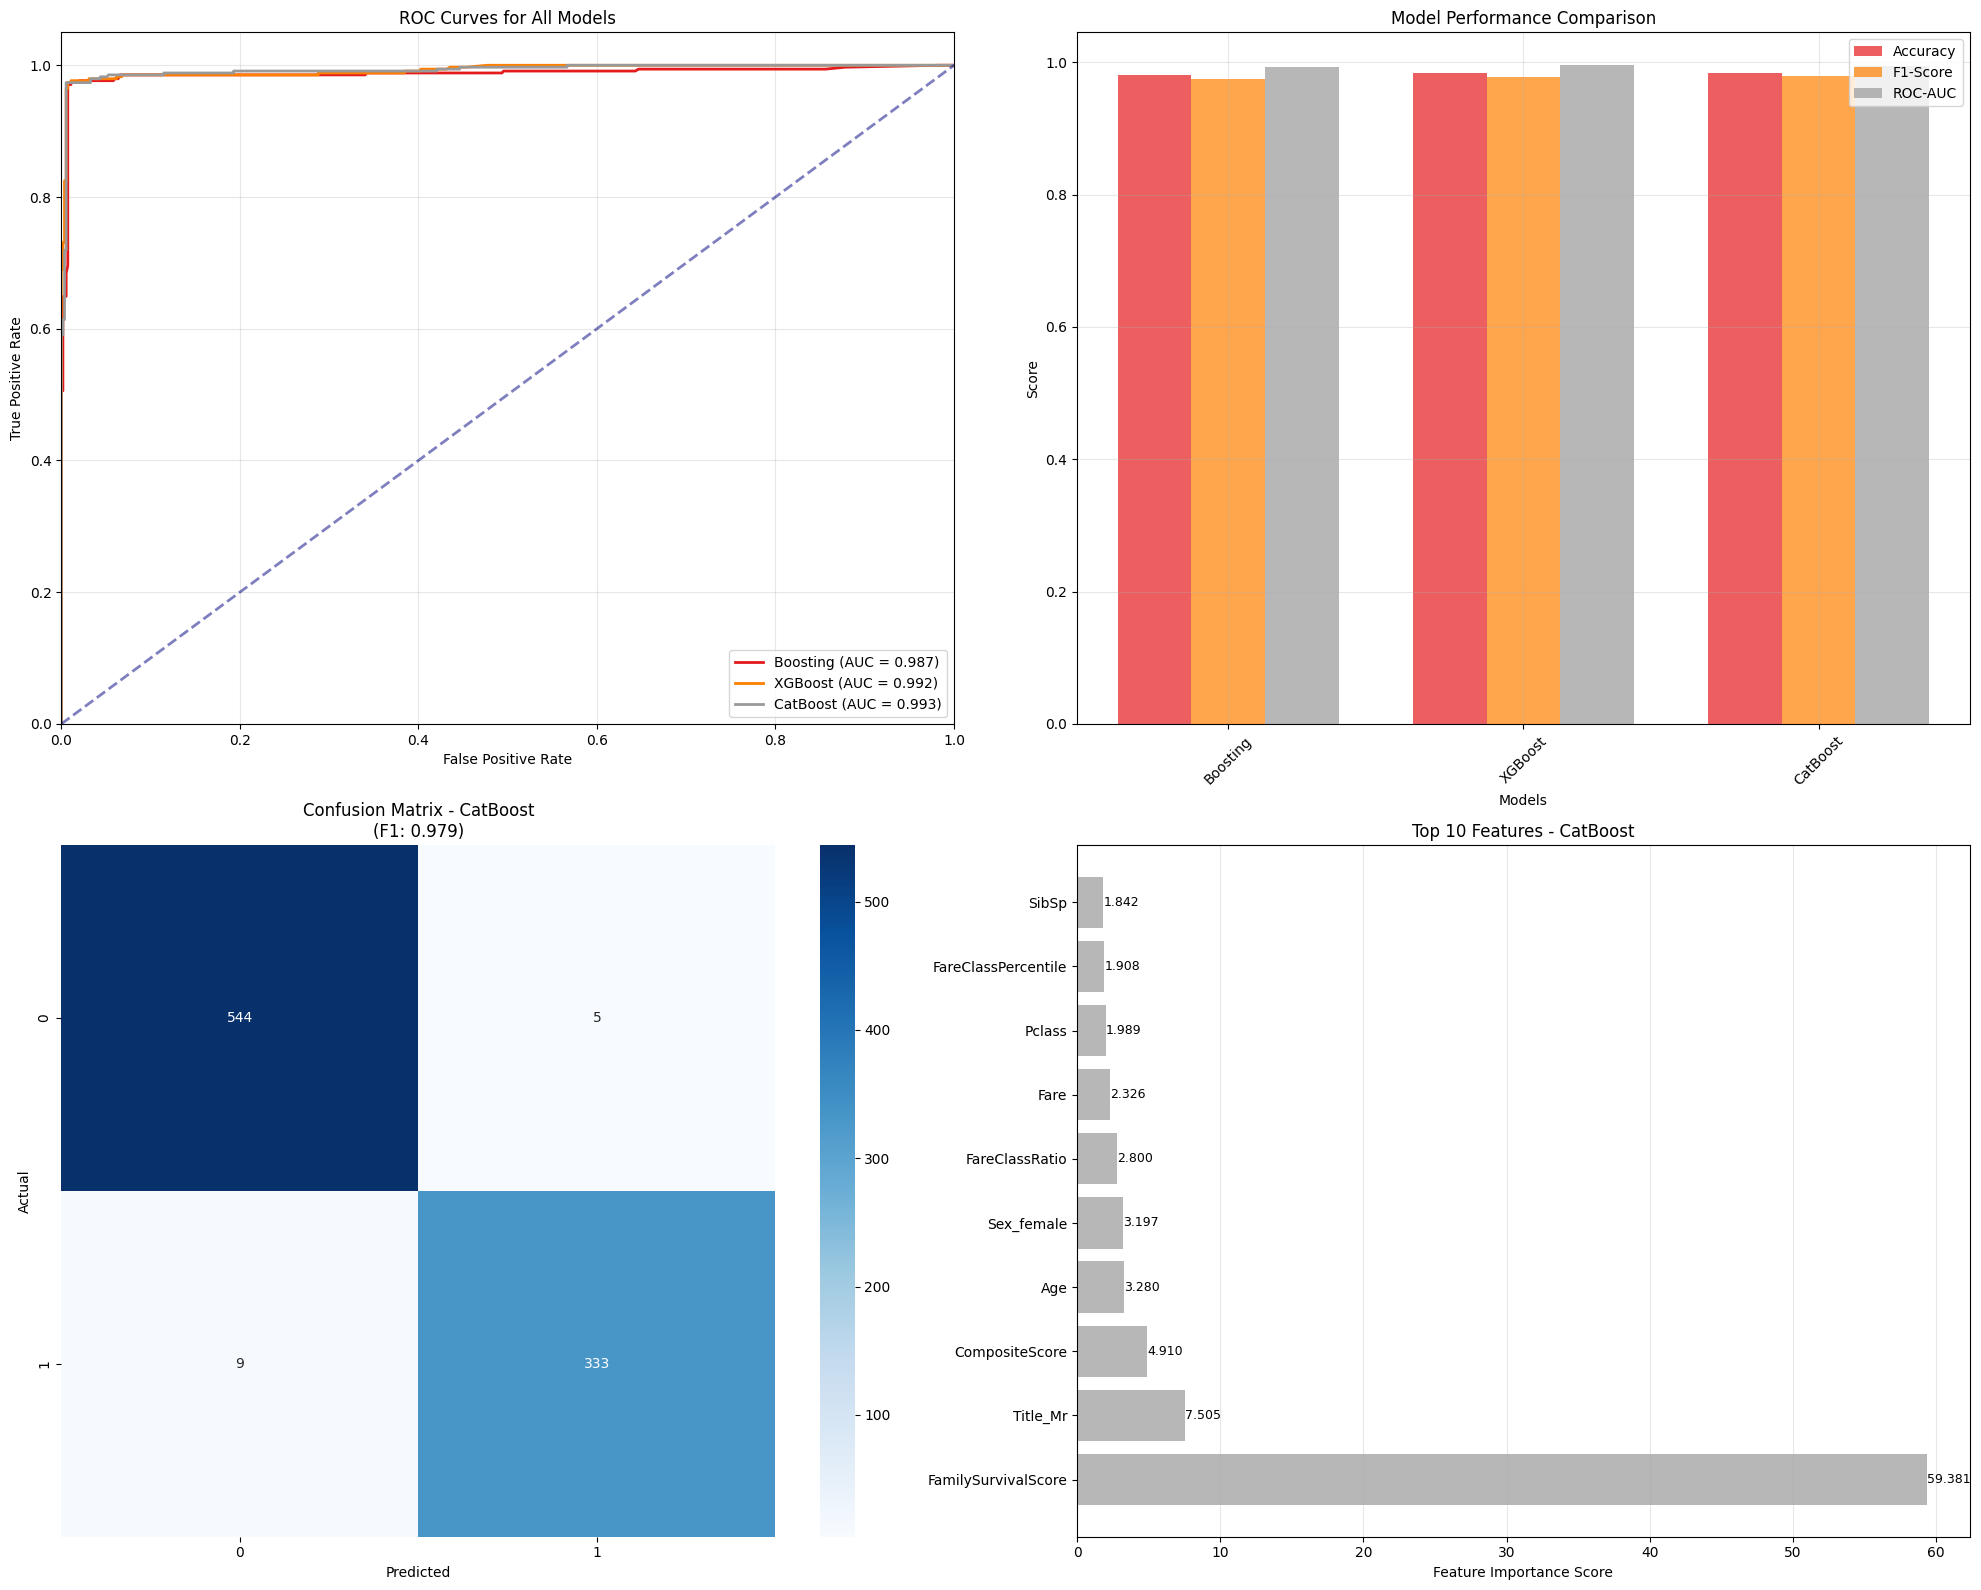


FEATURE IMPORTANCE - CatBoost
Feature                   Importance  
----------------------------------------
FamilySurvivalScore       59.3815
Title_Mr                  7.5050
CompositeScore            4.9096
Age                       3.2802
Sex_female                3.1972
FareClassRatio            2.7997
Fare                      2.3260
Pclass                    1.9889
FareClassPercentile       1.9079
SibSp                     1.8422
FamilySize                1.6776
Sex_male                  1.6539
IsAlone                   1.3078
FarePerPerson             1.2235
SocialPriority            0.7465


{'Boosting': {'accuracy': (0.9808988764044944, 0.014906178833057974),
  'f1': (0.9747813374503839, 0.020169759977578725),
  'roc_auc': (0.9920333245166653, 0.00995956776399656)},
 'XGBoost': {'accuracy': (0.9831460674157304, 0.012810959832574575),
  'f1': (0.9776534351675646, 0.017482266042488447),
  'roc_auc': (0.9953757162654018, 0.0062438456414732795)},
 'CatBoost': {'accuracy': (0.9842696629213483, 0.013006558317741817),
  'f1': (0.9790714312055169, 0.017771851219091653),
  'roc_auc': (0.9943192750139183, 0.007615596463013899)}}

In [ ]:
# Список моделей
models = {
    "Boosting": model_gb,
    "XGBoost": model_xgb,
    "CatBoost": model_cat
}

test_models_pipeline(df, target_col='Survived', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

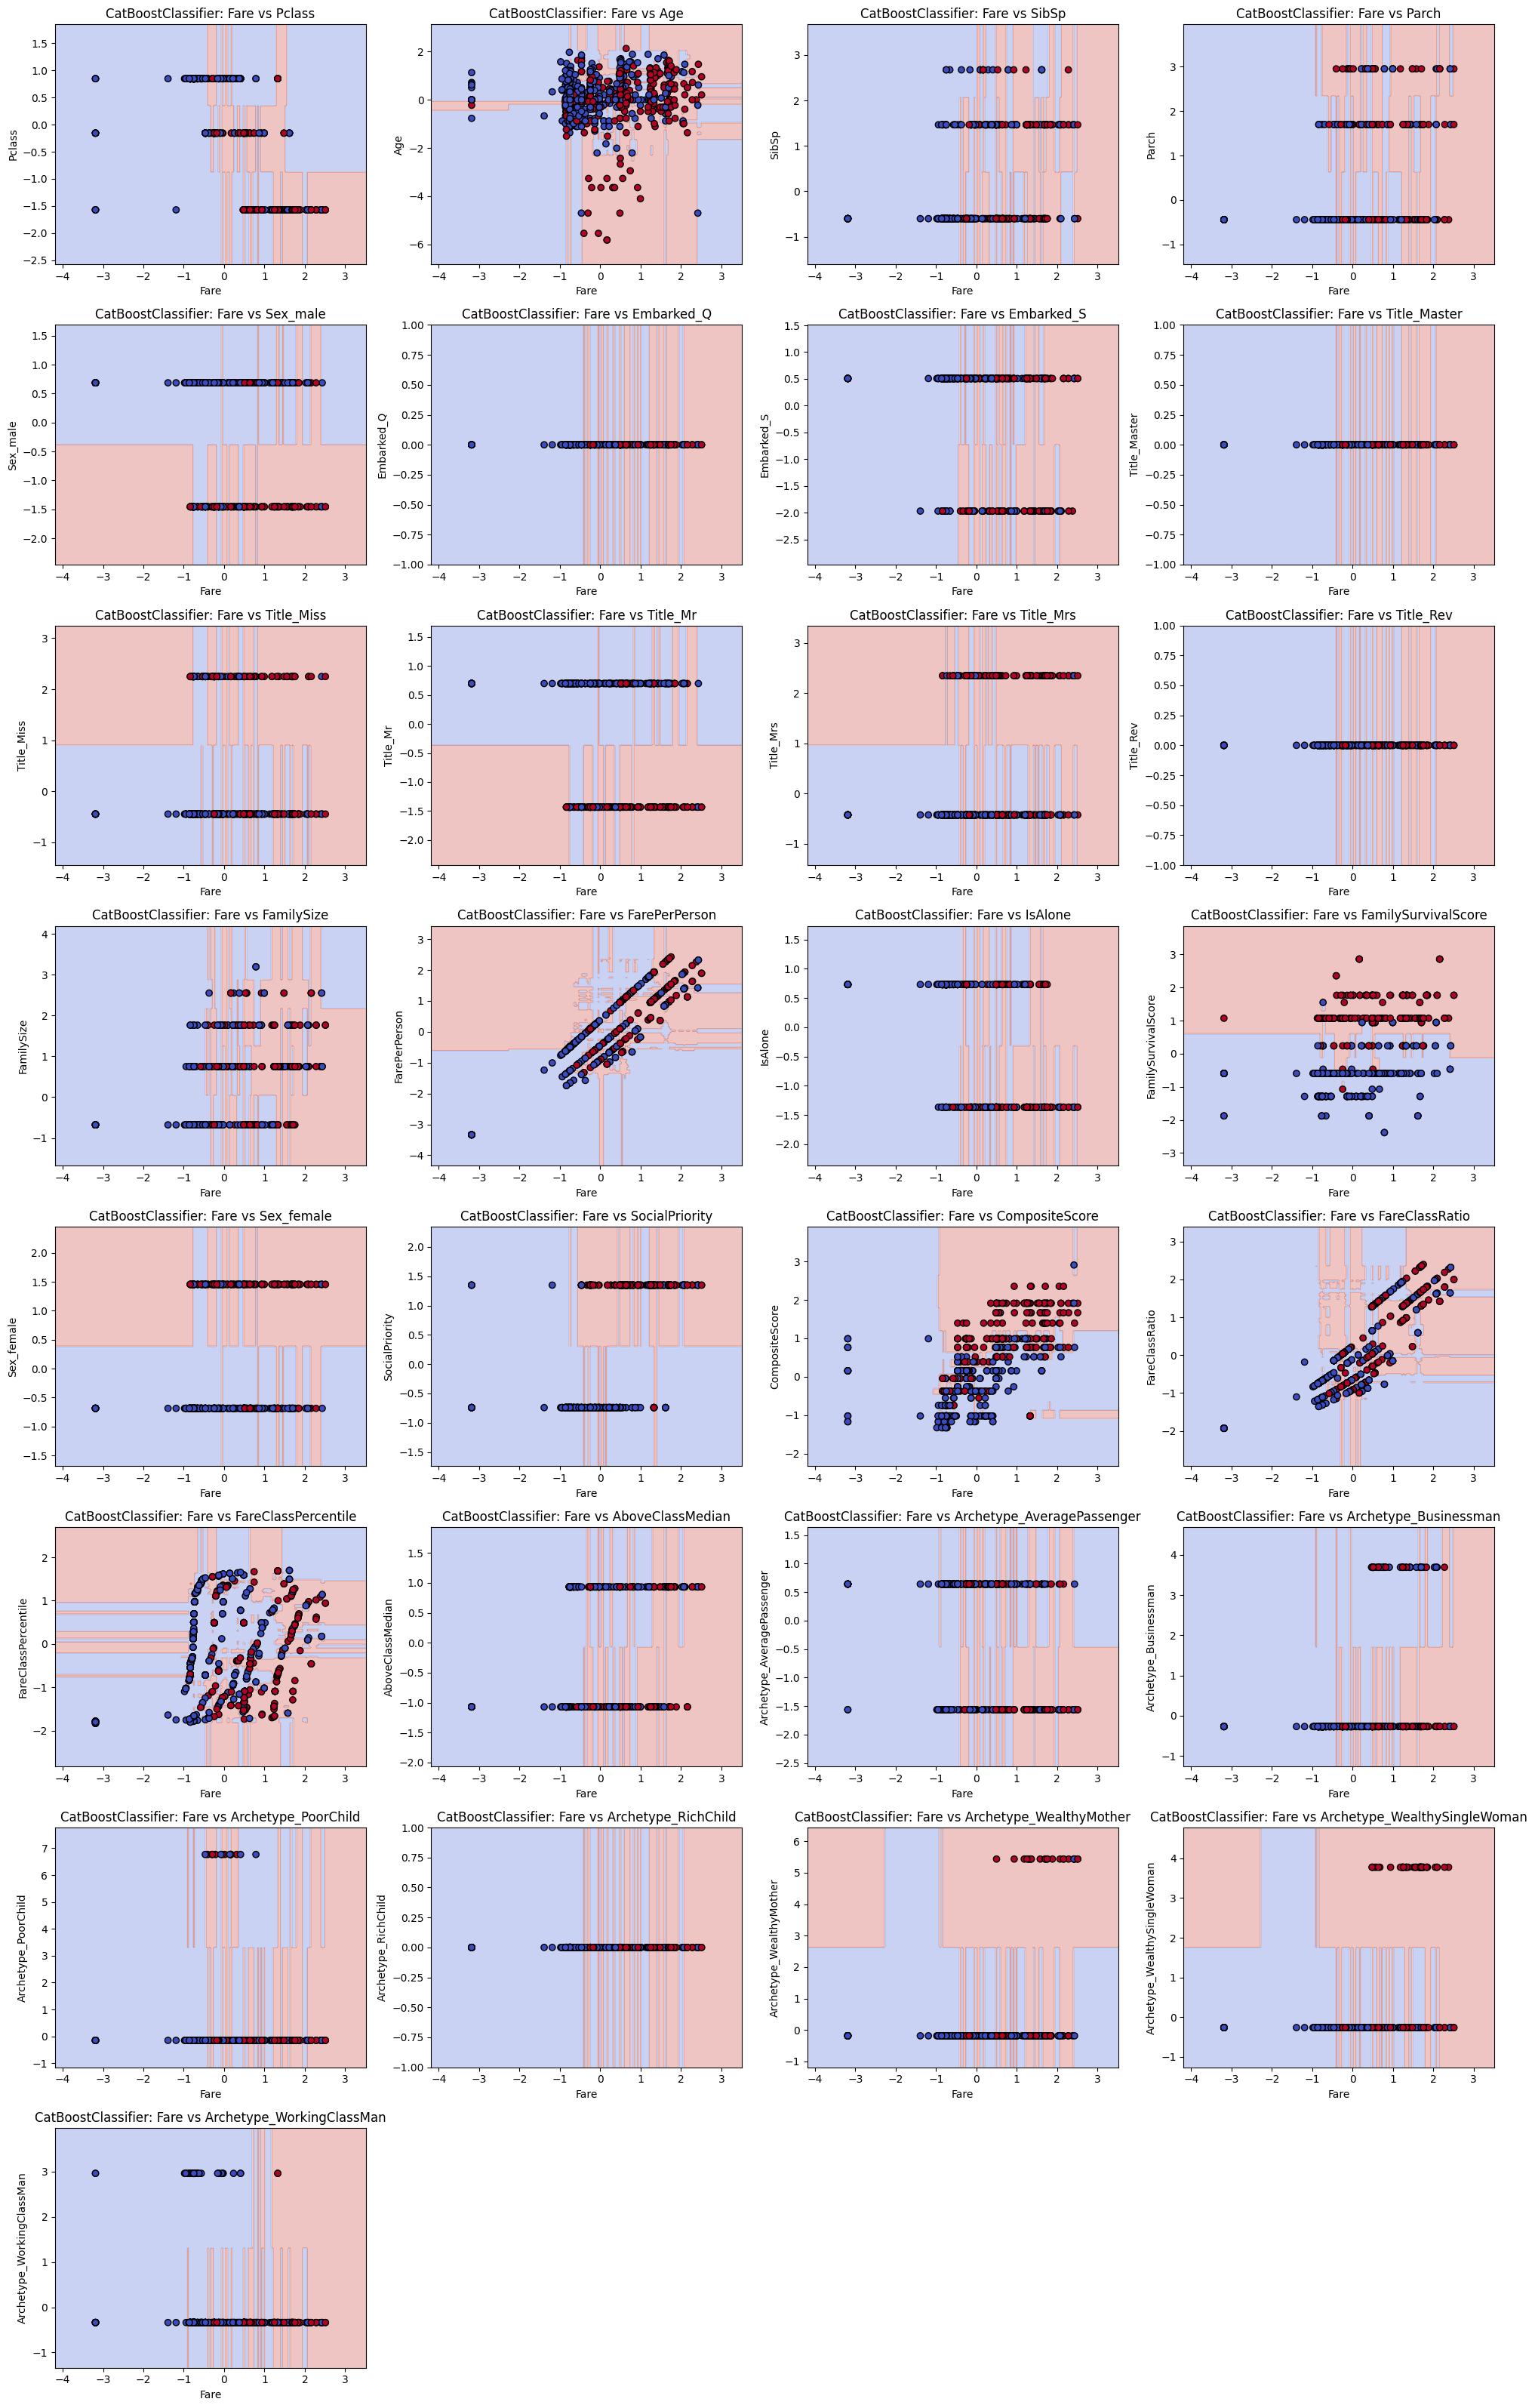

In [ ]:
plot_fixed_feature_decision_surface(
    df=df_lin,
    target_col='Survived',
    model=model_cat,
    fixed_feature='Fare',
    n_cols=4
)

## 5. Вопросы

**1. Классификация писем: спам или не спам**

**Вопрос:**
У нас есть набор писем, для каждого известны признаки:

* количество восклицательных знаков,
* доля заглавных букв,
* наличие слов вроде “free”, “win”, “discount”,
* длина письма,
* наличие ссылок.

Задача — определить, является ли письмо **спамом** или **нормальным**.

**Распределение данных:**

* Данные нелинейно разделимы, но умеренно шумные.
* Классы примерно сбалансированы (50/50).

**Ответ:**

- **Модель:**

```
Случайный лес
```

- **Почему:**

```
Случайный лес оптимален для этой задачи. Он хорошо работает с разнотипными признаками (количественные, бинарные), устойчив к шуму и переобучению, улавливает нелинейные зависимости и автоматически оценивает важность признаков. При сбалансированных классах не требует дополнительных корректировок.
```

**2. Прогноз сердечных заболеваний**

**Вопрос:**
Данные о пациентах:

* возраст, пол, давление, уровень холестерина, частота сердечных сокращений,
* наличие боли в груди и др.

Задача — определить, есть ли у человека сердечное заболевание.

**Распределение данных:**

* Классы умеренно сбалансированы (60/40).
* Признаки имеют нелинейные зависимости.

**Ответ:**

- **Модель:**

```
Градиентный бустинг
```

- **Почему:**

```
Медицинские данные часто содержат сложные нелинейные зависимости между признаками, которые градиентный бустинг эффективно выявляет через композицию деревьев. Он хорошо работает с табличными данными смешанного типа и умеренным дисбалансом 60/40, при этом меньше переобучается на шумах по сравнению с одним деревом. Дополнительный плюс — встроенная обработка категориальных признаков и возможность оценить важность каждого медицинского показателя для прогноза.
```

**3. Распознавание видов ирисов (Iris dataset)**

**Вопрос:**
По измерениям длины и ширины лепестков и чашелистиков нужно определить вид ириса:
`setosa`, `versicolor` или `virginica`.

**Распределение данных:**

* Данные чистые, малошумные.
* Классы хорошо разделяются в пространстве признаков.

**Ответ:**

- **Модель:**

```
Линейная модель (логистическая регрессия) или метод опорных векторов с линейным ядром
```

- **Почему:**

```
Данные чистые и хорошо линейно разделяются, особенно между setosa и остальными видами. Линейные модели работают быстро, дают точные предсказания на таких структурированных данных и легко интерпретируются. Не нужна сложная модель, так как классы отлично разделяются простыми границами.
```

**6. Классификация отзывов о фильмах (положительный / отрицательный)**

**Вопрос:**
Для каждого отзыва по фильму дан текст. Нужно определить, положительный он или отрицательный.
Используются текстовые признаки — мешок слов (TF-IDF).

**Распределение данных:**

* Очень высокое число признаков (10k+ слов).
* Данные разреженные.

**Ответ:**

- **Модель:**

```
Линейные методы (логистическая регрессия или линейный SVM)
```

- **Почему:**

```
Для текстовых данных с десятками тысяч разреженных признаков (TF-IDF) линейные модели работают оптимально. Они эффективно вычисляют веса для каждого слова, устойчивы к шуму и быстро обучаются на больших размерностях. Нейронные сети потребовали бы больше данных и вычислительных ресурсов без значительного выигрыша в качестве.
```
